# **Prepare Data**

## **Import Library**

In [1]:
# Import library
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

## **Load Data**

In [2]:
# Load Data
path = "../Data Arduino 4 treatment/fixed_formatData.xlsx"
df = pd.read_excel(path)
df

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan
0     151  149.0  106.40                73          0            1
1     151  149.0  109.78                73          0            1
2     149  149.0  106.40                73          0            1
3     149  149.0  130.06                73          0            1
4     149  151.4  106.40                73          0            1
...   ...    ...     ...               ...        ...          ...
1436  147  151.4  136.82                64          3            4
1437  149  153.8  140.20                64          3            4
1438  147  153.8  113.16                64          3            4
1439  149  153.8  123.30                64          3            4
1440  149  151.4  140.20                64          3            4

[1441 rows x 6 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   R                 1441 non-null   int64  
 1   G                 1441 non-null   float64
 2   B                 1441 non-null   float64
 3   IR_Intensity (%)  1441 non-null   int64  
 4   Perlakuan         1441 non-null   int64  
 5   Pengambilan       1441 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 67.7 KB


## **Checking Outliers**

### **Visualisasi Outliers**

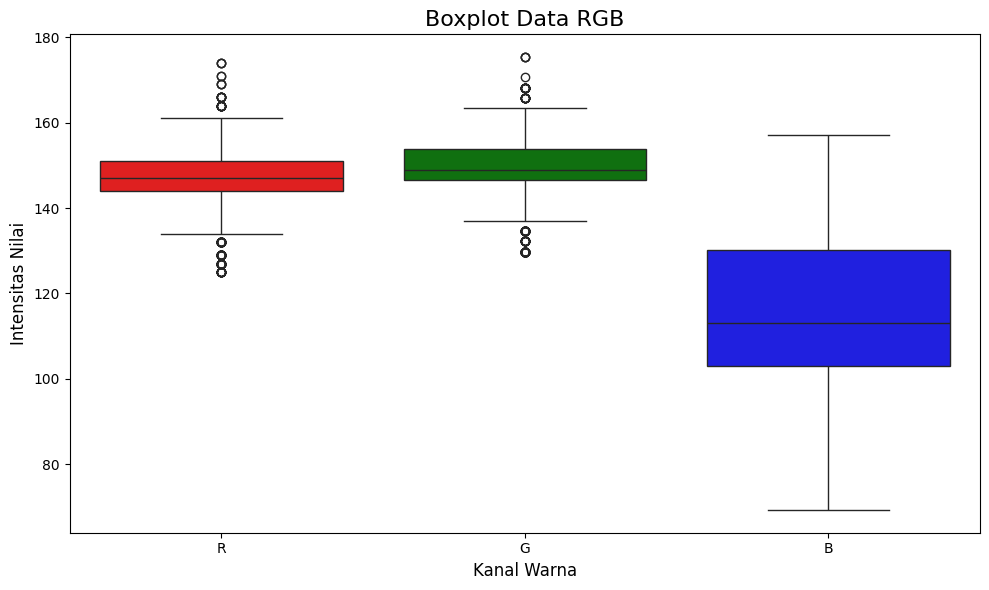

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['R', 'G', 'B']], palette=["red", "green", "blue"])
plt.title("Boxplot Data RGB", fontsize=16)
plt.ylabel("Intensitas Nilai", fontsize=12)
plt.xlabel("Kanal Warna", fontsize=12)
plt.tight_layout()
plt.show()


### **Mengatasi Outliers**

In [5]:
# Fungsi deteksi outlier dengan IQR
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound), lower_bound, upper_bound

In [6]:
# Membuat salinan DataFrame untuk analisis tanpa memodifikasi DataFrame asli
df_cleaned = df.copy()

# Ubah kolom 'R' menjadi tipe data float
df_cleaned['R'] = df_cleaned['R'].astype(float)

# Deteksi outlier dan ganti nilai outlier dengan batas IQR
for col in ['R', 'G', 'B']:
    outliers_mask, lower_bound, upper_bound = detect_outliers_iqr(df_cleaned[col])
    df_cleaned.loc[outliers_mask, col] = np.where(
        df_cleaned.loc[outliers_mask, col] < lower_bound, lower_bound, upper_bound
    )

In [7]:
# # # Membuat salinan DataFrame untuk analisis tanpa memodifikasi DataFrame asli
# df_cleaned = df.copy()

# # Terapkan Winsorization langsung pada kolom R, G, dan B
# df_cleaned['R'] = winsorize(df_cleaned['R'], limits=[0.05, 0.05])
# df_cleaned['G'] = winsorize(df_cleaned['G'], limits=[0.05, 0.05])
# df_cleaned['B'] = winsorize(df_cleaned['B'], limits=[0.05, 0.05])

In [8]:
# # Membuat salinan DataFrame untuk analisis tanpa memodifikasi DataFrame asli
# df_cleaned = df.copy()

# # Menghapus outlier dari salinan DataFrame
# df_cleaned = df_cleaned[~df_cleaned['R'].isin(outliers_R)]
# df_cleaned = df_cleaned[~df_cleaned['G'].isin(outliers_G)]
# df_cleaned = df_cleaned[~df_cleaned['B'].isin(outliers_B)]

# # Menampilkan jumlah data sebelum dan sesudah pembersihan
# print("Jumlah data sebelum pembersihan:", len(df))
# print("Jumlah data setelah pembersihan:", len(df_cleaned))

## **Ekstraksi Fitur**

### **Normalisasi Kanal RGB**

In [9]:
def normalize_rgb(df):
    # Salin dataframe
    df_norm = df.copy()
    # Normalisasi kolom R, G, dan B
    df_norm['r'] = df_norm['R'] / 255
    df_norm['g'] = df_norm['G'] / 255
    df_norm['b'] = df_norm['B'] / 255

    return df_norm

In [10]:
df_norm=normalize_rgb(df)
df_norm

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  
0     0.584314  0.417255  
1     0.584314  0.430510  
2     0.584314  0.417255  
3     0.584314  0.510039  
4     0.593725  0.417255  
...        ...       ...  
1436  0.593725  0.536549  
1437  0.603137  0.549804  
1438  0.603137  0.443765  
1439  0.603137  0.483529  
1440  0.593725  0.549804  

[1441 rows x 9 columns]

### **Perbandingan Kanal**

In [11]:
def calculate_ratios(df):
    # Membuat salinan DataFrame agar yang asli tidak berubah
    df_rasio = df_norm.copy()

    # Hitung rasio R/G
    df_rasio['R_G_ratio'] = df_rasio['R'] / df_rasio['G']

    # Hitung rasio G/B
    df_rasio['G_B_ratio'] = df_rasio['G'] / df_rasio['B']

    return df_rasio

In [12]:
df_rasio = calculate_ratios(df_norm)
df_rasio

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  R_G_ratio  G_B_ratio  
0     0.584314  0.417255   1.013423   1.400376  
1     0.584314  0.430510   1.013423   1.357260  
2     0.584314  0.417255   1.000000   1.400376  
3     0.584314  0.510039   1.000000   1.145625  
4     0.593725  0.417255   0.984148   1.422932  
...        ...       ...        ...        ...  
1436  0.593725  0.536549   0.970938   1.106563  
1437  0.603137  0.549804   0.968791   1.097004  
1438  0.603137  0.443765   0.955787   1.359138  
1439  0.603137  0.483529   0.968791   1.247364  
1440  0.593725  0.549804   0.984148   1.079886  

[1441 rows x 11 columns]

### **Mencari Nilai HSV**

In [13]:
def rgb_to_hsv(df):
    # Salin dataframe
    df_hsv = df_rasio.copy()
    
    # Ekstrak kolom r, g, dan b
    r = df_hsv['r']
    g = df_hsv['g']
    b = df_hsv['b']

    # Hitung nilai maksimum (V) dan minimum (m)
    cmax = np.maximum.reduce([r, g, b])
    cmin = np.minimum.reduce([r, g, b])
    delta = cmax - cmin

    # Hitung Hue (H)
    def calculate_hue():
        hue = np.zeros_like(delta)  # Default hue adalah 0
        mask_r_max = (cmax == r) & (delta != 0)
        mask_g_max = (cmax == g) & (delta != 0)
        mask_b_max = (cmax == b) & (delta != 0)

        # Rumus untuk hue jika R adalah maksimum
        hue[mask_r_max] = (60 * ((g[mask_r_max] - b[mask_r_max]) / delta[mask_r_max]) + 360) % 360

        # Rumus untuk hue jika G adalah maksimum
        hue[mask_g_max] = (60 * ((b[mask_g_max] - r[mask_g_max]) / delta[mask_g_max]) + 120) % 360

        # Rumus untuk hue jika B adalah maksimum
        hue[mask_b_max] = (60 * ((r[mask_b_max] - g[mask_b_max]) / delta[mask_b_max]) + 240) % 360

        return hue

    h = calculate_hue()

    # Hitung Saturation (S)
    s = np.where(cmax != 0, delta / cmax, 0)

    # Value (V) adalah nilai maksimum
    v = cmax

    # Tambahkan kolom h, s, dan v ke DataFrame
    df_hsv['H'] = h
    df_hsv['S'] = s
    df_hsv['V'] = v

    return df_hsv

In [14]:
df_hsv=rgb_to_hsv(df_rasio)
df_hsv

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  R_G_ratio  G_B_ratio          H         S         V  
0     0.584314  0.417255   1.013423   1.400376  57.309417  0.295364  0.592157  
1     0.584314  0.430510   1.013423   1.357260  57.088792  0.272980  0.592157  
2     0.584314  0.417255   1.000000   1.400376  60.000000  0.285906  0.584314  
3     0.584314  0.510039   1.000000   1.145625  60.000000  0.127114  0.584314  
4     0.593725  0.417255   0.984148   1.422932  63.200000  0.297226  0.593725  
...        ...       ...        ...        ...        ...       ...       ...  
1436  0.593725  0.536549   0.970938   1.106563  78.106996  0.096301  0.593725  
1437  0.603137  0.549804   0.968791   1.097004  81.176471  0.088427  0.603137  
1438  0.603137  0.443765   0.955787   1.359138  70.039370  0.264239  0.603137  
1439  0.603137  0.483529   0.968791   1.247364  69.442623  0.198309  0.603137  
1440  0.593725  0.549804   0.984148   1.079886  72.857143  0.073976  0.593725  

[1441 rows x 14 columns]

### **Mencari Nilai Lab**

#### **Hitung Manual**

In [15]:
def rgb_to_lab(df):
    # Membuat salinan DataFrame agar yang asli tidak berubah
    df_lab = df_hsv.copy()

    # Normalisasi RGB ke rentang [0, 1]
    r = df_lab['r']
    g = df_lab['g']
    b = df_lab['b']

    # Koreksi gamma untuk nilai RGB
    def gamma_correction(c):
        return np.where(c > 0.04045, ((c + 0.055) / 1.055) ** 2.4, c / 12.92)

    # Terapkan koreksi gamma
    r_linear = gamma_correction(r)
    g_linear = gamma_correction(g)
    b_linear = gamma_correction(b)

    # Transformasi RGB ke XYZ menggunakan matriks standar
    X = 0.4124564 * r_linear + 0.3575761 * g_linear + 0.1804375 * b_linear
    Y = 0.2126729 * r_linear + 0.7151522 * g_linear + 0.0721750 * b_linear
    Z = 0.0193339 * r_linear + 0.1191920 * g_linear + 0.9503041 * b_linear

    # Nilai referensi untuk XYZ (D65/2° standard illuminant)
    Xn, Yn, Zn = 0.95047, 1.0, 1.08883

    # Fungsi untuk menghitung f(t)
    def f(t):
        return np.where(t > 0.008856, t ** (1/3), 7.787 * t + 16/116)

    # Hitung L, a, dan b
    L = 116 * f(Y / Yn) - 16
    a = 500 * (f(X / Xn) - f(Y / Yn))
    b = 200 * (f(Y / Yn) - f(Z / Zn))

    # Tambahkan kolom L, a, dan b ke DataFrame
    df_lab['cL'] = L
    df_lab['ca'] = a
    df_lab['cb'] = b

    return df_lab

In [16]:
df_lab=rgb_to_lab(df_hsv)
df_lab

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  R_G_ratio  G_B_ratio          H         S         V  \
0     0.584314  0.417255   1.013423   1.400376  57.309417  0.295364  0.592157   
1     0.584314  0.430510   1.013423   1.357260  57.088792  0.272980  0.592157   
2     0.584314  0.417255   1.000000   1.400376  60.000000  0.285906  0.584314   
3     0.584314  0.510039   1.000000   1.145625  60.000000  0.127114  0.584314   
4     0.593725  0.417255   0.984148   1.422932  63.200000  0.297226  0.593725   
...        ...       ...        ...        ...        ...       ...       ...   
1436  0.593725  0.536549   0.970938   1.106563  78.106996  0.096301  0.593725   
1437  0.603137  0.549804   0.968791   1.097004  81.176471  0.088427  0.603137   
1438  0.603137  0.443765   0.955787   1.359138  70.039370  0.264239  0.603137   
1439  0.603137  0.483529   0.968791   1.247364  69.442623  0.198309  0.603137   
1440  0.593725  0.549804   0.984148   1.079886  72.857143  0.073976  0.593725   

             cL        ca         cb  
0     60.890564 -6.299734  22.830546  
1     60.953899 -5.827671  21.044019  
2     60.723155 -7.112026  22.577013  
3     61.218617 -3.447379  10.020923  
4     61.395413 -8.411532  23.476470  
...         ...       ...        ...  
1436  61.883257 -4.341136   7.130325  
1437  62.788701 -4.301695   6.543102  
1438  62.035710 -9.534773  20.581252  
1439  62.399884 -7.187258  15.471242  
1440  62.126888 -2.982561   5.593500  

[1441 rows x 17 columns]

In [17]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   R                 1441 non-null   int64  
 1   G                 1441 non-null   float64
 2   B                 1441 non-null   float64
 3   IR_Intensity (%)  1441 non-null   int64  
 4   Perlakuan         1441 non-null   int64  
 5   Pengambilan       1441 non-null   int64  
 6   r                 1441 non-null   float64
 7   g                 1441 non-null   float64
 8   b                 1441 non-null   float64
 9   R_G_ratio         1441 non-null   float64
 10  G_B_ratio         1441 non-null   float64
 11  H                 1441 non-null   float64
 12  S                 1441 non-null   float64
 13  V                 1441 non-null   float64
 14  cL                1441 non-null   float64
 15  ca                1441 non-null   float64
 16  cb                1441 non-null   float64


#### **Hitung Dengan Library OpenCV**

In [18]:
def rgb_to_lab_with_opencv(df):

    # Membuat salinan DataFrame agar yang asli tidak berubah
    df_cv = df_hsv.copy()

    # Konversi RGB ke LAB menggunakan OpenCV
    rgb_values = df_cv[['R', 'G', 'B']].values.astype(np.uint8)
    rgb_values = rgb_values[:, ::-1]
    lab_values = cv2.cvtColor(rgb_values.reshape(1, -1, 3), cv2.COLOR_BGR2LAB).reshape(-1, 3)

    # Pisahkan nilai L, a, dan b
    L = lab_values[:, 0] * (100 / 255)  # Konversi L ke rentang [0, 100]
    
    # Ubah tipe data a dan b ke float sebelum penggeseran
    a = lab_values[:, 1].astype(float) - 128  # Geser a ke rentang [-128, 127]
    b = lab_values[:, 2].astype(float) - 128  # Geser b ke rentang [-128, 127]

    # Tambahkan kolom cL, ca, dan cb ke DataFrame
    df_cv['cL'] = L
    df_cv['ca'] = a
    df_cv['cb'] = b

    return df_cv

In [19]:
df_cv=rgb_to_lab_with_opencv(df_hsv)
df_cv

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  R_G_ratio  G_B_ratio          H         S         V  \
0     0.584314  0.417255   1.013423   1.400376  57.309417  0.295364  0.592157   
1     0.584314  0.430510   1.013423   1.357260  57.088792  0.272980  0.592157   
2     0.584314  0.417255   1.000000   1.400376  60.000000  0.285906  0.584314   
3     0.584314  0.510039   1.000000   1.145625  60.000000  0.127114  0.584314   
4     0.593725  0.417255   0.984148   1.422932  63.200000  0.297226  0.593725   
...        ...       ...        ...        ...        ...       ...       ...   
1436  0.593725  0.536549   0.970938   1.106563  78.106996  0.096301  0.593725   
1437  0.603137  0.549804   0.968791   1.097004  81.176471  0.088427  0.603137   
1438  0.603137  0.443765   0.955787   1.359138  70.039370  0.264239  0.603137   
1439  0.603137  0.483529   0.968791   1.247364  69.442623  0.198309  0.603137   
1440  0.593725  0.549804   0.984148   1.079886  72.857143  0.073976  0.593725   

             cL   ca    cb  
0     60.784314 -6.0  23.0  
1     61.176471 -6.0  21.0  
2     60.784314 -7.0  23.0  
3     61.176471 -4.0  10.0  
4     61.176471 -8.0  23.0  
...         ...  ...   ...  
1436  61.960784 -4.0   7.0  
1437  62.745098 -4.0   6.0  
1438  61.960784 -9.0  20.0  
1439  62.352941 -7.0  15.0  
1440  61.960784 -3.0   5.0  

[1441 rows x 17 columns]

# **Klasifikasi**

## **Import Library**

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
import warnings

In [21]:

import itertools

In [22]:
# Matikan FutureWarning, ConvergenceWarning, dan UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## **Mempersiapkan Data**

In [23]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   R                 1441 non-null   int64  
 1   G                 1441 non-null   float64
 2   B                 1441 non-null   float64
 3   IR_Intensity (%)  1441 non-null   int64  
 4   Perlakuan         1441 non-null   int64  
 5   Pengambilan       1441 non-null   int64  
 6   r                 1441 non-null   float64
 7   g                 1441 non-null   float64
 8   b                 1441 non-null   float64
 9   R_G_ratio         1441 non-null   float64
 10  G_B_ratio         1441 non-null   float64
 11  H                 1441 non-null   float64
 12  S                 1441 non-null   float64
 13  V                 1441 non-null   float64
 14  cL                1441 non-null   float64
 15  ca                1441 non-null   float64
 16  cb                1441 non-null   float64


### **Membuat Kombinasi Grup**

In [24]:
# Data input
grup_fitur = {
    'RGB': ['R', 'G', 'B'],
    'rgb': ['r', 'g', 'b'],
    'HSV': ['H', 'S', 'V'],
    'CLab': ['cL', 'ca', 'cb'],
    'R/G_ratio': ['R_G_ratio'],
    'G/B_ratio': ['G_B_ratio'],
}

# Inisialisasi kamus kombinasi
kombinasi_grup = {}

# Tambahkan semua grup individu terlebih dahulu
for group_name, features in grup_fitur.items():
    kombinasi_grup[group_name] = grup_fitur[group_name]

# Buat set fitur "Full" dengan semua fitur yang digabungkan
all_features = []
for features in grup_fitur.values():
    all_features.extend(features)
kombinasi_grup['Full'] = all_features

# Hasilkan kombinasi dari 2 grup fitur
groups = list(grup_fitur.keys())
for i, j in itertools.combinations(groups, 2):
    combo_name = f"{i}_{j}"
    kombinasi_grup[combo_name] = grup_fitur[i] + grup_fitur[j]

# Hasilkan kombinasi dari 3 grup fitur
for i, j, k in itertools.combinations(groups, 3):
    combo_name = f"{i}_{j}_{k}"
    kombinasi_grup[combo_name] = grup_fitur[i] + grup_fitur[j] + grup_fitur[k]

# Hasilkan kombinasi dari 4 grup fitur
for i, j, k, l in itertools.combinations(groups, 4):
    combo_name = f"{i}_{j}_{k}_{l}"
    kombinasi_grup[combo_name] = grup_fitur[i] + grup_fitur[j] + grup_fitur[k] + grup_fitur[l]

# Hasilkan kombinasi dari 5 grup fitur
for i, j, k, l, m in itertools.combinations(groups, 5):
    combo_name = f"{i}_{j}_{k}_{l}_{m}"
    kombinasi_grup[combo_name] = grup_fitur[i] + grup_fitur[j] + grup_fitur[k] + grup_fitur[l] + grup_fitur[m]

### **Membuat Dictionary**

In [25]:
def prepare_data_variasi_fitur(df, kombinasi_grup):

    hasil = {}
    
    for nama_grup, fitur in kombinasi_grup.items():
        X = df[fitur]
        y = df['Perlakuan']
        
        # Membagi data menjadi set pelatihan dan pengujian
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Preprocessing untuk ANN: MinMaxScaler
        scaler_ann = MinMaxScaler()
        X_train_ann = scaler_ann.fit_transform(X_train)
        X_test_ann = scaler_ann.transform(X_test)
        
        # Preprocessing untuk AdaBoost SVM: StandardScaler
        scaler_svm = StandardScaler()
        X_train_svm = scaler_svm.fit_transform(X_train)
        X_test_svm = scaler_svm.transform(X_test)
        
        # Preprocessing untuk AdaBoost DT: Tanpa scaling
        X_train_dt = X_train.values
        X_test_dt = X_test.values
        
        hasil[nama_grup] = {
            'X_train_ann': X_train_ann, 'X_test_ann': X_test_ann,
            'X_train_svm': X_train_svm, 'X_test_svm': X_test_svm,
            'X_train_dt': X_train_dt, 'X_test_dt': X_test_dt,
            'y_train': y_train, 'y_test': y_test,
            'fitur': fitur
        }
        
        print(f"Grup: {nama_grup}")
        print(f"Jumlah fitur yang digunakan: {len(fitur)}")
        print(f"Fitur: {fitur}")
        print(f"Jumlah data training: {X_train.shape[0]}")
        print(f"Jumlah data testing: {X_test.shape[0]}")
        print(f"Jumlah data training ANN: {X_train_ann.shape[0]}")
        print(f"Jumlah data testing ANN: {X_test_ann.shape[0]}")
        print(f"Jumlah data training SVM: {X_train_svm.shape[0]}")
        print(f"Jumlah data testing SVM: {X_test_svm.shape[0]}")
        print(f"Jumlah y_train: {y_train.shape[0]}")
        print(f"Jumlah y_test: {y_test.shape[0]}")
    
    return hasil


In [26]:
data_prep = prepare_data_variasi_fitur(df_lab, kombinasi_grup)

Grup: RGB
Jumlah fitur yang digunakan: 3
Fitur: ['R', 'G', 'B']
Jumlah data training: 1008
Jumlah data testing: 433
Jumlah data training ANN: 1008
Jumlah data testing ANN: 433
Jumlah data training SVM: 1008
Jumlah data testing SVM: 433
Jumlah y_train: 1008
Jumlah y_test: 433
Grup: rgb
Jumlah fitur yang digunakan: 3
Fitur: ['r', 'g', 'b']
Jumlah data training: 1008
Jumlah data testing: 433
Jumlah data training ANN: 1008
Jumlah data testing ANN: 433
Jumlah data training SVM: 1008
Jumlah data testing SVM: 433
Jumlah y_train: 1008
Jumlah y_test: 433
Grup: HSV
Jumlah fitur yang digunakan: 3
Fitur: ['H', 'S', 'V']
Jumlah data training: 1008
Jumlah data testing: 433
Jumlah data training ANN: 1008
Jumlah data testing ANN: 433
Jumlah data training SVM: 1008
Jumlah data testing SVM: 433
Jumlah y_train: 1008
Jumlah y_test: 433
Grup: CLab
Jumlah fitur yang digunakan: 3
Fitur: ['cL', 'ca', 'cb']
Jumlah data training: 1008
Jumlah data testing: 433
Jumlah data training ANN: 1008
Jumlah data testing A

In [27]:
data_prep

{'RGB': {'X_train_ann': array([[0.69387755, 0.63157895, 0.57692308],
         [0.44897959, 0.47368421, 0.53846154],
         [0.44897959, 0.78947368, 0.61538462],
         ...,
         [0.44897959, 0.36842105, 0.26923077],
         [0.48979592, 0.47368421, 0.80769231],
         [0.        , 0.        , 0.03846154]]),
  'X_test_ann': array([[0.3877551 , 0.42105263, 0.42307692],
         [0.48979592, 0.42105263, 0.65384615],
         [0.3877551 , 0.42105263, 0.69230769],
         ...,
         [0.48979592, 0.47368421, 0.53846154],
         [0.3877551 , 0.42105263, 0.69230769],
         [0.34693878, 0.36842105, 0.61538462]]),
  'X_train_svm': array([[ 1.56723454,  1.22336322,  0.34806141],
         [-0.05568036,  0.19057417,  0.13606993],
         [-0.05568036,  2.25615228,  0.56005289],
         ...,
         [-0.05568036, -0.49795187, -1.34787043],
         [ 0.21480545,  0.19057417,  1.62001028],
         [-3.03102435, -2.90779299, -2.6198193 ]]),
  'X_test_svm': array([[-0.46140909, 

## **Membangun Model**

### **Artiifical Neural Network (ANN)**

In [28]:
def train_ann(X_train, y_train, X_test, y_test, params=None, show_report=True):
    print("=== Melatih Model ANN ===")
    
    # Parameter default jika tidak disediakan
    default_params = {
        "hidden_layer_sizes": (100, 50),
        "activation": "relu",
        "solver": "adam",
        "alpha": 0.0001,
        "learning_rate": "constant",
        "max_iter": 1000,
        "random_state": 42,
        "early_stopping": False,  # Sesuaikan dengan GridSearchCV
    }
    
    # Update parameter default dengan parameter yang diberikan
    if params:
        default_params.update(params)
    
    # Buat model dengan parameter yang disesuaikan
    ann = MLPClassifier(**default_params)
    ann.fit(X_train, y_train)
    
    # Evaluasi pada data test
    y_pred_test = ann.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    y_prob_test = ann.predict_proba(X_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    
    precision_test = report_test['weighted avg']['precision']
    recall_test = report_test['weighted avg']['recall']
    f1_score_test = report_test['weighted avg']['f1-score']
    
    # Evaluasi pada data train
    y_pred_train = ann.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    y_prob_train = ann.predict_proba(X_train)
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    
    precision_train = report_train['weighted avg']['precision']
    recall_train = report_train['weighted avg']['recall']
    f1_score_train = report_train['weighted avg']['f1-score']
    
    # Tampilkan classification report jika show_report bernilai True
    if show_report:
        print(f"Akurasi (Train): {acc_train:.4f}, (Test): {acc_test:.4f}")
        print("\n=== Classification Report (Test) ===")
        print(classification_report(y_test, y_pred_test))
    
    return (
        ann,
        {"y_pred": y_pred_train, "y_prob": y_prob_train, "metrics": {"accuracy": acc_train, "precision": precision_train, "recall": recall_train, "f1_score": f1_score_train}},
        {"y_pred": y_pred_test, "y_prob": y_prob_test, "metrics": {"accuracy": acc_test, "precision": precision_test, "recall": recall_test, "f1_score": f1_score_test}}
    )

In [29]:
# ann_model, y_pred_ann, y_prob_ann,acc_ann, prec_ann, rec_ann, f1_ann = train_ann(
#     data_prep['X_train_ann'], data_prep['y_train'],
#     data_prep['X_test_ann'], data_prep['y_test']
# )

### **Adaboost Decision Tree**

In [30]:
def train_adaboost_dt(X_train, y_train, X_test, y_test, params=None, show_report=True):
    print("\n=== Melatih Model AdaBoost dengan Decision Tree ===")
    
    # Buat estimator dasar dengan max_depth default 3
    estimator = DecisionTreeClassifier(max_depth=3, random_state=42)
    
    # Parameter default untuk AdaBoost
    default_params = {
        "estimator": estimator,
        "n_estimators": 50,
        "learning_rate": 1.0,
        "random_state": 42,
    }
    
    # Update parameter estimator jika ada parameter `estimator__`
    if params:
        estimator_params = {k.split('__')[1]: v for k, v in params.items() if k.startswith('estimator__')}
        default_params["estimator"].set_params(**estimator_params)
        
        # Hapus parameter `estimator__` dari params
        params = {k: v for k, v in params.items() if not k.startswith('estimator__')}
        
        # Update parameter lain untuk AdaBoost
        default_params.update(params)
    
    # Buat model dengan parameter yang disesuaikan
    adaboost_dt = AdaBoostClassifier(**default_params)
    adaboost_dt.fit(X_train, y_train)
    
    # Evaluasi pada data test
    y_pred_test = adaboost_dt.predict(X_test)
    y_prob_test = adaboost_dt.predict_proba(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    
    precision_test = report_test['weighted avg']['precision']
    recall_test = report_test['weighted avg']['recall']
    f1_score_test = report_test['weighted avg']['f1-score']
    
    # Evaluasi pada data train
    y_pred_train = adaboost_dt.predict(X_train)
    y_prob_train = adaboost_dt.predict_proba(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    
    precision_train = report_train['weighted avg']['precision']
    recall_train = report_train['weighted avg']['recall']
    f1_score_train = report_train['weighted avg']['f1-score']
    
    # Tampilkan laporan jika show_report bernilai True
    if show_report:
        print(f"Akurasi (Train): {acc_train:.4f}, (Test): {acc_test:.4f}")
        print("\n=== Classification Report (Test) ===")
        print(classification_report(y_test, y_pred_test))
    
    return (
        adaboost_dt,
        {"y_pred": y_pred_train, "y_prob": y_prob_train, "metrics": {"accuracy": acc_train, "precision": precision_train, "recall": recall_train, "f1_score": f1_score_train}},
        {"y_pred": y_pred_test, "y_prob": y_prob_test, "metrics": {"accuracy": acc_test, "precision": precision_test, "recall": recall_test, "f1_score": f1_score_test}}
    )

In [31]:
# adaboost_dt_model, y_pred_adaboost_dt, y_prob_ada_dt,acc_adaboost_dt, prec_adaboost_dt, rec_adaboost_dt, f1_adaboost_dt = train_adaboost_dt(
#     data_prep['X_train_dt'], data_prep['y_train'], 
#     data_prep['X_test_dt'], data_prep['y_test']
# )

### **Adaboost Support Vector Machine (SVM) Kernel RBF**

In [32]:
def train_adaboost_svm(X_train, y_train, X_test, y_test, params=None, show_report=True):
    print("\n=== Melatih Model AdaBoost dengan SVM RBF Kernel ===")
    
    # Parameter default jika tidak disediakan
    svc= SVC(kernel='rbf', probability=True, random_state=42)
    
    default_params = {
        "estimator": svc,
        "n_estimators": 50,
        "learning_rate": 1.0,
        "random_state": 42,
    }
    
    # Update parameter estimator jika ada parameter `estimator__`
    if params:
        estimator_params = {k.split('__')[1]: v for k, v in params.items() if k.startswith('estimator__')}
        default_params["estimator"].set_params(**estimator_params)
        
        # Hapus parameter `estimator__` dari params
        params = {k: v for k, v in params.items() if not k.startswith('estimator__')}
        
        # Update parameter lain untuk AdaBoost
        default_params.update(params)
    
    # Buat model dengan parameter yang disesuaikan
    adaboost_svm = AdaBoostClassifier(**default_params)
    adaboost_svm.fit(X_train, y_train)
    
    # Evaluasi pada data test
    y_pred_test = adaboost_svm.predict(X_test)
    y_prob_test = adaboost_svm.predict_proba(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)

    precision_test = report_test['weighted avg']['precision']
    recall_test = report_test['weighted avg']['recall']
    f1_score_test = report_test['weighted avg']['f1-score']
    
    # Evaluasi pada data train
    y_pred_train = adaboost_svm.predict(X_train)
    y_prob_train = adaboost_svm.predict_proba(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train, output_dict=True)

    precision_train = report_train['weighted avg']['precision']
    recall_train = report_train['weighted avg']['recall']
    f1_score_train = report_train['weighted avg']['f1-score']
    
    # Tampilkan laporan jika show_report bernilai True
    if show_report:
        print(f"Akurasi (Train): {acc_train:.4f}, (Test): {acc_test:.4f}")
        print("\n=== Classification Report (Test) ===")
        print(classification_report(y_test, y_pred_test))
    
    return (
        adaboost_svm,
        {"y_pred": y_pred_train, "y_prob": y_prob_train, "metrics": {"accuracy": acc_train, "precision": precision_train, "recall": recall_train, "f1_score": f1_score_train}},
        {"y_pred": y_pred_test, "y_prob": y_prob_test, "metrics": {"accuracy": acc_test, "precision": precision_test, "recall": recall_test, "f1_score": f1_score_test}}
    )

In [33]:
# adaboost_svm_model, y_pred_adaboost_svm, y_prob_ada_svm, acc_adaboost_svm, prec_adaboost_svm, rec_adaboost_svm, f1_adaboost_svm = train_adaboost_svm(
#     data_prep['X_train_svm'], data_prep['y_train'], 
#     data_prep['X_test_svm'], data_prep['y_test']
# )

### **Bagging Support Vector Machine (SVM) Kernel RBF**

In [34]:
def train_bagging_svm(X_train, y_train, X_test, y_test, params=None, show_report=True):
    print("\n=== Melatih Model Bagging dengan SVM RBF Kernel ===")
    
    # Parameter default jika tidak disediakan
    svc= SVC(kernel='rbf', probability=True, random_state=42)
    
    default_params = {
        "estimator": svc,
        "n_estimators": 50,
        "random_state": 42,
        "n_jobs": -1,
    }
    
    # Update parameter estimator jika ada parameter `estimator__`
    if params:
        estimator_params = {k.split('__')[1]: v for k, v in params.items() if k.startswith('estimator__')}
        default_params["estimator"].set_params(**estimator_params)
        
        # Hapus parameter `estimator__` dari params
        params = {k: v for k, v in params.items() if not k.startswith('estimator__')}
        
        # Update parameter lain untuk AdaBoost
        default_params.update(params)
    
    # Buat model dengan parameter yang disesuaikan
    bagging_svm = BaggingClassifier(**default_params)
    bagging_svm.fit(X_train, y_train)
    
    # Evaluasi pada data test
    y_pred_test = bagging_svm.predict(X_test)
    y_prob_test = bagging_svm.predict_proba(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)

    precision_test = report_test['weighted avg']['precision']
    recall_test = report_test['weighted avg']['recall']
    f1_score_test = report_test['weighted avg']['f1-score']
    
    # Evaluasi pada data train
    y_pred_train = bagging_svm.predict(X_train)
    y_prob_train = bagging_svm.predict_proba(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train, output_dict=True)

    precision_train = report_train['weighted avg']['precision']
    recall_train = report_train['weighted avg']['recall']
    f1_score_train = report_train['weighted avg']['f1-score']
    
    # Tampilkan laporan jika show_report bernilai True
    if show_report:
        print(f"Akurasi (Train): {acc_train:.4f}, (Test): {acc_test:.4f}")
        print("\n=== Classification Report (Test) ===")
        print(classification_report(y_test, y_pred_test))
    
    return (
        bagging_svm,
        {"y_pred": y_pred_train, "y_prob": y_prob_train, "metrics": {"accuracy": acc_train, "precision": precision_train, "recall": recall_train, "f1_score": f1_score_train}},
        {"y_pred": y_pred_test, "y_prob": y_prob_test, "metrics": {"accuracy": acc_test, "precision": precision_test, "recall": recall_test, "f1_score": f1_score_test}}
    )

In [35]:
# bagging_svm_model, y_pred_bagging_svm, y_prob_bag_svm, acc_bagging_svm, prec_bagging_svm, rec_bagging_svm, f1_bagging_svm = train_bagging_svm(
#     data_prep['X_train_svm'], data_prep['y_train'], 
#     data_prep['X_test_svm'], data_prep['y_test']
# )

## **Training dan Evaluasi Model**

In [36]:
def evaluate_single_model(feature_groups, model_func, model_name):
    results = {}
    metrics_data = []

    # Validasi key yang diperlukan
    required_keys = ['X_train_ann', 'X_test_ann', 'X_train_svm', 'X_test_svm', 'X_train_dt', 'X_test_dt', 'y_train', 'y_test']
    for group_name, data in feature_groups.items():
        missing_keys = [key for key in required_keys if key not in data]
        if missing_keys:
            raise ValueError(f"Grup fitur '{group_name}' kehilangan key berikut: {missing_keys}")

    # Mapping untuk preprocessing sesuai model
    model_preprocessing_map = {
        'ANN': ('X_train_ann', 'X_test_ann'),
        'AdaBoost DT': ('X_train_dt', 'X_test_dt'),
        'AdaBoost SVM': ('X_train_svm', 'X_test_svm'),
        'Bagging SVM': ('X_train_svm', 'X_test_svm'),
    }

    for group_name, data in feature_groups.items():
        print(f"\n=== Mengolah Grup Fitur: {group_name} dengan Model: {model_name} ===")
        y_train = data['y_train']
        y_test = data['y_test']

        if model_name in model_preprocessing_map:
            X_train_key, X_test_key = model_preprocessing_map[model_name]
            model, train_results, test_results = model_func(data[X_train_key], y_train, data[X_test_key], y_test)
        else:
            raise ValueError(f"Model {model_name} tidak dikenali.")

        # Simpan hasil evaluasi
        results[group_name] = {
            'model': model,
            'train_results': train_results,
            'test_results': test_results,
        }

        metrics_data.append({
            'Feature Group': group_name,
            'Model': model_name,
            'Train Accuracy': train_results['metrics']['accuracy'],
            'Train Precision': train_results['metrics']['precision'],
            'Train Recall': train_results['metrics']['recall'],
            'Train F1-Score': train_results['metrics']['f1_score'],
            'Test Accuracy': test_results['metrics']['accuracy'],
            'Test Precision': test_results['metrics']['precision'],
            'Test Recall': test_results['metrics']['recall'],
            'Test F1-Score': test_results['metrics']['f1_score'],
        })

    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = metrics_df.sort_values(by='Test Accuracy', ascending=False)
    metrics_df.reset_index(drop=True, inplace=True)

    return results, metrics_df

### **Artiﬁcial Neural Network (ANN)**

In [37]:
results_ann, metrics_df_ann = evaluate_single_model(
    data_prep, train_ann, 'ANN'
)


=== Mengolah Grup Fitur: RGB dengan Model: ANN ===
=== Melatih Model ANN ===
Akurasi (Train): 0.6012, (Test): 0.5404

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.73      0.66      0.69        96
           1       0.34      0.39      0.37       114
           2       0.38      0.50      0.43       106
           3       0.95      0.62      0.75       117

    accuracy                           0.54       433
   macro avg       0.60      0.54      0.56       433
weighted avg       0.60      0.54      0.56       433


=== Mengolah Grup Fitur: rgb dengan Model: ANN ===
=== Melatih Model ANN ===
Akurasi (Train): 0.6012, (Test): 0.5404

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.73      0.66      0.69        96
           1       0.34      0.39      0.37       114
           2       0.38      0.50      0.43       106
           3       0.95      0.62   

#### **Perbandingan Hasil ANN**

In [38]:
metrics_df_ann

Feature Group Model  Train Accuracy  Train Precision  \
0   RGB_CLab_R/G_ratio_G/B_ratio   ANN        0.610119         0.643306   
1   rgb_CLab_R/G_ratio_G/B_ratio   ANN        0.610119         0.643306   
2             HSV_CLab_G/B_ratio   ANN        0.592262         0.621172   
3         RGB_rgb_CLab_R/G_ratio   ANN        0.598214         0.629792   
4             rgb_CLab_R/G_ratio   ANN        0.580357         0.621095   
..                           ...   ...             ...              ...   
58                  RGB_rgb_CLab   ANN        0.531746         0.557083   
59                 HSV_G/B_ratio   ANN        0.502976         0.530212   
60           R/G_ratio_G/B_ratio   ANN        0.429563         0.439559   
61                     R/G_ratio   ANN        0.321429         0.172904   
62                     G/B_ratio   ANN        0.366071         0.299271   

    Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0       0.610119        0.613895       0.575058        0.630340     0.575058   
1       0.610119        0.613895       0.575058        0.630340     0.575058   
2       0.592262        0.599680       0.565820        0.609714     0.565820   
3       0.598214        0.606721       0.563510        0.617246     0.563510   
4       0.580357        0.578190       0.563510        0.630362     0.563510   
..           ...             ...            ...             ...          ...   
58      0.531746        0.534368       0.478060        0.527337     0.478060   
59      0.502976        0.500634       0.441109        0.476460     0.441109   
60      0.429563        0.419352       0.413395        0.438695     0.413395   
61      0.321429        0.216169       0.293303        0.165189     0.293303   
62      0.366071        0.316848       0.288684        0.244705     0.288684   

    Test F1-Score  
0        0.586870  
1        0.586870  
2        0.577883  
3        0.578129  
4        0.571639  
..            ...  
58       0.480027  
59       0.439460  
60       0.409552  
61       0.195559  
62       0.249391  

[63 rows x 10 columns]

### **Adaboost Decision Tree**

In [39]:
result_adaboost_dt, metrics_df_adaboost_dt = evaluate_single_model(
    data_prep, train_adaboost_dt, 'AdaBoost DT'
)


=== Mengolah Grup Fitur: RGB dengan Model: AdaBoost DT ===

=== Melatih Model AdaBoost dengan Decision Tree ===
Akurasi (Train): 0.5714, (Test): 0.4503

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.38      0.51      0.44        96
           1       0.47      0.40      0.43       114
           2       0.50      0.48      0.49       106
           3       0.48      0.42      0.45       117

    accuracy                           0.45       433
   macro avg       0.46      0.45      0.45       433
weighted avg       0.46      0.45      0.45       433


=== Mengolah Grup Fitur: rgb dengan Model: AdaBoost DT ===

=== Melatih Model AdaBoost dengan Decision Tree ===
Akurasi (Train): 0.5714, (Test): 0.4503

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.38      0.51      0.44        96
           1       0.47      0.40      0.43       114
           2       0

#### **Perbandingan Hasil Adaboost Decision Tree**

In [40]:
metrics_df_adaboost_dt

Feature Group        Model  Train Accuracy  \
0            HSV_R/G_ratio_G/B_ratio  AdaBoost DT        0.722222   
1                          G/B_ratio  AdaBoost DT        0.717262   
2             rgb_HSV_CLab_R/G_ratio  AdaBoost DT        0.669643   
3   rgb_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost DT        0.729167   
4   RGB_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost DT        0.729167   
..                               ...          ...             ...   
58  RGB_rgb_CLab_R/G_ratio_G/B_ratio  AdaBoost DT        0.647817   
59      HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost DT        0.644841   
60                           RGB_rgb  AdaBoost DT        0.571429   
61                               rgb  AdaBoost DT        0.571429   
62                               RGB  AdaBoost DT        0.571429   

    Train Precision  Train Recall  Train F1-Score  Test Accuracy  \
0          0.726646      0.722222        0.719564       0.648961   
1          0.717386      0.717262        0.715079       0.642032   
2          0.670612      0.669643        0.667354       0.639723   
3          0.729253      0.729167        0.728223       0.639723   
4          0.729253      0.729167        0.728223       0.639723   
..              ...           ...             ...            ...   
58         0.659619      0.647817        0.651389       0.519630   
59         0.658315      0.644841        0.646242       0.510393   
60         0.576365      0.571429        0.570556       0.450346   
61         0.576365      0.571429        0.570556       0.450346   
62         0.576365      0.571429        0.570556       0.450346   

    Test Precision  Test Recall  Test F1-Score  
0         0.656849     0.648961       0.642872  
1         0.640801     0.642032       0.634137  
2         0.641243     0.639723       0.635537  
3         0.637680     0.639723       0.637081  
4         0.637680     0.639723       0.637081  
..             ...          ...            ...  
58        0.525541     0.519630       0.520849  
59        0.516578     0.510393       0.508509  
60        0.457554     0.450346       0.450659  
61        0.457554     0.450346       0.450659  
62        0.457554     0.450346       0.450659  

[63 rows x 10 columns]

### **Adaboost Support Vector Machine (SVM) Kernel RBF**

In [41]:
result_aboost_svm, metrics_df_adaboost_svm = evaluate_single_model(
    data_prep, train_adaboost_svm, 'AdaBoost SVM'
)


=== Mengolah Grup Fitur: RGB dengan Model: AdaBoost SVM ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===
Akurasi (Train): 0.2808, (Test): 0.2425

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.32      0.20      0.25        96
           1       0.00      0.00      0.00       114
           2       0.23      0.81      0.36       106
           3       0.00      0.00      0.00       117

    accuracy                           0.24       433
   macro avg       0.14      0.25      0.15       433
weighted avg       0.13      0.24      0.14       433


=== Mengolah Grup Fitur: rgb dengan Model: AdaBoost SVM ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===
Akurasi (Train): 0.2798, (Test): 0.2425

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.32      0.20      0.25        96
           1       0.00      0.00      0.00       114
           2    

#### **Perbandingan Hasil Adaboost SVM Kernel RBF**

In [42]:
metrics_df_adaboost_svm

Feature Group         Model  Train Accuracy  \
0             rgb_HSV_CLab_G/B_ratio  AdaBoost SVM        0.402778   
1             RGB_HSV_CLab_G/B_ratio  AdaBoost SVM        0.402778   
2             RGB_rgb_CLab_R/G_ratio  AdaBoost SVM        0.371032   
3   RGB_rgb_CLab_R/G_ratio_G/B_ratio  AdaBoost SVM        0.367063   
4                 rgb_CLab_R/G_ratio  AdaBoost SVM        0.377976   
..                               ...           ...             ...   
58                     HSV_R/G_ratio  AdaBoost SVM        0.319444   
59                      RGB_rgb_CLab  AdaBoost SVM        0.320437   
60           HSV_R/G_ratio_G/B_ratio  AdaBoost SVM        0.318452   
61                HSV_CLab_G/B_ratio  AdaBoost SVM        0.318452   
62                 rgb_HSV_R/G_ratio  AdaBoost SVM        0.280754   

    Train Precision  Train Recall  Train F1-Score  Test Accuracy  \
0          0.641080      0.402778        0.377514       0.348730   
1          0.641080      0.402778        0.377514       0.348730   
2          0.282261      0.371032        0.318365       0.339492   
3          0.286588      0.367063        0.315653       0.321016   
4          0.607018      0.377976        0.334607       0.309469   
..              ...           ...             ...            ...   
58         0.399008      0.319444        0.225426       0.235566   
59         0.398771      0.320437        0.225961       0.235566   
60         0.170347      0.318452        0.221731       0.235566   
61         0.398411      0.318452        0.223288       0.235566   
62         0.229537      0.280754        0.214853       0.233256   

    Test Precision  Test Recall  Test F1-Score  
0         0.594148     0.348730       0.350332  
1         0.594148     0.348730       0.350332  
2         0.245313     0.339492       0.281323  
3         0.265885     0.321016       0.278389  
4         0.555051     0.309469       0.291367  
..             ...          ...            ...  
58        0.124114     0.235566       0.159655  
59        0.123632     0.235566       0.159445  
60        0.122748     0.235566       0.159064  
61        0.124114     0.235566       0.159655  
62        0.185746     0.233256       0.172378  

[63 rows x 10 columns]

### **Bagging Support Vector Machine (SVM) Kernel RBF**

In [43]:
result_bagging_svm, metrics_df_bagging_svm = evaluate_single_model(
    data_prep, train_bagging_svm, 'Bagging SVM'
)


=== Mengolah Grup Fitur: RGB dengan Model: Bagging SVM ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===
Akurasi (Train): 0.6200, (Test): 0.5612

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        96
           1       0.43      0.39      0.41       114
           2       0.39      0.59      0.47       106
           3       0.91      0.62      0.73       117

    accuracy                           0.56       433
   macro avg       0.61      0.57      0.58       433
weighted avg       0.61      0.56      0.57       433


=== Mengolah Grup Fitur: rgb dengan Model: Bagging SVM ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===
Akurasi (Train): 0.6200, (Test): 0.5612

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        96
           1       0.43      0.39      0.41       114
           2       0

#### **Perbandingan Hasil Bagging SVM Kernel RBF**

In [44]:
metrics_df_bagging_svm

Feature Group        Model  Train Accuracy  Train Precision  \
0             RGB_rgb_R/G_ratio  Bagging SVM        0.638889         0.667027   
1   RGB_rgb_R/G_ratio_G/B_ratio  Bagging SVM        0.634921         0.665895   
2                 rgb_R/G_ratio  Bagging SVM        0.626984         0.653951   
3                 RGB_R/G_ratio  Bagging SVM        0.626984         0.653951   
4        RGB_rgb_CLab_R/G_ratio  Bagging SVM        0.628968         0.660001   
..                          ...          ...             ...              ...   
58                         CLab  Bagging SVM        0.592262         0.628590   
59           HSV_CLab_G/B_ratio  Bagging SVM        0.604167         0.641971   
60          R/G_ratio_G/B_ratio  Bagging SVM        0.497024         0.532329   
61                    G/B_ratio  Bagging SVM        0.436508         0.403651   
62                    R/G_ratio  Bagging SVM        0.332341         0.304863   

    Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0       0.638889        0.642798       0.588915        0.635178     0.588915   
1       0.634921        0.643037       0.575058        0.618535     0.575058   
2       0.626984        0.633154       0.572748        0.613044     0.572748   
3       0.626984        0.633154       0.572748        0.613044     0.572748   
4       0.628968        0.636970       0.568129        0.612435     0.568129   
..           ...             ...            ...             ...          ...   
58      0.592262        0.603248       0.533487        0.578410     0.533487   
59      0.604167        0.616241       0.531178        0.575120     0.531178   
60      0.497024        0.492792       0.443418        0.490561     0.443418   
61      0.436508        0.399255       0.404157        0.422880     0.404157   
62      0.332341        0.287543       0.304850        0.390495     0.304850   

    Test F1-Score  
0        0.597493  
1        0.587649  
2        0.582618  
3        0.582618  
4        0.581220  
..            ...  
58       0.546475  
59       0.545884  
60       0.454160  
61       0.386360  
62       0.274170  

[63 rows x 10 columns]

## **Confusion Matrix**

In [45]:
def visualize_top_feature_combinations(data_prep, results, metrics_df, model_name, top_n=4):

    # Filter top_n kombinasi fitur terbaik untuk model tertentu
    top_features_df = metrics_df[metrics_df['Model'] == model_name].nlargest(top_n, 'Test Accuracy')
    top_feature_groups = top_features_df['Feature Group'].tolist()

    # Buat subplot untuk confusion matrix
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()  # Flatten untuk memudahkan akses

    for i, feature_group in enumerate(top_feature_groups):
        if i >= len(axes):  # Jika kombinasi fitur lebih dari subplot yang tersedia
            break

        # Ambil y_test dari data_prep
        y_test = data_prep[feature_group]['y_test']
        
        # Ambil y_pred dari results
        y_pred = results[feature_group]['test_results']['y_pred']

        # Hitung confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Visualisasi confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {model_name}\nFeature Group: {feature_group}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # Sembunyikan subplot yang tidak terisi jika top_n < 4
    for j in range(len(top_feature_groups), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


### **Confusion Matrix ANN**

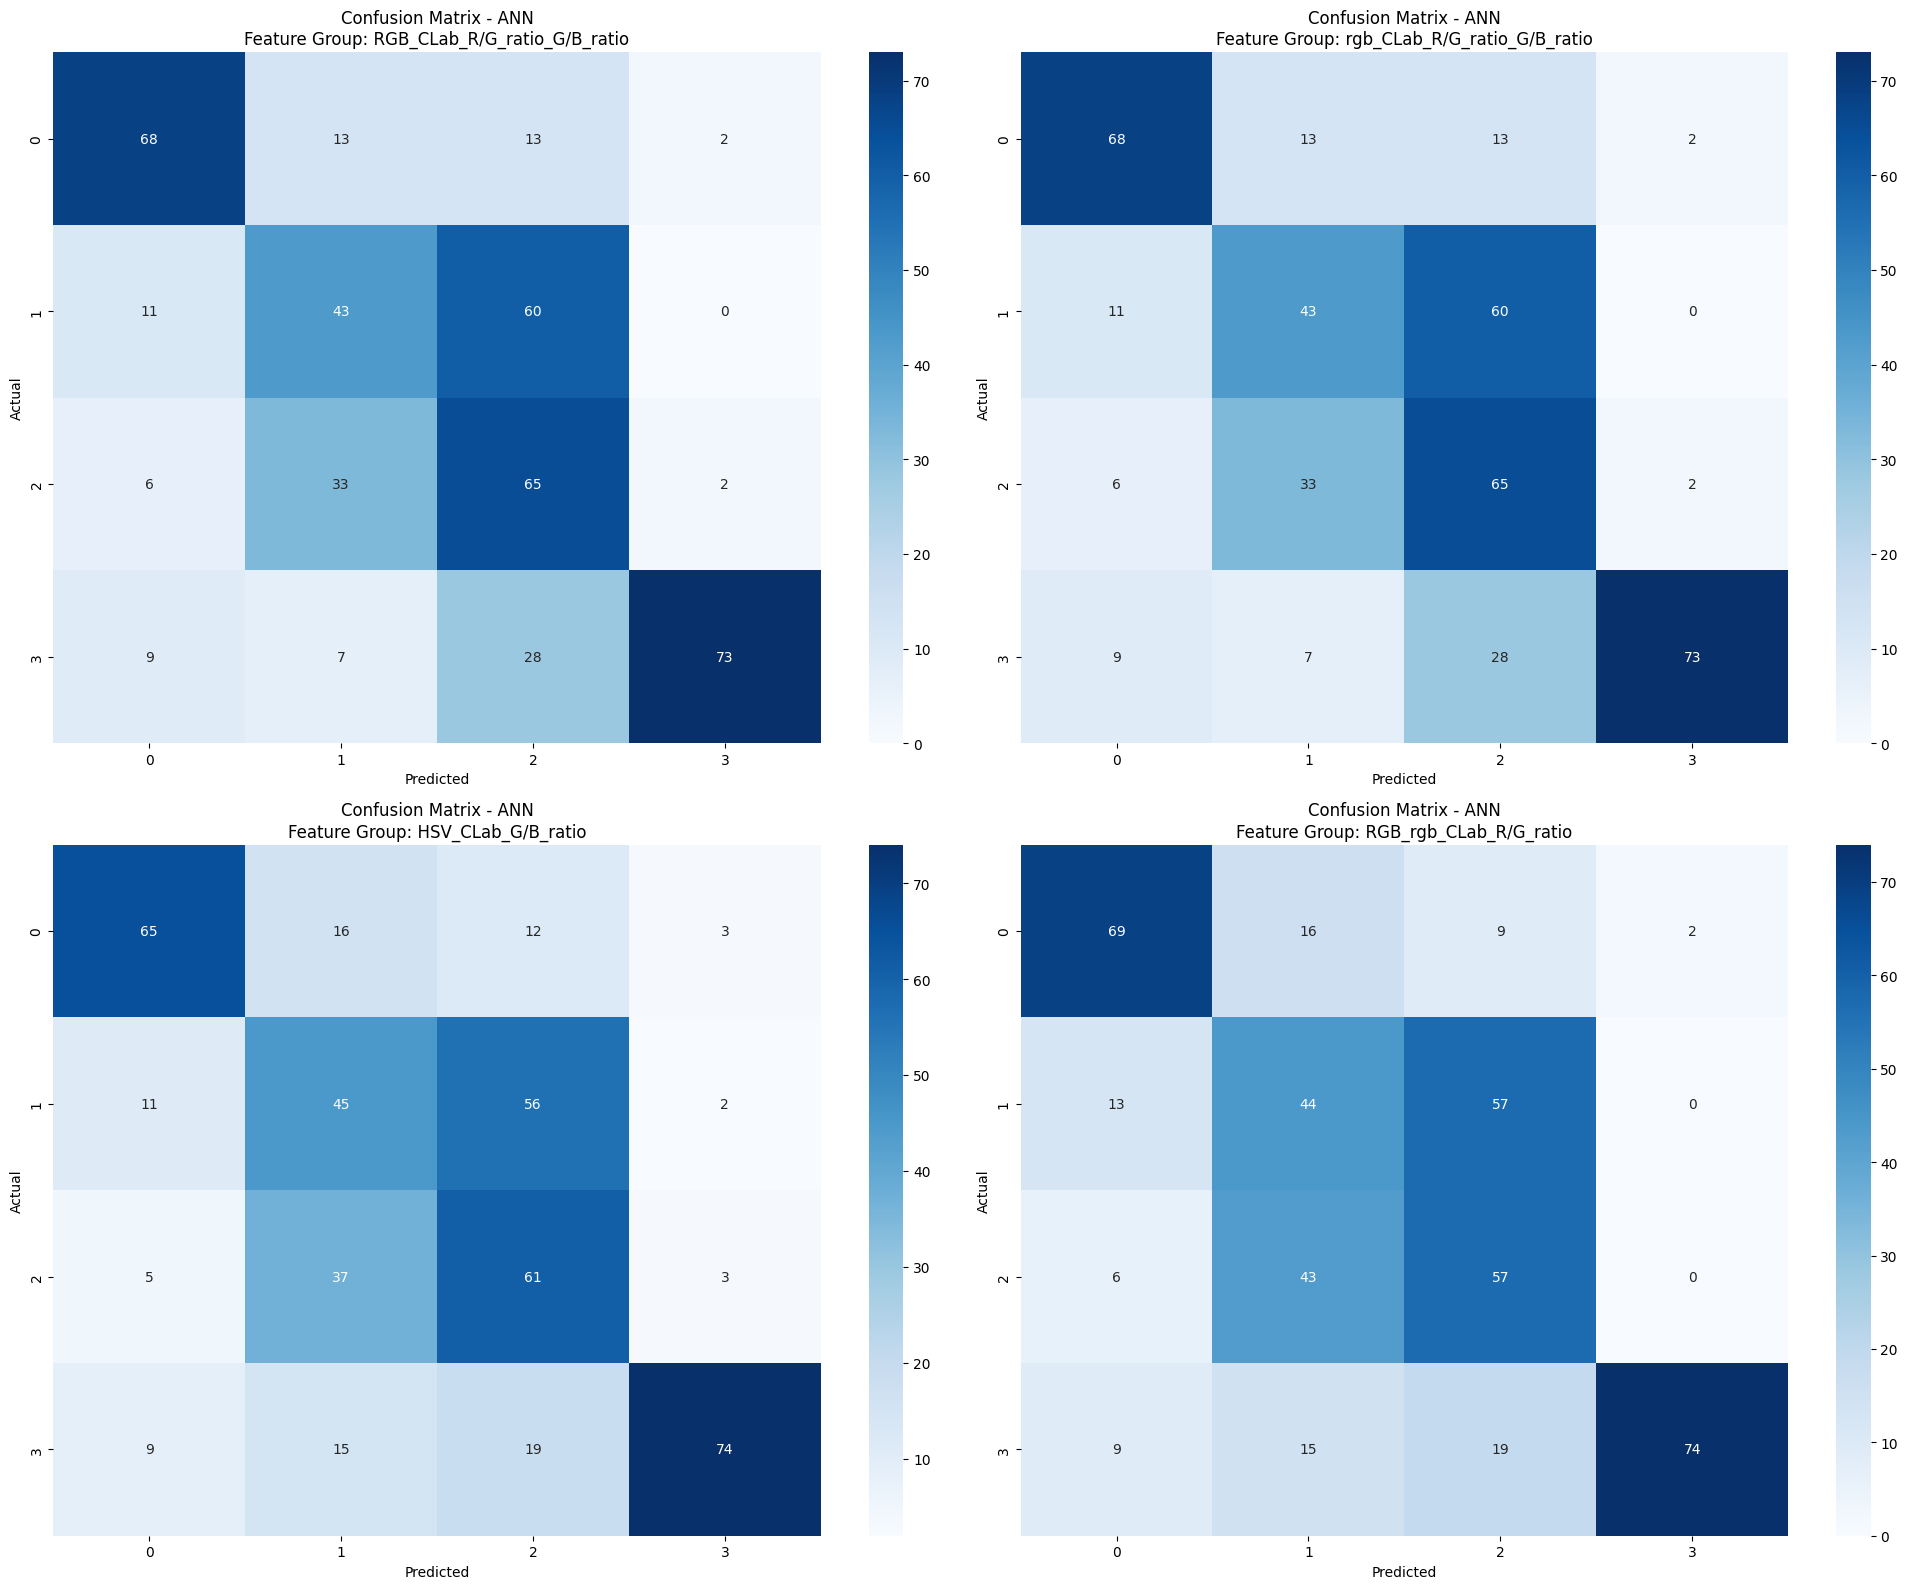

In [46]:
visualize_top_feature_combinations(
    data_prep=data_prep,
    results=results_ann,
    metrics_df=metrics_df_ann,
    model_name='ANN',
)

### **Confusion Matrix Adaboost Decision Tree**

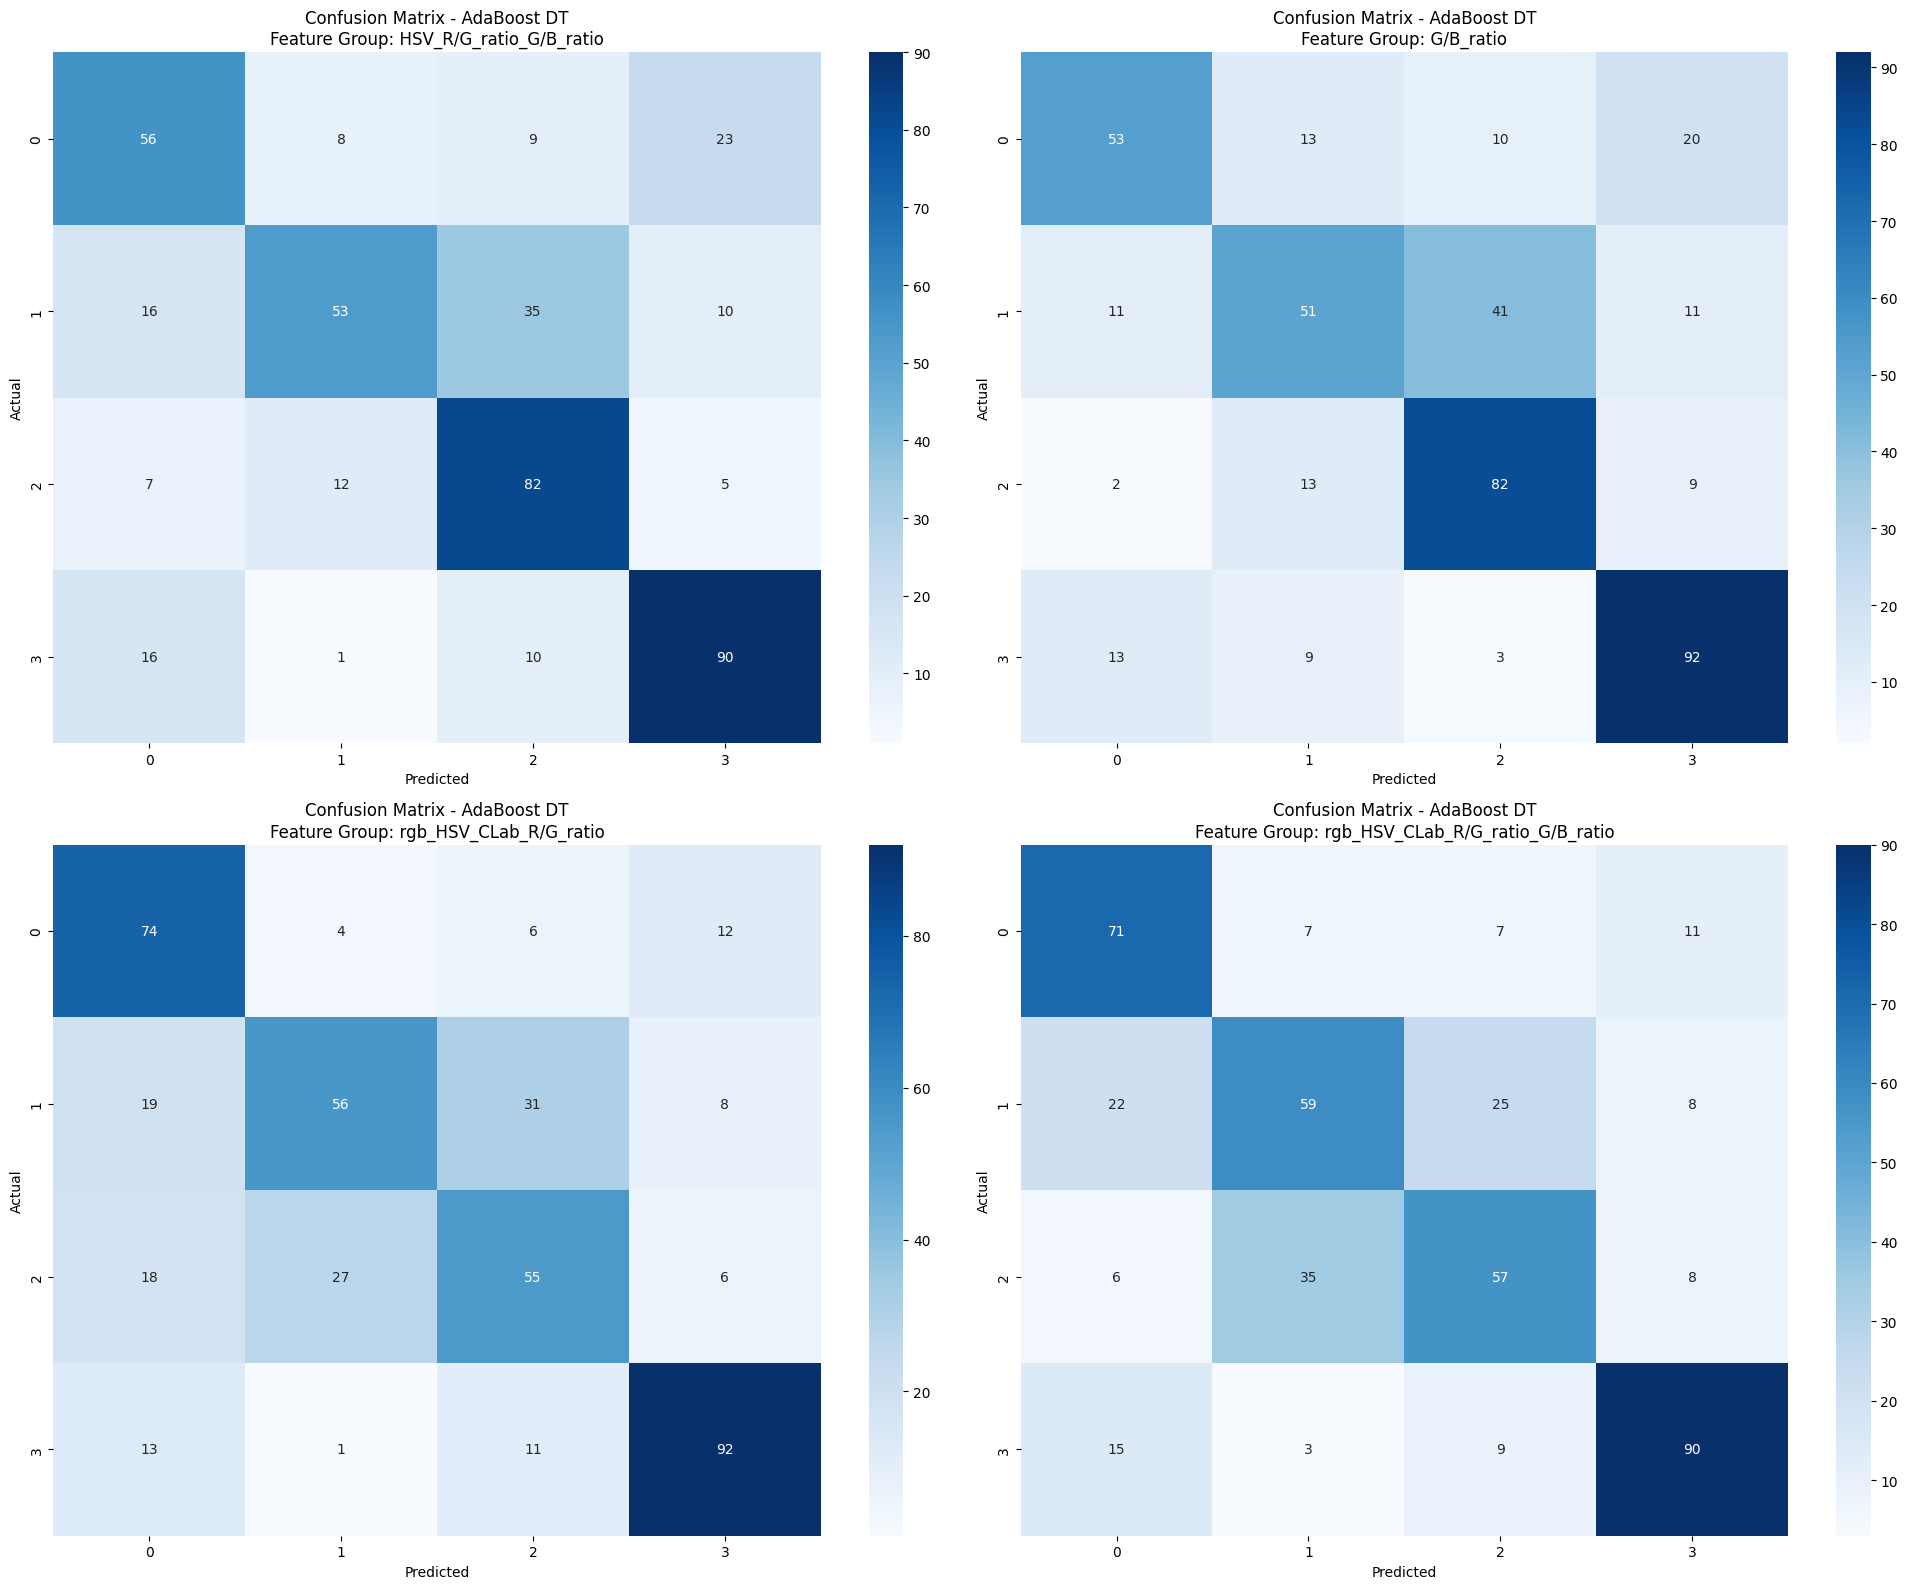

In [47]:
visualize_top_feature_combinations(
    data_prep=data_prep,
    results=result_adaboost_dt,
    metrics_df=metrics_df_adaboost_dt,
    model_name='AdaBoost DT',
)

### **Confusion Matrix Adaboost SVM Kernel RBF**

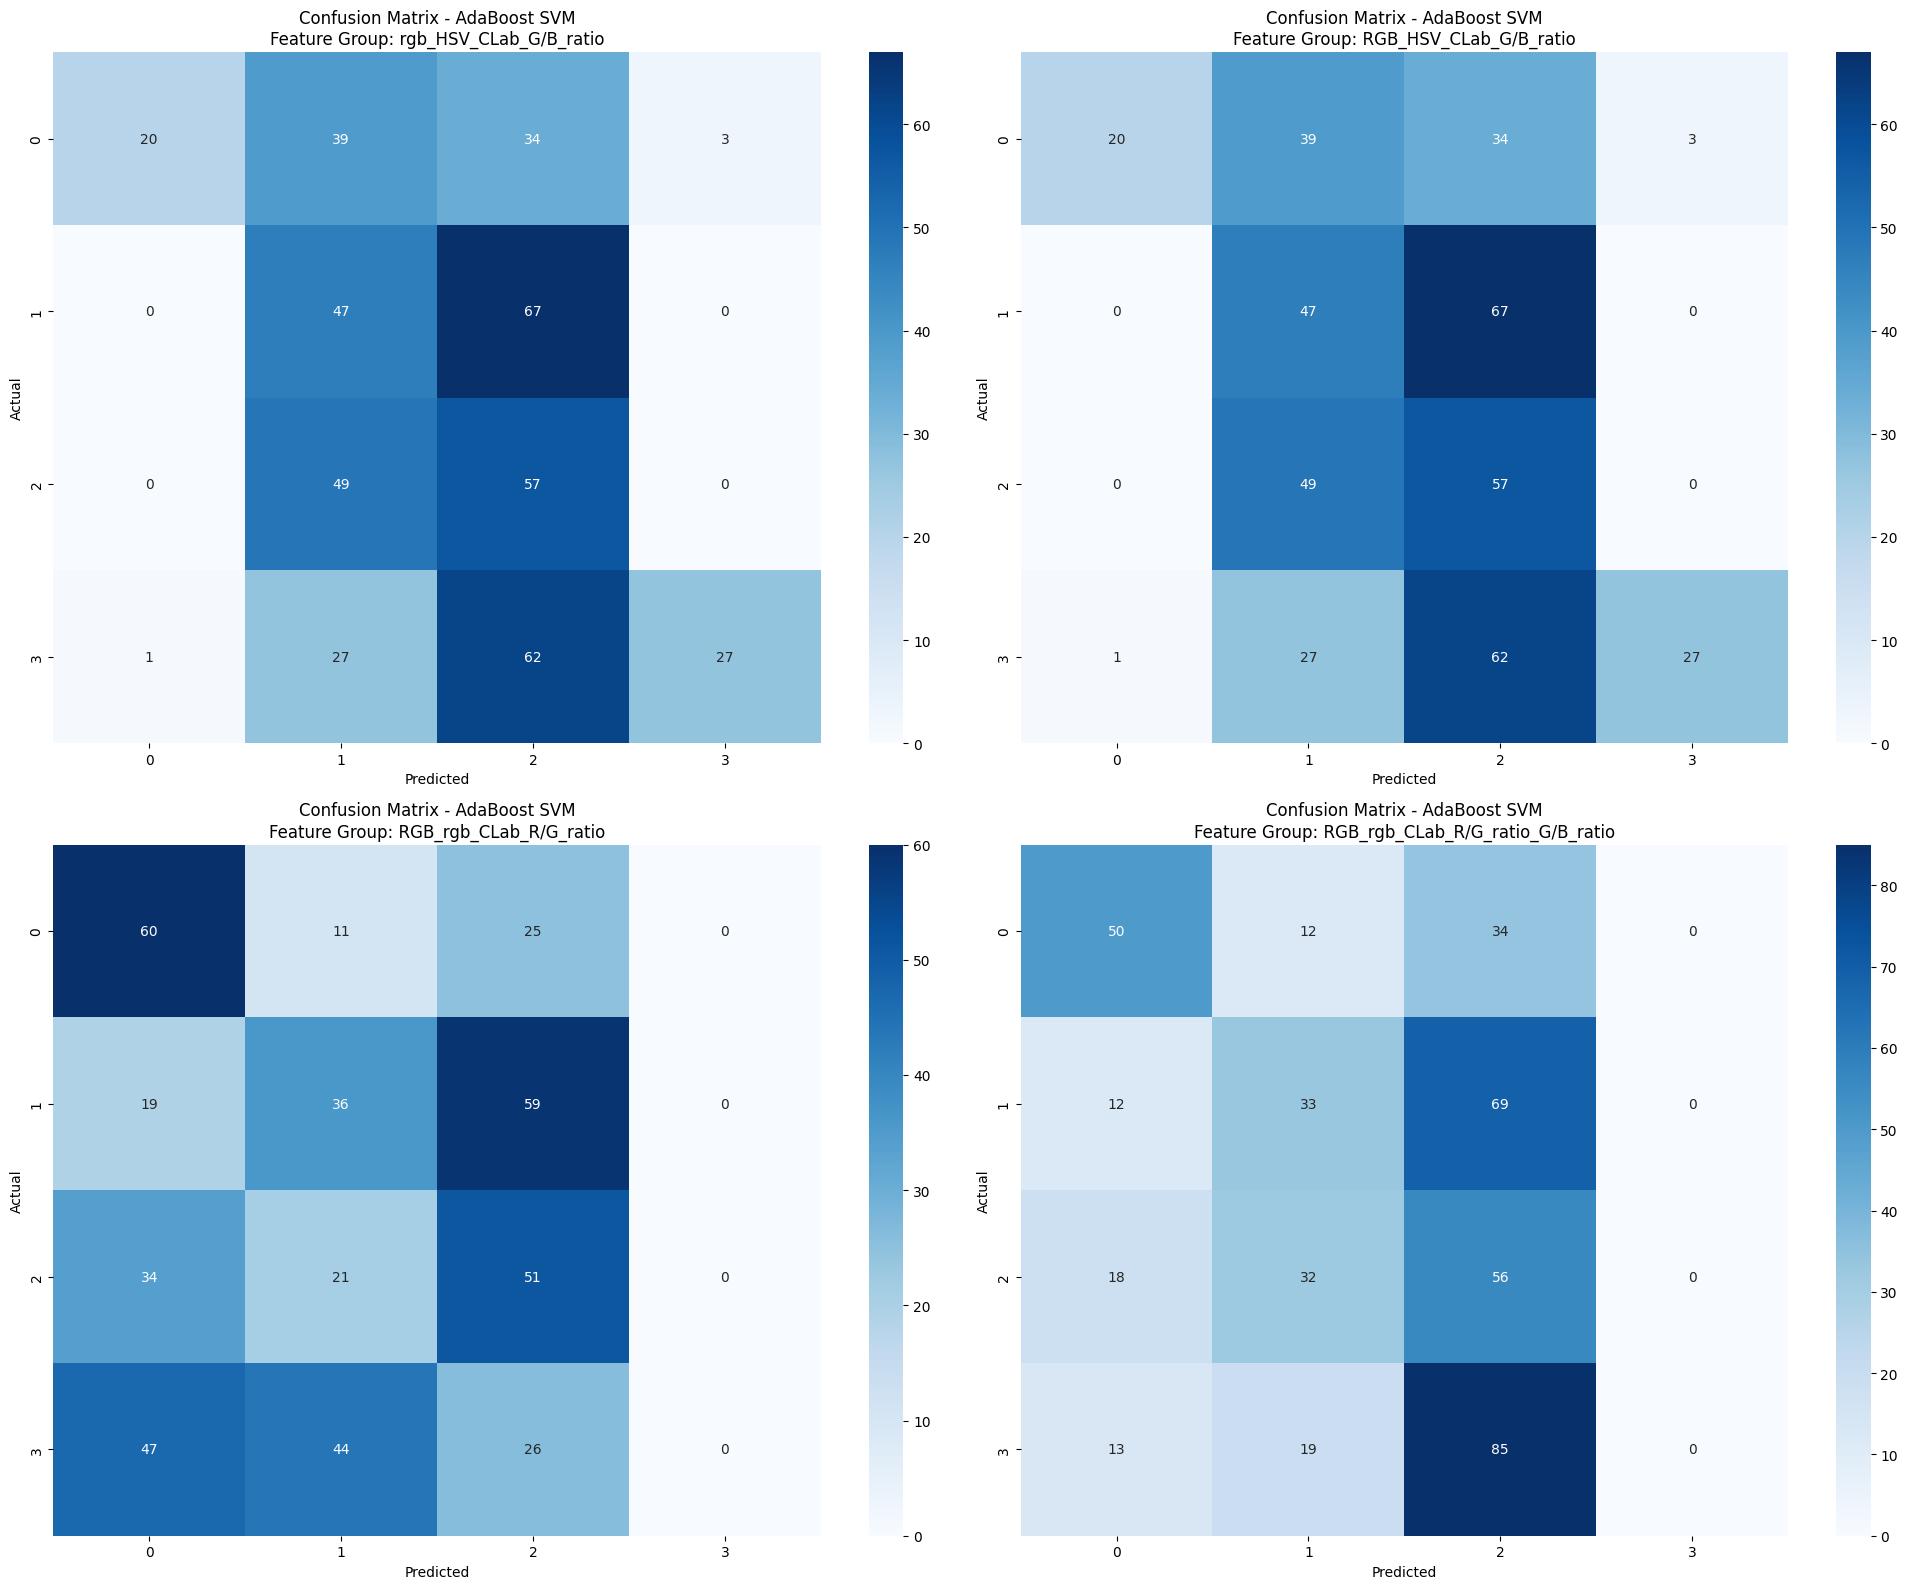

In [48]:
visualize_top_feature_combinations(
    data_prep=data_prep,
    results=result_aboost_svm,
    metrics_df=metrics_df_adaboost_svm,
    model_name='AdaBoost SVM',
)

### **Confusion Matrix Bagging SVM Kernel RBF**

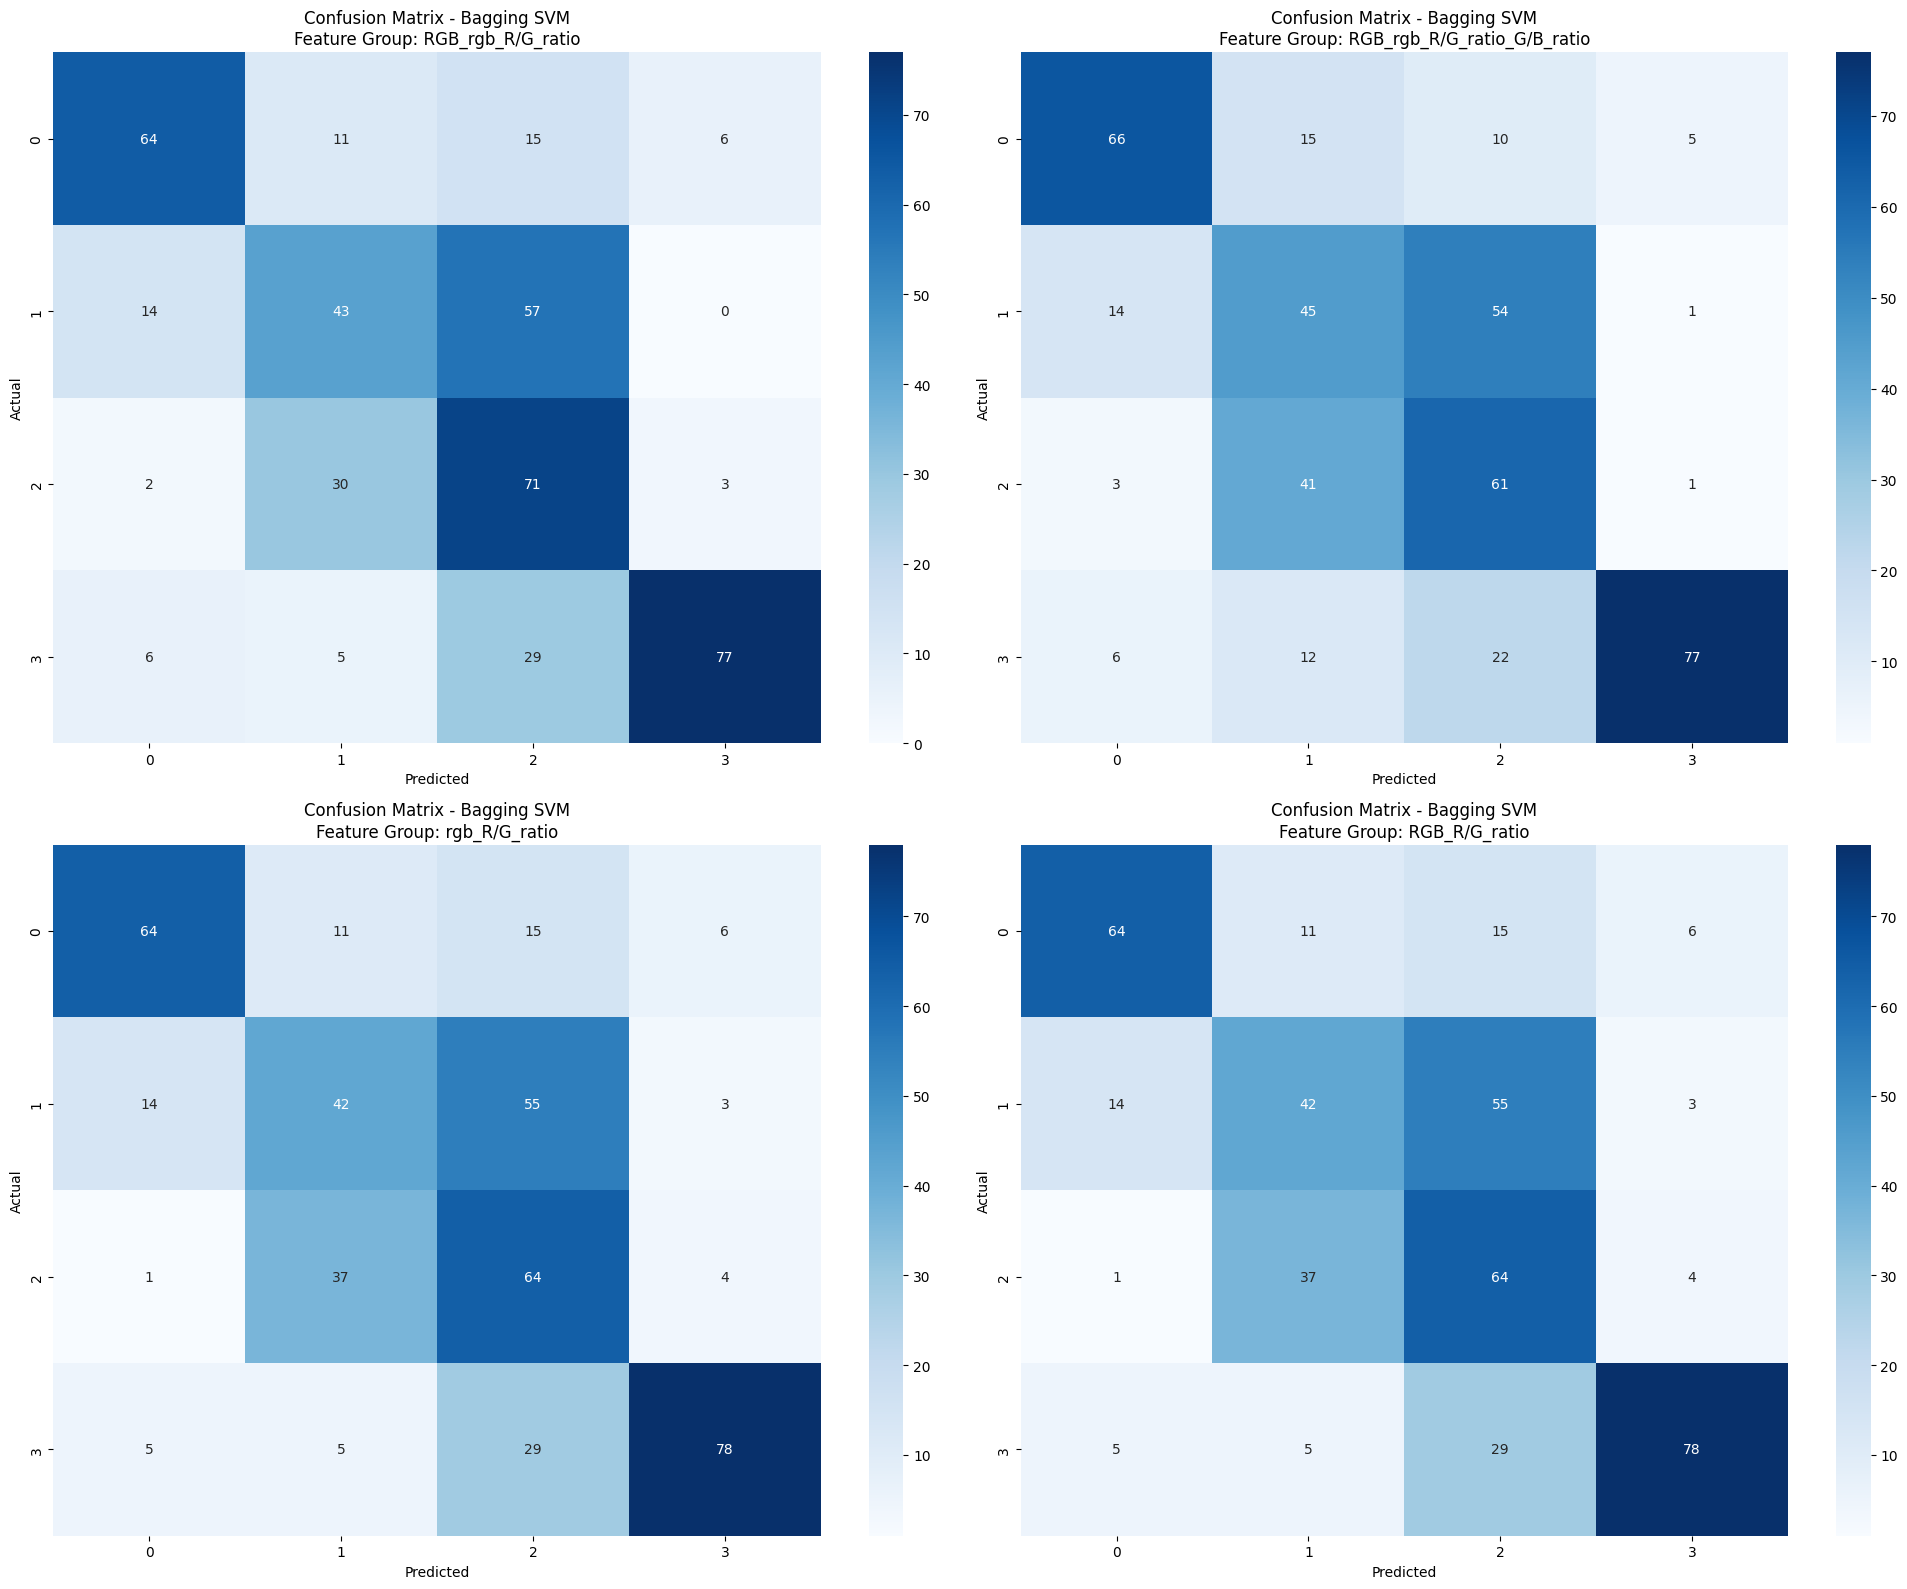

In [49]:
visualize_top_feature_combinations(
    data_prep=data_prep,
    results=result_bagging_svm,
    metrics_df=metrics_df_bagging_svm,
    model_name='Bagging SVM',
)

## **ROC-AUC**

In [50]:
def plot_roc_per_model(results, feature_groups, model_name, metrics_df, top_n=4):
    # Membuat dictionary model_probs di dalam fungsi
    model_probs = {group_name: results[group_name]['test_results']['y_prob'] for group_name in results}

    # Filter 6 grup fitur terbaik untuk model tertentu berdasarkan akurasi
    top_groups_df = metrics_df[metrics_df['Model'] == model_name].nlargest(top_n, 'Test Accuracy')
    top_groups = top_groups_df['Feature Group'].tolist()

    # Inisialisasi list untuk menampung hasil plot
    default_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

    # Binerisasi label uji berdasarkan grup fitur
    n_classes = len(np.unique(feature_groups[next(iter(feature_groups))]['y_test']))  # Tentukan jumlah kelas dari grup pertama
    classes = np.unique(feature_groups[next(iter(feature_groups))]['y_test'])
    y_test_bin = label_binarize(feature_groups[next(iter(feature_groups))]['y_test'], classes=classes)

    # Buat figure untuk menampilkan plot ROC dengan 2 baris dan 3 kolom
    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    axes = axes.flatten()  # Flatten agar mudah diiterasi

    # Iterasi untuk setiap kelas
    for i, class_idx in enumerate(range(n_classes)):
        ax = axes[i]  # Ambil subplot yang sesuai untuk kelas saat ini
        # Iterasi untuk setiap grup fitur (dataset)
        for j, group_name in enumerate(top_groups):
            y_prob = model_probs[group_name]  # Ambil probabilitas prediksi dari model

            fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_prob[:, class_idx])
            roc_auc = auc(fpr, tpr)

            # Plot kurva ROC untuk grup fitur saat ini
            ax.plot(fpr, tpr, label=f'{group_name} (AUC = {roc_auc:.2f})', color=default_colors[j % len(default_colors)])

        # Detail plot
        ax.set_title(f'Class {class_idx}')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        ax.grid()

    plt.tight_layout()
    plt.show()

### **ROC-AUC ANN**

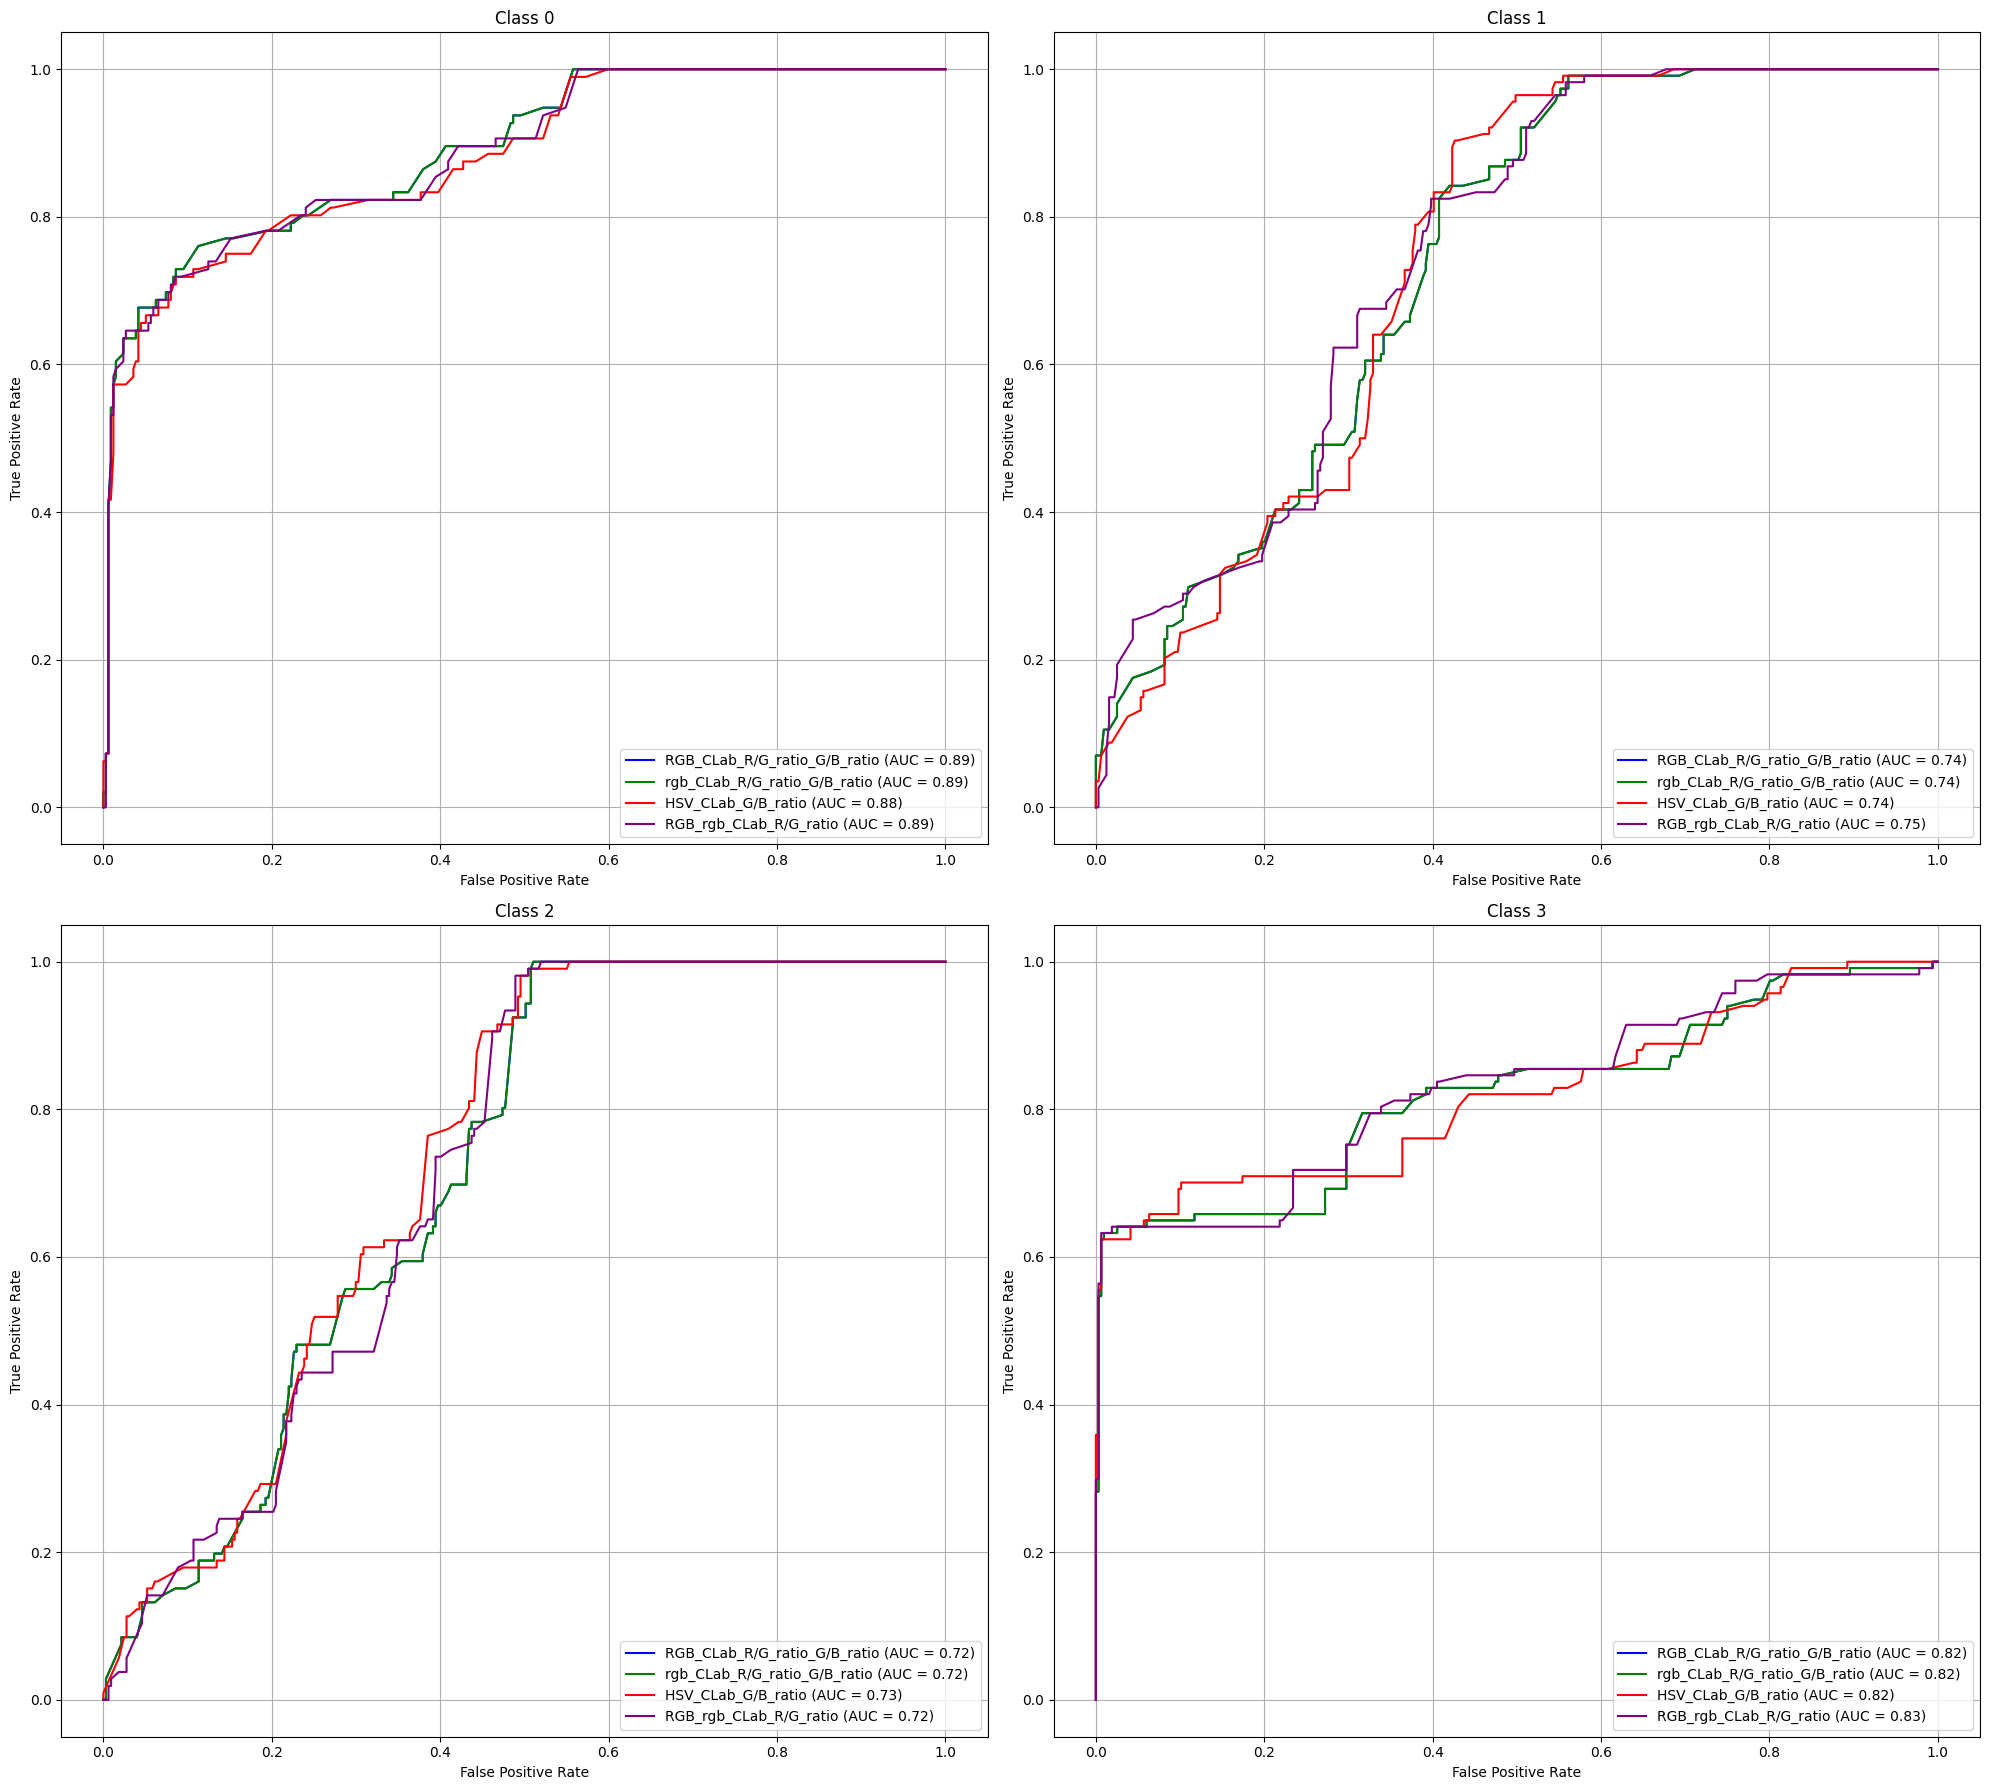

In [51]:
plot_roc_per_model(
    results=results_ann,
    feature_groups=data_prep,
    model_name='ANN',
    metrics_df=metrics_df_ann,
)

### **ROC-AUC Adaboost Decision Tree**

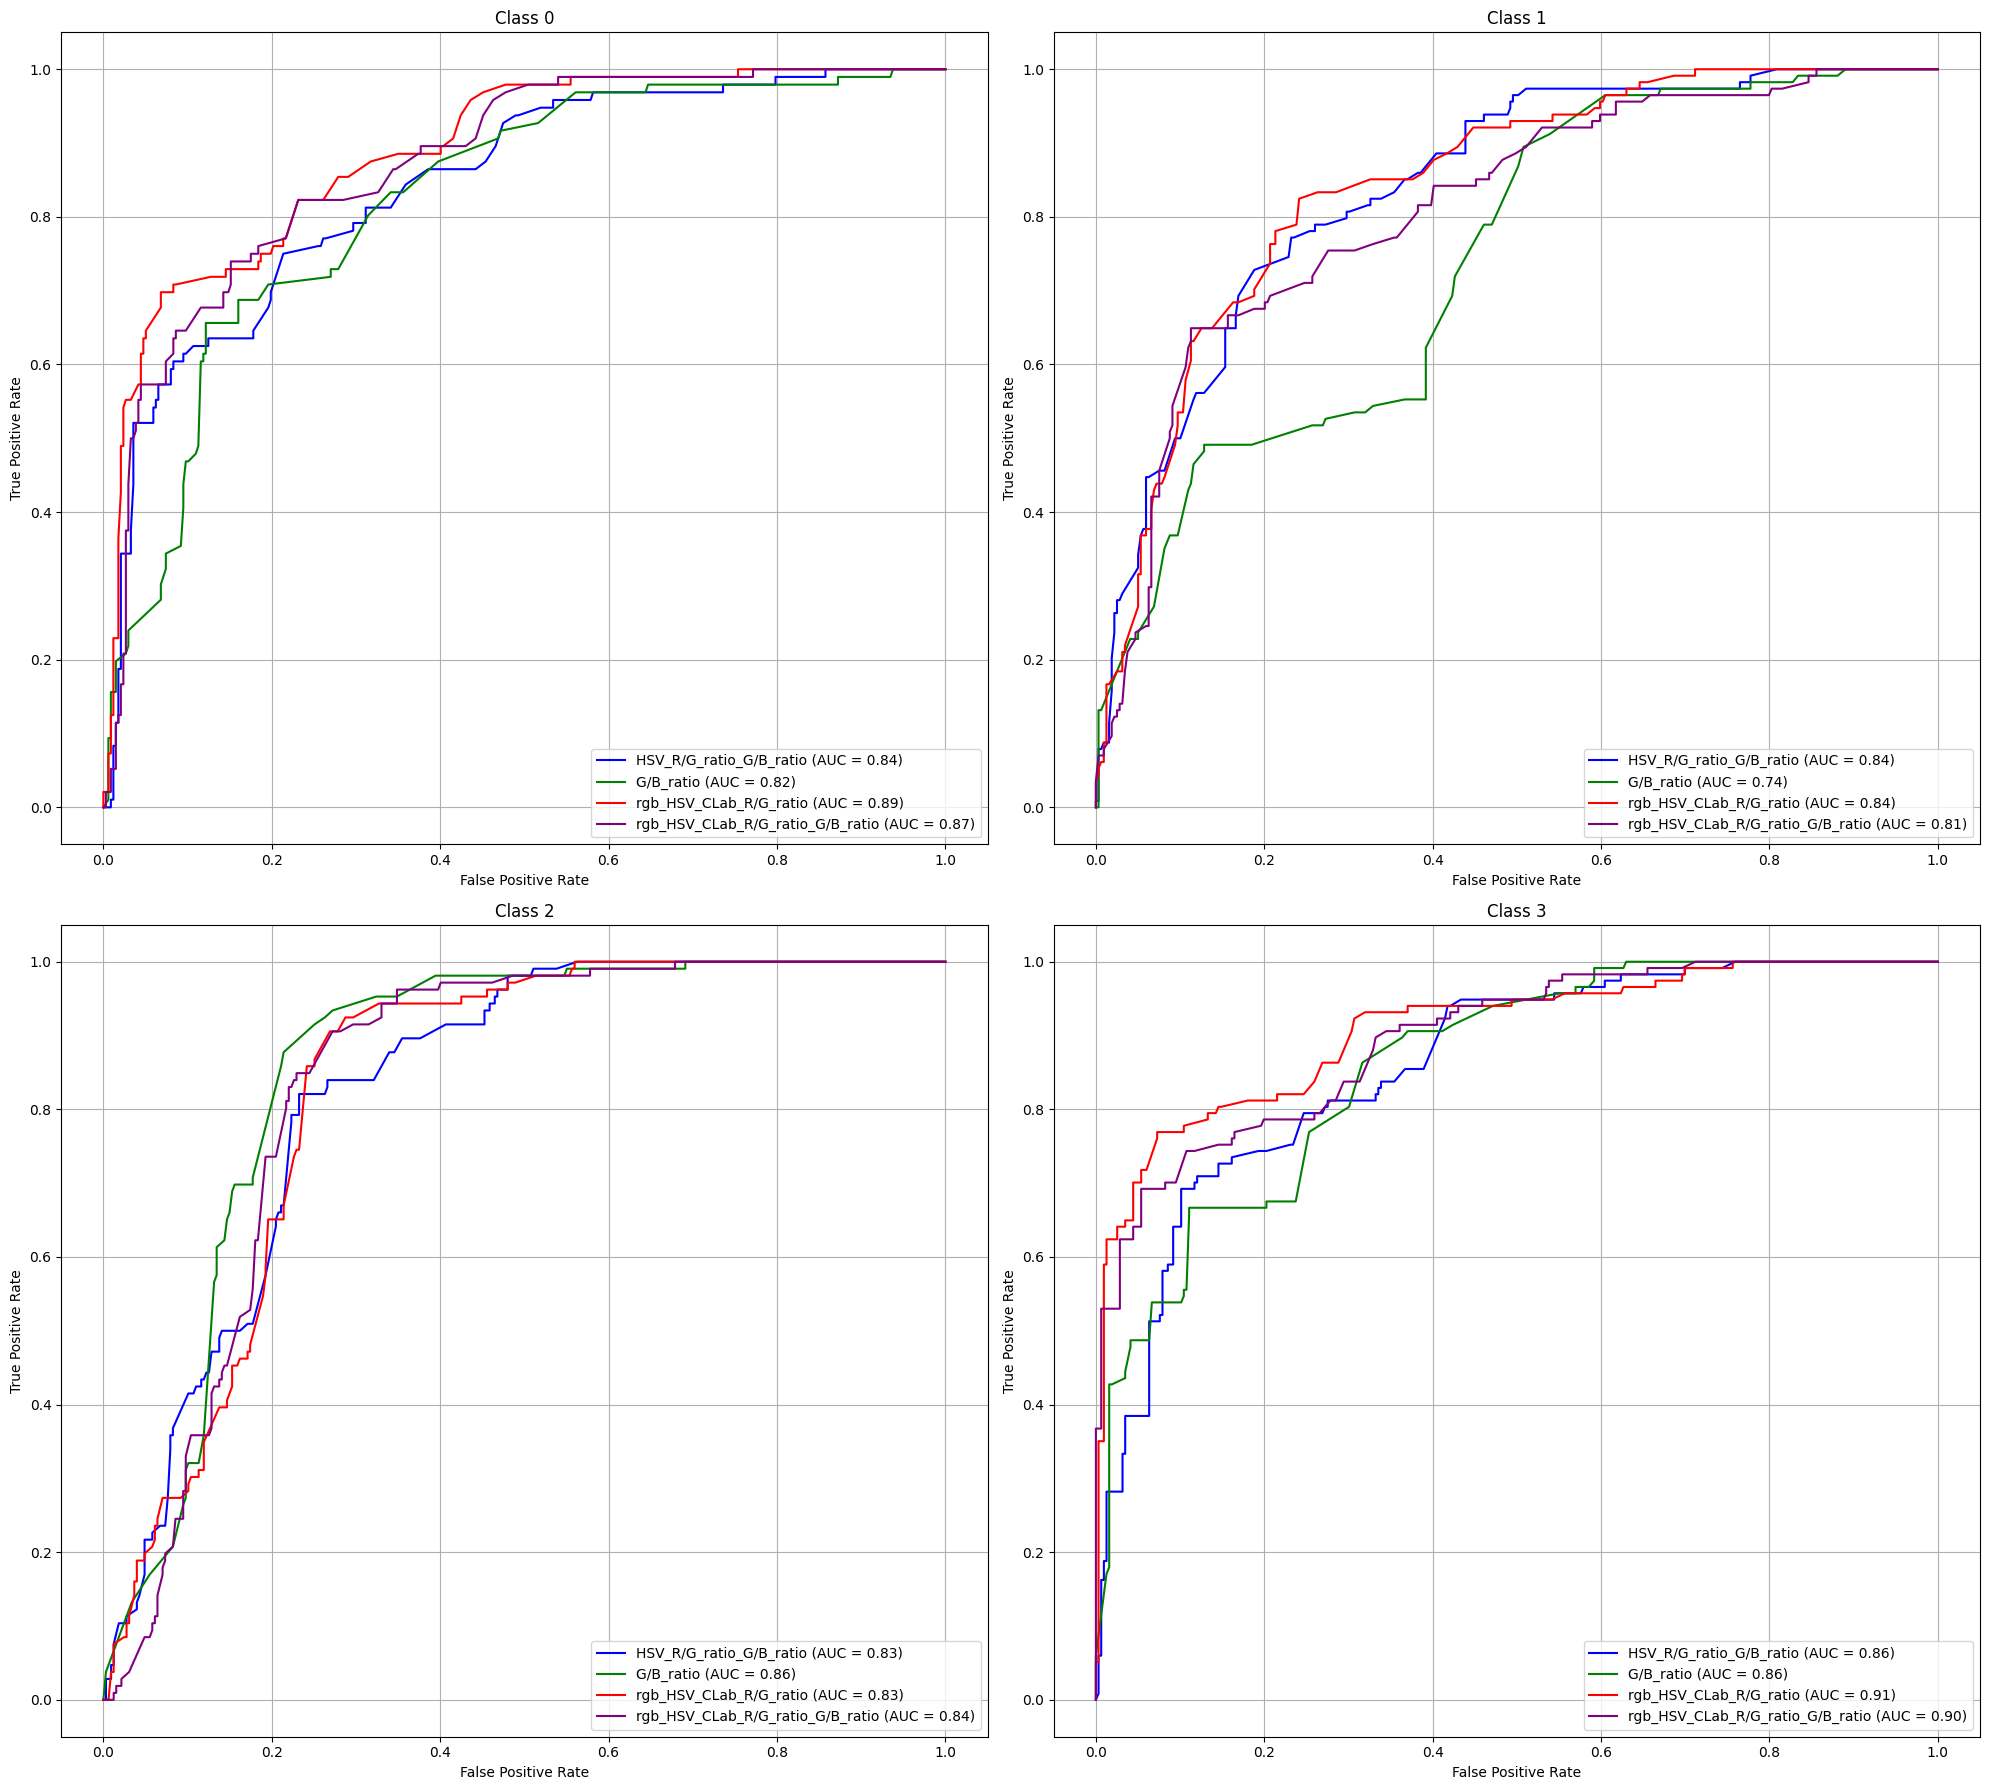

In [52]:
plot_roc_per_model(
    results=result_adaboost_dt,
    feature_groups=data_prep,
    model_name='AdaBoost DT',
    metrics_df=metrics_df_adaboost_dt,
)

### **ROC-AUC Adaboost SVM Kernel RBF**

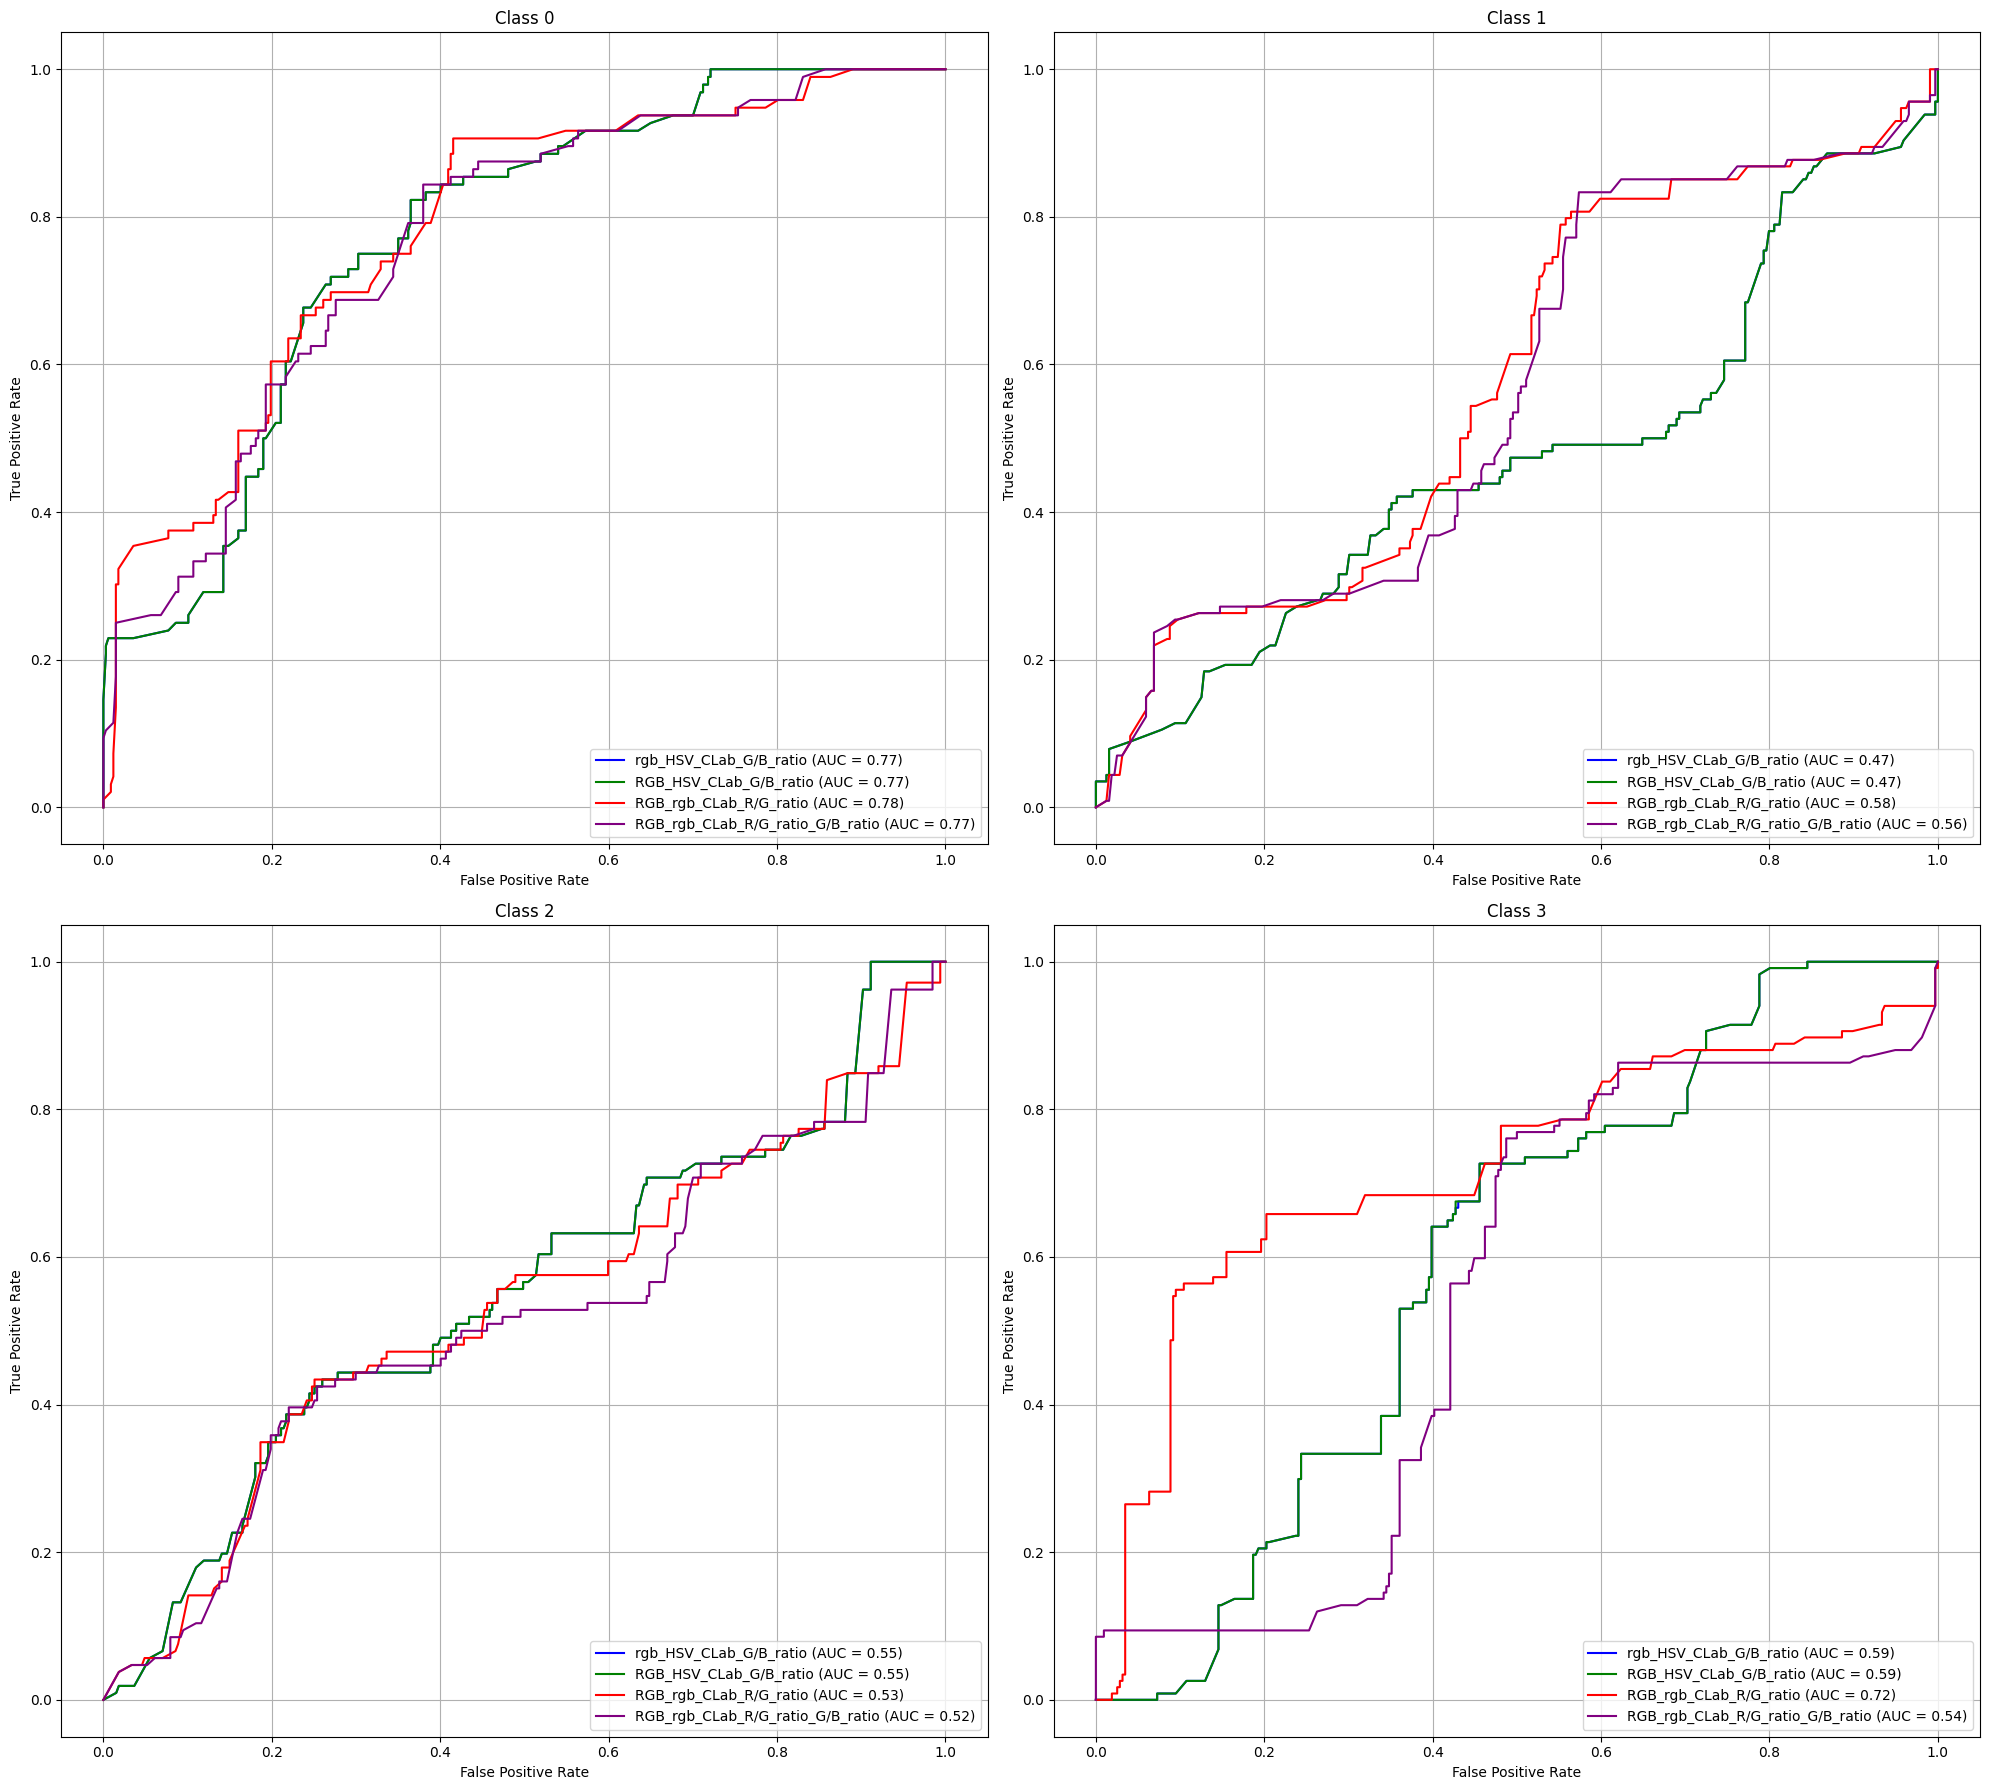

In [53]:
plot_roc_per_model(
    results=result_aboost_svm,
    feature_groups=data_prep,
    model_name='AdaBoost SVM',
    metrics_df=metrics_df_adaboost_svm,
)

### **ROC-AUC Bagging SVM Kernel RBF**

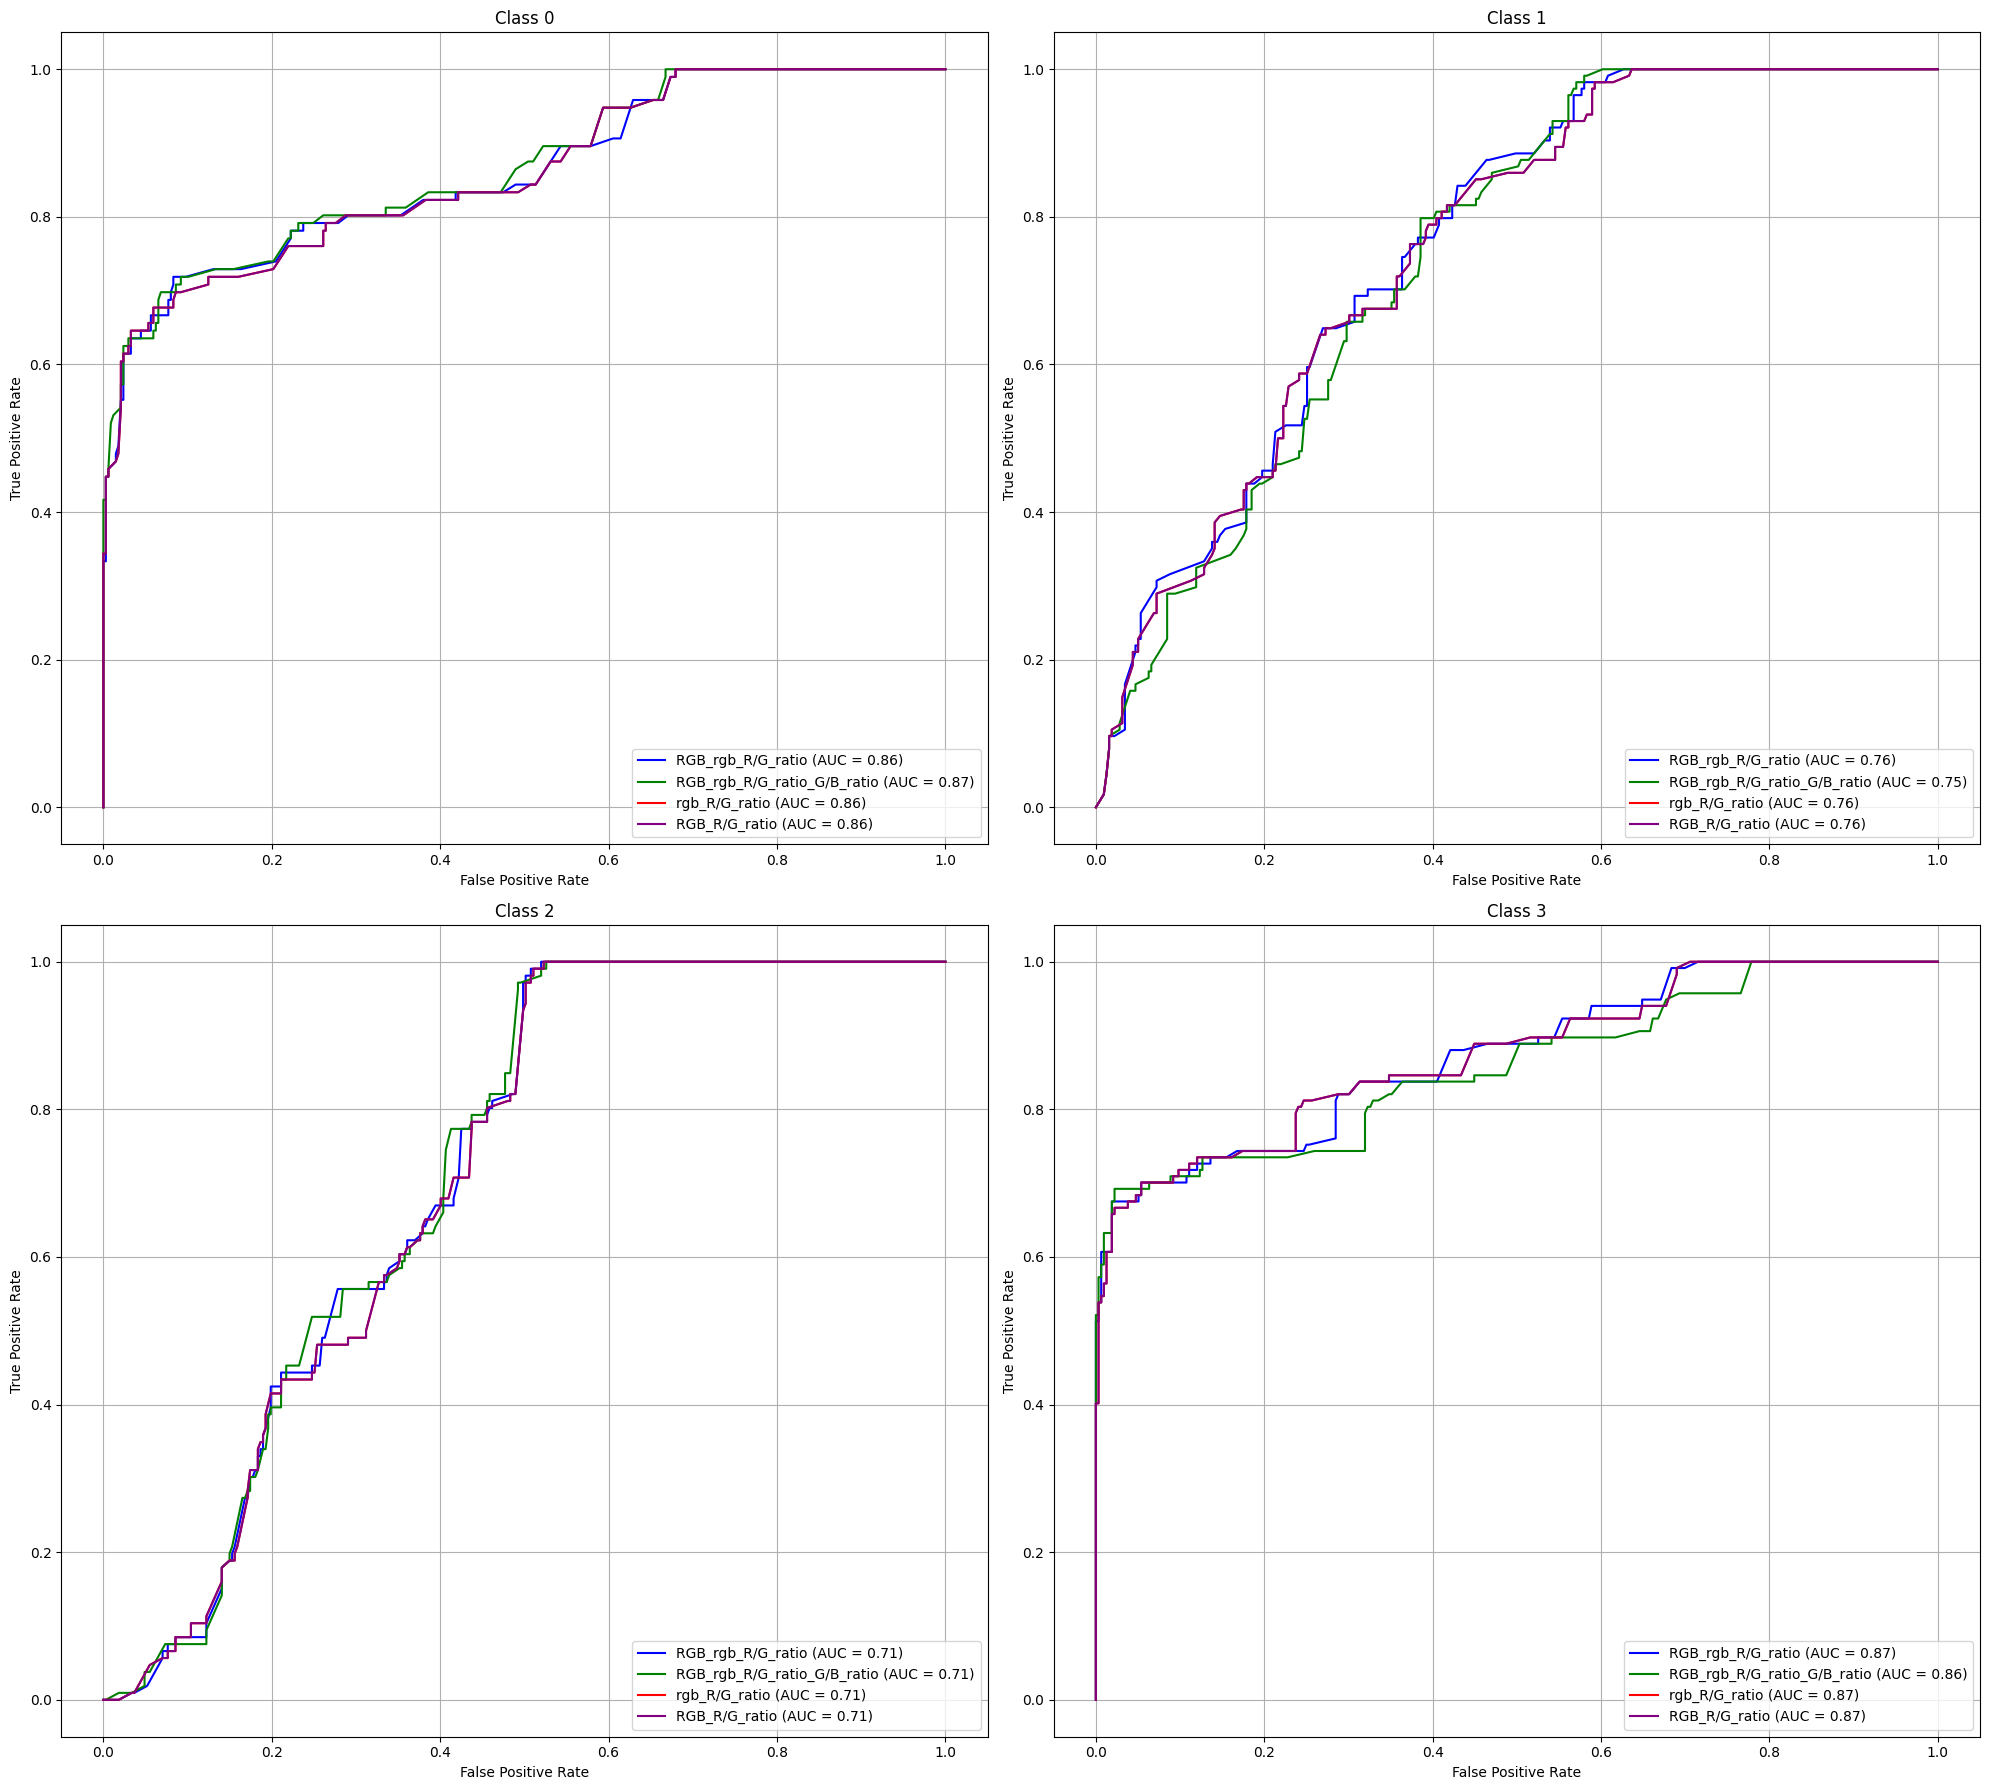

In [54]:
plot_roc_per_model(
    results=result_bagging_svm,
    feature_groups=data_prep,
    model_name='Bagging SVM',
    metrics_df=metrics_df_bagging_svm
)

## **Perbandingan Metrik Test**

In [55]:
def visualize_model_feature_metrics(metrics_dict, model_names, top_n=4):
    # Helper function untuk mendeteksi kolom yang benar
    def get_metric_column(metrics_df, metric_name):
        """Mencari kolom metrik yang sesuai (Test atau Val)."""
        if f"Test {metric_name}" in metrics_df.columns:
            return f"Test {metric_name}"
        elif f"Val {metric_name}" in metrics_df.columns:
            return f"Val {metric_name}"
        else:
            raise KeyError(f"Kolom untuk '{metric_name}' tidak ditemukan dalam DataFrame.")
    
    # Setup grid layout untuk subplot
    n_models = len(model_names)
    fig, axes = plt.subplots(n_models, top_n, figsize=(20, n_models * 4))
    axes = axes if n_models > 1 else [axes]  # Pastikan axes selalu berupa array

    # Loop setiap model
    for model_idx, model_name in enumerate(model_names):
        # Ambil metrics_df spesifik untuk model
        metrics_df = metrics_dict.get(model_name)
        if metrics_df is None:
            raise ValueError(f"Metrics DataFrame untuk model '{model_name}' tidak ditemukan.")

        # Filter kombinasi fitur terbaik untuk model
        top_features_df = metrics_df.nlargest(top_n, get_metric_column(metrics_df, "Accuracy"))
        top_feature_groups = top_features_df['Feature Group'].tolist()

        # Loop setiap kombinasi fitur
        for feature_idx, feature_group in enumerate(top_feature_groups):
            ax = axes[model_idx][feature_idx] if n_models > 1 else axes[feature_idx]

            # Ambil metrik untuk kombinasi fitur ini
            metrics = top_features_df[top_features_df['Feature Group'] == feature_group].iloc[0]
            values = [
                metrics[get_metric_column(top_features_df, "Accuracy")],
                metrics[get_metric_column(top_features_df, "Precision")],
                metrics[get_metric_column(top_features_df, "Recall")],
                metrics[get_metric_column(top_features_df, "F1-Score")]
            ]
            labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

            # Plot barchart
            bars = sns.barplot(x=labels, y=values, ax=ax, palette='tab10', hue=labels)
            ax.set_title(f"{model_name} - {feature_group}")
            ax.set_ylim(0, 1)
            ax.set_ylabel('Score')
            ax.set_xlabel('Metrics')
            ax.grid(axis='y')

            # Tambahkan nilai persentase di atas bar
            for bar, value in zip(bars.patches, values):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height(),
                    f"{value:.2%}",
                    ha='center',
                    va='bottom',
                    fontsize=10
                )
    
    # Atur tata letak
    plt.tight_layout()
    plt.show()

In [56]:
metrics_dict = {
    'ANN': metrics_df_ann,
    'AdaBoost DT': metrics_df_adaboost_dt,
    'AdaBoost SVM': metrics_df_adaboost_svm,
    'Bagging SVM': metrics_df_bagging_svm
}

model_names = ['ANN', 'AdaBoost DT', 'AdaBoost SVM', 'Bagging SVM']

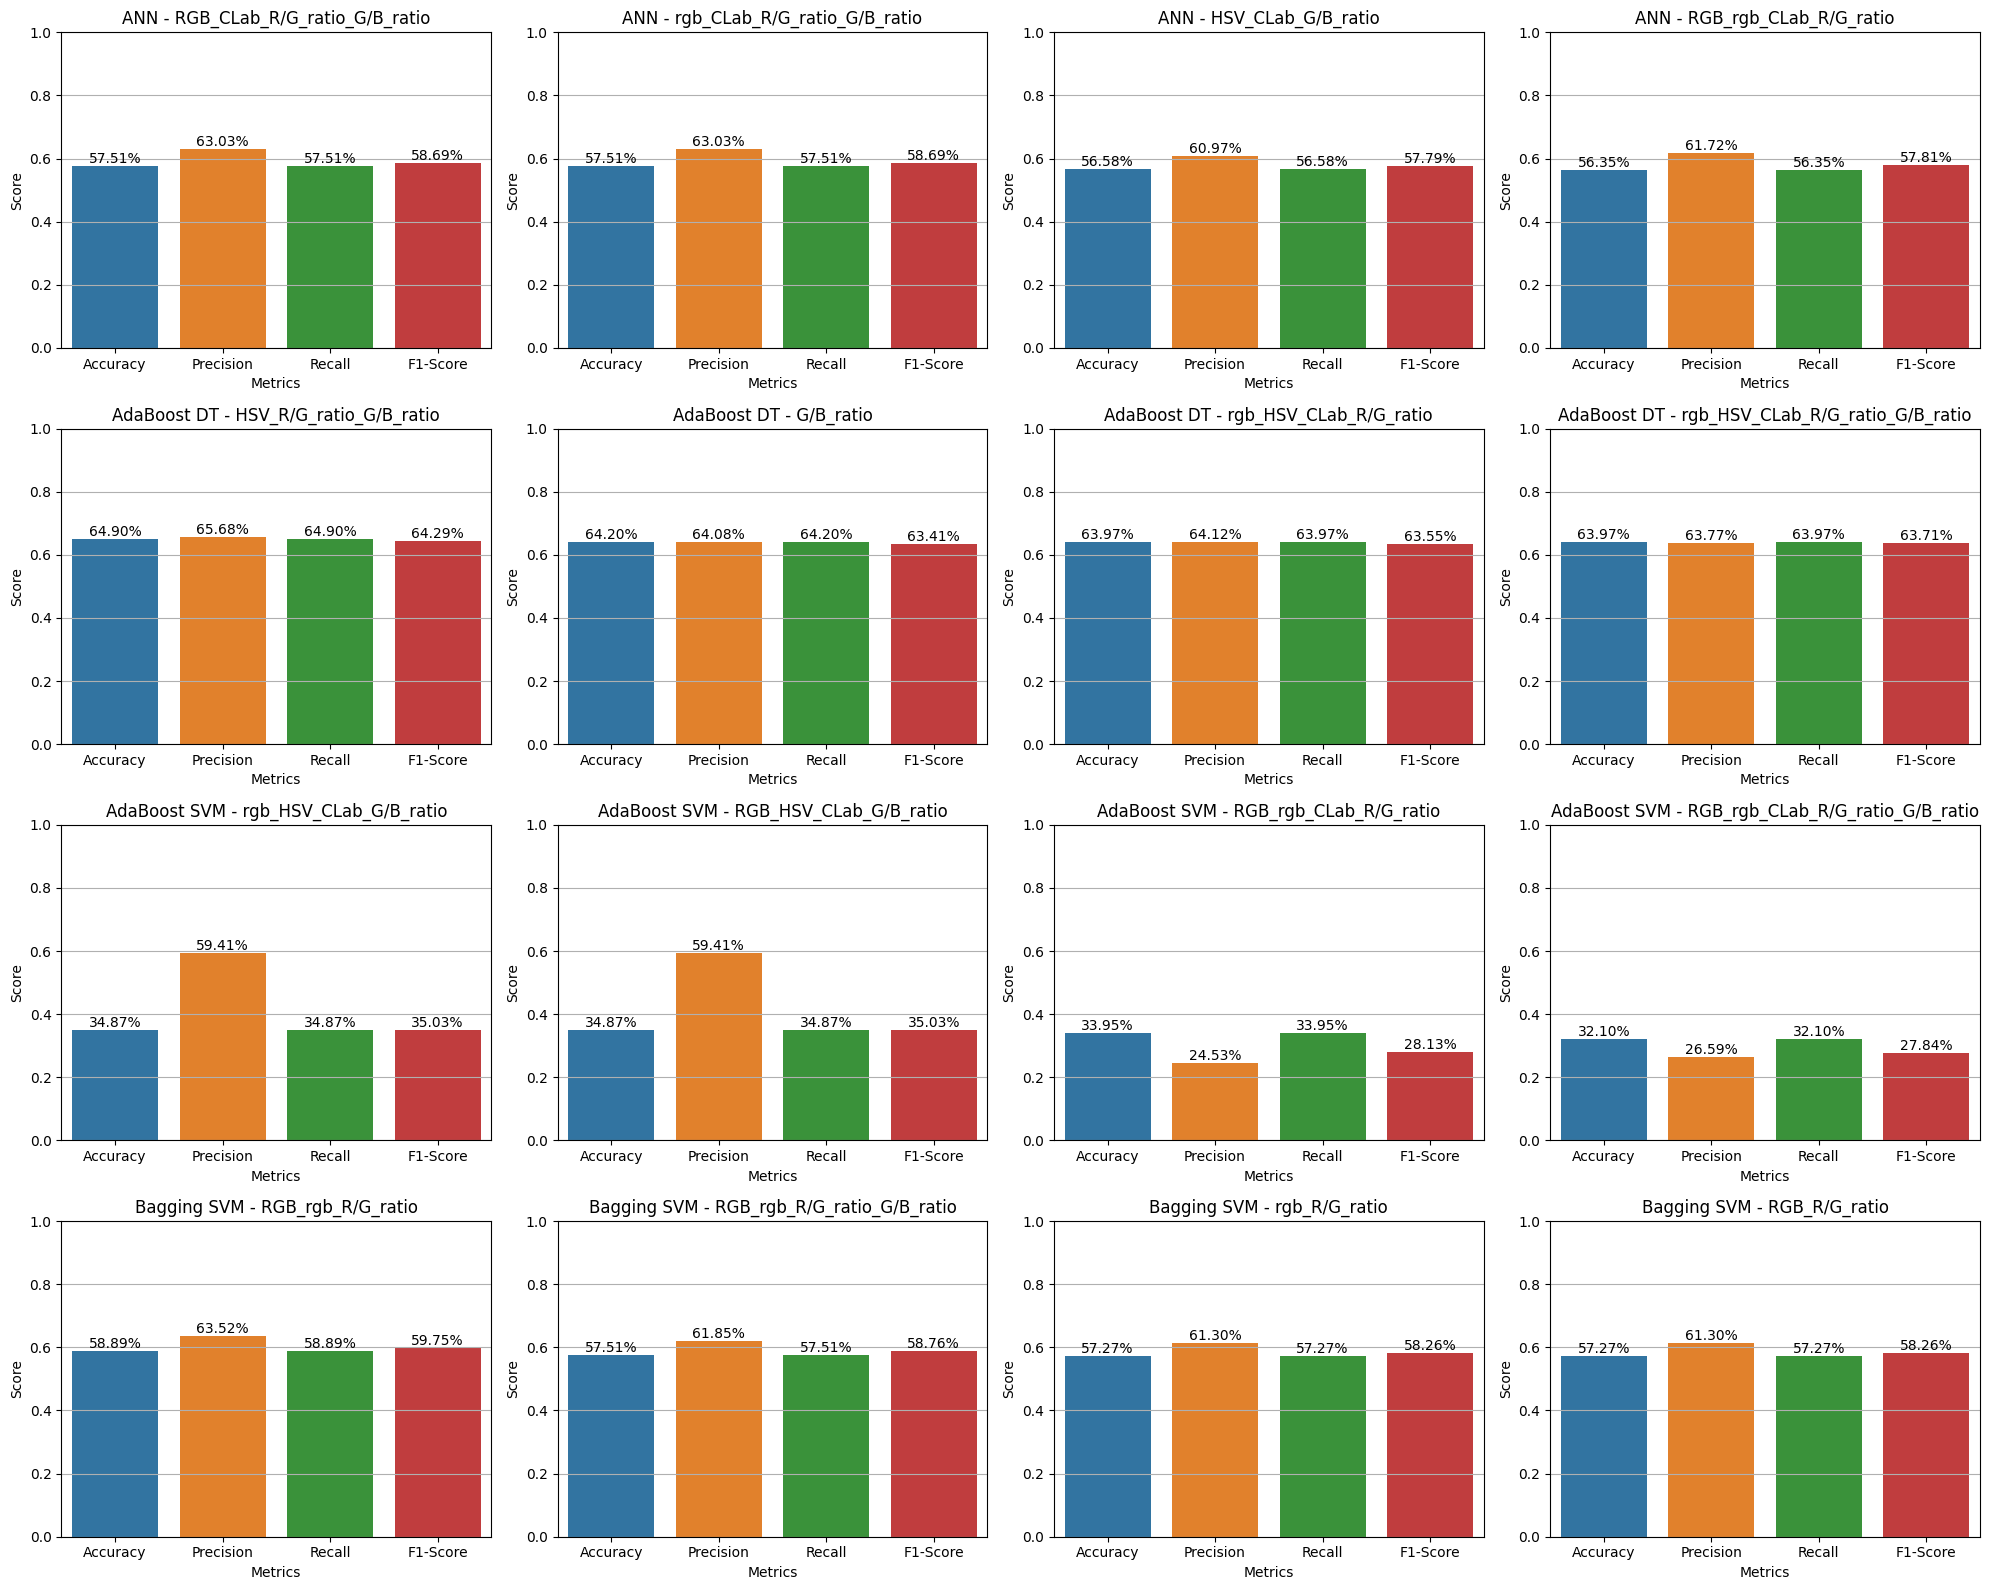

In [57]:
visualize_model_feature_metrics(
    metrics_dict=metrics_dict,
    model_names=model_names,
)

# **Seleksi Fitur**

## **Import Library**

In [122]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## **Membuat Dictionary**

In [123]:
def prepare_data(df):

    # Memilih kolom yang akan digunakan sebagai fitur
    # Mengabaikan kolom 'Pengambilan' dan 'IR_Intensity (%)'
    feature_columns = [col for col in df.columns if col not in ['Pengambilan', 'IR_Intensity (%)', 'Perlakuan']]
    
    # Memilih fitur dan target
    X = df[feature_columns]
    y = df['Perlakuan']
    
    # Membagi data menjadi set pelatihan dan pengujian
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Preprocessing untuk ANN: MinMaxScaler
    scaler_ann = MinMaxScaler()
    X_train_ann = scaler_ann.fit_transform(X_train)
    X_test_ann = scaler_ann.transform(X_test)
    
    # Preprocessing untuk AdaBoost SVM: StandardScaler
    scaler_svm = StandardScaler()
    X_train_svm = scaler_svm.fit_transform(X_train)
    X_test_svm = scaler_svm.transform(X_test)
    
    # Preprocessing untuk AdaBoost DT: Tanpa scaling
    X_train_dt = X_train.values
    X_test_dt = X_test.values
    
    print(f"Jumlah fitur yang digunakan: {len(feature_columns)}")
    print(f"Fitur yang digunakan: {feature_columns}")
    print(f"Jumlah data training: {X_train.shape[0]}")
    print(f"Jumlah data testing: {X_test.shape[0]}")
    
    return {
        'X_train_ann': X_train_ann, 'X_test_ann': X_test_ann,
        'X_train_svm': X_train_svm, 'X_test_svm': X_test_svm,
        'X_train_dt': X_train_dt, 'X_test_dt': X_test_dt,
        'y_train': y_train, 'y_test': y_test,
        'feature_columns': feature_columns
    }

In [124]:
# Menggunakan fungsi prepare_data untuk menyiapkan data
data_prep_selection = prepare_data(df_lab)
data_prep_selection

Jumlah fitur yang digunakan: 14
Fitur yang digunakan: ['R', 'G', 'B', 'r', 'g', 'b', 'R_G_ratio', 'G_B_ratio', 'H', 'S', 'V', 'cL', 'ca', 'cb']
Jumlah data training: 1008
Jumlah data testing: 433


{'X_train_ann': array([[0.69387755, 0.63157895, 0.57692308, ..., 0.71464034, 0.49375129,
         0.59585219],
        [0.44897959, 0.47368421, 0.53846154, ..., 0.53109006, 0.43796772,
         0.53479077],
        [0.44897959, 0.78947368, 0.61538462, ..., 0.78420542, 0.16483824,
         0.58500265],
        ...,
        [0.44897959, 0.36842105, 0.26923077, ..., 0.42371721, 0.41009604,
         0.80114272],
        [0.48979592, 0.47368421, 0.80769231, ..., 0.57323013, 0.63378257,
         0.22807107],
        [0.        , 0.        , 0.03846154, ..., 0.00288569, 0.30311363,
         0.84480291]]),
 'X_test_ann': array([[0.3877551 , 0.42105263, 0.42307692, ..., 0.46386431, 0.38011832,
         0.63669891],
        [0.48979592, 0.42105263, 0.65384615, ..., 0.51373049, 0.59115581,
         0.38347589],
        [0.3877551 , 0.42105263, 0.69230769, ..., 0.49407231, 0.53591449,
         0.32293441],
        ...,
        [0.48979592, 0.47368421, 0.53846154, ..., 0.54083831, 0.47052805,
     

## **ANN PCA dan LDA**

In [125]:
def select_features_ann(X_train, X_test, y_train, feature_names, n_components=8):

    # 1. PCA untuk ekstraksi fitur
    pca = PCA(n_components=min(n_components, X_train.shape[1]))
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    print("Fitur yang dipilih untuk ANN:")
    
    # Print variance explained
    explained_variance = pca.explained_variance_ratio_
    print("Variance Explained oleh komponen PCA:")
    for i, var in enumerate(explained_variance):
        print(f"PC{i+1}: {var:.4f}")
    print(f"Total: {sum(explained_variance):.4f}")
    
    # 2. LDA untuk fitur diskriminatif (opsional, jika kelas > 2)
    n_classes = len(np.unique(y_train))
    n_components_lda = min(n_classes-1, n_components)
    
    if n_classes > 2:
        lda = LDA(n_components=n_components_lda)
        X_train_lda = lda.fit_transform(X_train, y_train)
        X_test_lda = lda.transform(X_test)
        
        print("Discriminant Analysis:")
        for i in range(n_components_lda):
            print(f"LD{i+1} explains discrimination between classes")
        
        # Kita pilih return PCA atau LDA berdasarkan jumlah kelas
        if n_classes > 3:  # Biasanya LDA lebih baik untuk multi-class
            print("Menggunakan LDA untuk fitur ANN karena jumlah kelas > 3")
            return X_train_lda, X_test_lda, [f"LD{i+1}" for i in range(n_components_lda)]
    
    # Default return PCA features
    return X_train_pca, X_test_pca, [f"PC{i+1}" for i in range(n_components)]


## **Adaboost Decision Tree Feature Importance**

In [ ]:
def select_features_adaboost_dt(X_train, X_test, y_train, feature_names, n_features=8):

    # Buat model AdaBoost dengan Decision Tree
    dt = DecisionTreeClassifier(max_depth=3)
    model = AdaBoostClassifier(estimator=dt, n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Dapatkan feature importance
    estimator = model.estimators_[0]
    importances = estimator.feature_importances_
    
    # Urutkan fitur berdasarkan importance
    indices = np.argsort(importances)[::-1]
    selected_indices = indices[:n_features]
    
    # Cetak feature importance
    print("\nFitur yang dipilih  untuk AdaBoost DT:")
    for i in selected_indices:
        print(f"{feature_names[i]}: {importances[i]:.4f}")
    
    # Seleksi subset fitur
    X_train_selected = X_train[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]
    
    selected_features = [feature_names[i] for i in selected_indices]
    
    return X_train_selected, X_test_selected, selected_features

## **Adaboost SVM Kernel RBF Mutual Information**

In [127]:
def select_features_adaboost_svm(X_train, X_test, y_train, feature_names, n_features=8):
    # 1. Mutual Information untuk pre-screening fitur
    selector_mi = SelectKBest(mutual_info_classif, k=min(n_features*2, X_train.shape[1]))
    X_train_mi = selector_mi.fit_transform(X_train, y_train)
    support_mi = selector_mi.get_support()
    
    # Fitur yang dipilih dengan MI
    mi_selected_indices = [i for i in range(len(feature_names)) if support_mi[i]]
    mi_selected_features = [feature_names[i] for i in mi_selected_indices]
    X_train_mi_full = X_train[:, support_mi]
    X_test_mi = X_test[:, support_mi]
    
    # 2. Karena SVM RBF tidak memiliki koefisien untuk feature importance, kita gunakan forward selection
    # atau kita bisa langsung menggunakan fitur dari Mutual Information
    
    # Hapus ini jika tidak ingin menerapkan forward selection
    if X_train_mi_full.shape[1] > n_features:
        # Implementasi forward selection sederhana
        best_features = []
        remaining_features = list(range(X_train_mi_full.shape[1]))
        current_score = 0
        print("\nFitur yang dipilih untuk AdaBoost SVM RBF:")    
        for _ in range(n_features):
            best_feature = -1
            best_score = 0
        

            
            for feature in remaining_features:
                features_to_try = best_features + [feature]
                X_subset = X_train_mi_full[:, features_to_try]
                
                # Training SVM RBF pada subset fitur ini
                svm = SVC(kernel='rbf', gamma='scale', C=1.0)
                svm.fit(X_subset, y_train)
                score = svm.score(X_subset, y_train)
                
                if score > best_score:
                    best_score = score
                    best_feature = feature
            
            if best_feature != -1:
                best_features.append(best_feature)
                remaining_features.remove(best_feature)
                current_score = best_score
                print(f"Menambahkan fitur {mi_selected_features[best_feature]}, skor: {current_score:.4f}")
        
        # Seleksi fitur berdasarkan forward selection
        final_selected_indices = best_features
    else:
        # Jika jumlah fitur setelah MI sudah <= n_features, gunakan semua
        final_selected_indices = list(range(X_train_mi_full.shape[1]))
    
    # Transformasi data
    X_train_selected = X_train_mi_full[:, final_selected_indices]
    X_test_selected = X_test_mi[:, final_selected_indices]
    
    # Dapatkan nama fitur yang dipilih
    selected_features = [mi_selected_features[i] for i in final_selected_indices]
    
    return X_train_selected, X_test_selected, selected_features

## **Bagging SVM Kernel RBF F-Test**

In [128]:
def select_features_bagging_svm(X_train, X_test, y_train, feature_names, n_features=8):

    # 1. ANOVA F-value untuk perangkingan fitur
    selector_f = SelectKBest(f_classif, k=min(n_features*2, X_train.shape[1]))
    X_train_f = selector_f.fit_transform(X_train, y_train)
    f_scores = selector_f.scores_
    f_pvalues = selector_f.pvalues_
    support_f = selector_f.get_support()
    
    # Fitur yang dipilih dengan F-test
    f_selected_indices = [i for i in range(len(feature_names)) if support_f[i]]
    f_selected_features = [feature_names[i] for i in f_selected_indices]
    X_train_f_full = X_train[:, support_f]
    X_test_f = X_test[:, support_f]
    
    # 2. Untuk SVM RBF, gunakan forward selection atau gunakan langsung fitur dari F-test
    # Jika jumlah fitur setelah F-test sudah <= n_features, gunakan semua
    if X_train_f_full.shape[1] <= n_features:
        final_selected_indices = list(range(X_train_f_full.shape[1]))
    else:
        # Ambil n_features fitur dengan skor F tertinggi
        f_scores_selected = np.array([f_scores[i] for i in f_selected_indices])
        top_indices = np.argsort(f_scores_selected)[::-1][:n_features]
        final_selected_indices = top_indices
    
    # Transformasi data
    X_train_selected = X_train_f_full[:, final_selected_indices]
    X_test_selected = X_test_f[:, final_selected_indices]
    
    # Dapatkan nama fitur yang dipilih
    final_f_indices = [f_selected_indices[i] for i in final_selected_indices]
    selected_features = [feature_names[i] for i in final_f_indices]
    selected_f_scores = [f_scores[i] for i in final_f_indices]
    selected_p_values = [f_pvalues[i] for i in final_f_indices]
    
    # Cetak informasi fitur yang dipilih
    print("\nFitur yang dipilih untuk Bagging SVM RBF berdasarkan F-test:")
    for i, feature in enumerate(selected_features):
        print(f"{feature}: F-score={selected_f_scores[i]:.4f}, p-value={selected_p_values[i]:.4f}")
    
    return X_train_selected, X_test_selected, selected_features

## **Mencari Fitur Terbaik**

In [129]:
def apply_feature_selection(data_dict, method='all', n_features=8):

    result = {}
    
    # Ambil data dari dictionary
    feature_names = data_dict['feature_columns']
    
    if method == 'ann' or method == 'all':
        X_train_ann, X_test_ann = data_dict['X_train_ann'], data_dict['X_test_ann']
        y_train = data_dict['y_train']
        X_train_selected, X_test_selected, selected_features = select_features_ann(
            X_train_ann, X_test_ann, y_train, feature_names, n_features
        )
        result['ann'] = {
            'X_train': X_train_selected,
            'X_test': X_test_selected,
            'selected_features': selected_features
        }
    
    if method == 'adaboost_dt' or method == 'all':
        X_train_dt, X_test_dt = data_dict['X_train_dt'], data_dict['X_test_dt']
        y_train = data_dict['y_train']
        X_train_selected, X_test_selected, selected_features = select_features_adaboost_dt(
            X_train_dt, X_test_dt, y_train, feature_names, n_features
        )
        result['adaboost_dt'] = {
            'X_train': X_train_selected,
            'X_test': X_test_selected,
            'selected_features': selected_features
        }
    
    if method == 'adaboost_svm' or method == 'all':
        X_train_svm, X_test_svm = data_dict['X_train_svm'], data_dict['X_test_svm']
        y_train = data_dict['y_train']
        X_train_selected, X_test_selected, selected_features = select_features_adaboost_svm(
            X_train_svm, X_test_svm, y_train, feature_names, n_features
        )
        result['adaboost_svm'] = {
            'X_train': X_train_selected,
            'X_test': X_test_selected,
            'selected_features': selected_features
        }
    
    if method == 'bagging_svm' or method == 'all':
        X_train_svm, X_test_svm = data_dict['X_train_svm'], data_dict['X_test_svm']
        y_train = data_dict['y_train']
        X_train_selected, X_test_selected, selected_features = select_features_bagging_svm(
            X_train_svm, X_test_svm, y_train, feature_names, n_features
        )
        result['bagging_svm'] = {
            'X_train': X_train_selected,
            'X_test': X_test_selected,
            'selected_features': selected_features
        }
    
    return result

In [130]:
# Contoh penggunaan dengan data yang sudah dinormalisasi
def process_feature_selection(data_dict, n_features=8):

    # Terapkan seleksi fitur untuk semua metode
    results = apply_feature_selection(data_dict, method='all', n_features=n_features)
    
    # Tampilkan ringkasan hasil
    print("\nRingkasan hasil seleksi fitur:")
    for method, result in results.items():
        print(f"\n{method.upper()}:")
        print(f"  Jumlah fitur terpilih: {len(result['selected_features'])}")
        print(f"  Fitur terpilih: {result['selected_features']}")
        print(f"  Bentuk data train: {result['X_train'].shape}")
        print(f"  Bentuk data test: {result['X_test'].shape}")
    
    return results

In [131]:
# Terapkan seleksi fitur
results = process_feature_selection(data_prep_selection, n_features=8)

Fitur yang dipilih untuk ANN:
Variance Explained oleh komponen PCA:
PC1: 0.5967
PC2: 0.2884
PC3: 0.1048
PC4: 0.0054
PC5: 0.0030
PC6: 0.0015
PC7: 0.0001
PC8: 0.0001
Total: 1.0000
Discriminant Analysis:
LD1 explains discrimination between classes
LD2 explains discrimination between classes
LD3 explains discrimination between classes
Menggunakan LDA untuk fitur ANN karena jumlah kelas > 3

Fitur yang dipilih  untuk AdaBoost DT:
R: 0.3617
G: 0.2170
B: 0.1987
cL: 0.1883
b: 0.0251
cb: 0.0092
ca: 0.0000
V: 0.0000

Fitur yang dipilih untuk AdaBoost SVM RBF:
Menambahkan fitur R, skor: 0.5258
Menambahkan fitur cL, skor: 0.5873
Menambahkan fitur G_B_ratio, skor: 0.6091
Menambahkan fitur H, skor: 0.6141
Menambahkan fitur G, skor: 0.6121
Menambahkan fitur R_G_ratio, skor: 0.6220
Menambahkan fitur g, skor: 0.6210
Menambahkan fitur B, skor: 0.6270

Fitur yang dipilih untuk Bagging SVM RBF berdasarkan F-test:
cL: F-score=58.9299, p-value=0.0000
R: F-score=55.9521, p-value=0.0000
r: F-score=55.9521, p-

In [133]:
# Anda bisa mengakses hasil untuk setiap model
adaboost_dt_features = results['adaboost_dt']['selected_features']
adaboost_svm_features = results['adaboost_svm']['selected_features']
bagging_svm_features = results['bagging_svm']['selected_features']
ann_features = results['ann']['selected_features']

# **Fine Tuning**

## **Import Library**

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## **Training dan Evaluasi Model**

In [ ]:
def evaluate_tuned_model(top_feature_data, model_func, tuned_params, model_name, cv=3):
    results = {}
    metrics_data_cv = []
    metrics_data_final = []
    
    # Mapping untuk preprocessing sesuai model
    model_preprocessing_map = {
        'ANN': 'X_train_ann',
        'AdaBoost DT': 'X_train_dt',
        'AdaBoost SVM': 'X_train_svm',
        'Bagging SVM': 'X_train_svm',
        'SVM': 'X_train_svm',
        'Decision Tree': 'X_train_dt',
    }
    
    # Validasi model
    if model_name not in model_preprocessing_map:
        raise ValueError(f"Model {model_name} tidak dikenali.")
    
    X_train_key = model_preprocessing_map[model_name]
    
    for group_name, data in top_feature_data.items():
        print(f"\n=== Evaluating {model_name} for {group_name} ===")
        
        if X_train_key not in data:
            raise ValueError(f"Data '{X_train_key}' tidak tersedia untuk grup fitur '{group_name}'")
        
        X_train = data[X_train_key]
        y_train = data['y_train']
        
        # Akses data testing jika tersedia
        X_test_key = X_train_key.replace('train', 'test')
        X_test = data.get(X_test_key, None)
        y_test = data.get('y_test', None)

        # Parameter hasil tuning
        params = tuned_params[group_name]['params']
        
        # Convert to numpy arrays if they are pandas DataFrames
        if isinstance(X_train, pd.DataFrame) or isinstance(X_train, pd.Series):
            X_train = X_train.values
        if isinstance(y_train, pd.DataFrame) or isinstance(y_train, pd.Series):
            y_train = y_train.values
            
        if X_test is not None and (isinstance(X_test, pd.DataFrame) or isinstance(X_test, pd.Series)):
            X_test = X_test.values
        if y_test is not None and (isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series)):
            y_test = y_test.values
        
        # Inisialisasi StratifiedKFold
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        # List untuk menyimpan skor dari setiap fold
        acc_scores_val = []
        precision_scores_val = []
        recall_scores_val = []
        f1_scores_val = []
        
        acc_scores_train = []
        precision_scores_train = []
        recall_scores_train = []
        f1_scores_train = []
        
        # Lakukan cross-validation manual
        fold_count = 1
        for train_idx, val_idx in skf.split(X_train, y_train):
            # Split data untuk fold ini - handle both numpy arrays and pandas objects
            X_fold_train = X_train[train_idx] if isinstance(X_train, np.ndarray) else X_train.iloc[train_idx]
            X_fold_val = X_train[val_idx] if isinstance(X_train, np.ndarray) else X_train.iloc[val_idx]
            y_fold_train = y_train[train_idx] if isinstance(y_train, np.ndarray) else y_train.iloc[train_idx]
            y_fold_val = y_train[val_idx] if isinstance(y_train, np.ndarray) else y_train.iloc[val_idx]
            
            # Latih model dengan data fold ini
            print(f"\n--- Fold {fold_count} ---")
            # Gunakan model_func yang sudah diperbarui yang mengembalikan train dan test metrics
            model, fold_train_results, fold_val_results = model_func(X_fold_train, y_fold_train, X_fold_val, y_fold_val, params=params, show_report=False)
            
            # Ambil metrics dari hasil validasi
            train_metrics = fold_train_results['metrics']
            val_metrics = fold_val_results['metrics']
            
            # Simpan metrics untuk data train di fold ini
            acc_scores_train.append(train_metrics['accuracy'])
            precision_scores_train.append(train_metrics['precision'])
            recall_scores_train.append(train_metrics['recall'])
            f1_scores_train.append(train_metrics['f1_score'])
            
            # Simpan metrics untuk data validation di fold ini
            acc_scores_val.append(val_metrics['accuracy'])
            precision_scores_val.append(val_metrics['precision'])
            recall_scores_val.append(val_metrics['recall'])
            f1_scores_val.append(val_metrics['f1_score'])
            
            # Tampilkan laporan klasifikasi untuk fold ini
            print(f"Classification Report Fold {fold_count} (Validation):")
            print(classification_report(y_fold_val, fold_val_results['y_pred'], digits=4))
            
            # Tambahkan metrik fold ke metrics_data_cv
            metrics_data_cv.append({
                'Feature Group': group_name,
                'Model': model_name,
                'Fold': fold_count,
                'Val Accuracy': val_metrics['accuracy'],
                'Val Precision': val_metrics['precision'],
                'Val Recall': val_metrics['recall'],
                'Val F1-Score': val_metrics['f1_score'],
                'Train Accuracy': train_metrics['accuracy'],
                'Train Precision': train_metrics['precision'],
                'Train Recall': train_metrics['recall'],
                'Train F1-Score': train_metrics['f1_score']
            })
            
            fold_count += 1

        # Tampilkan rata-rata skor dari semua fold
        print(f"\n--- Average Metrics Across {cv} Folds ---")
        print(f"Train Accuracy: {np.mean(acc_scores_train):.6f}, Validation Accuracy: {np.mean(acc_scores_val):.6f}")
        print(f"Train Precision: {np.mean(precision_scores_train):.6f}, Validation Precision: {np.mean(precision_scores_val):.6f}")
        print(f"Train Recall: {np.mean(recall_scores_train):.6f}, Validation Recall: {np.mean(recall_scores_val):.6f}")
        print(f"Train F1-Score: {np.mean(f1_scores_train):.6f}, Validation F1-Score: {np.mean(f1_scores_val):.6f}")
        
        # Tambahkan rata-rata CV ke metrics_data_cv
        metrics_data_cv.append({
            'Feature Group': group_name,
            'Model': model_name,
            'Fold': 'Average',
            'Val Accuracy': np.mean(acc_scores_val),
            'Val Precision': np.mean(precision_scores_val),
            'Val Recall': np.mean(recall_scores_val),
            'Val F1-Score': np.mean(f1_scores_val),
            'Train Accuracy': np.mean(acc_scores_train),
            'Train Precision': np.mean(precision_scores_train),
            'Train Recall': np.mean(recall_scores_train),
            'Train F1-Score': np.mean(f1_scores_train),
        })
        
        # Latih model final dengan semua data training
        final_model, train_results, test_results = model_func(X_train, y_train, X_test, y_test, params=params, show_report=False)
        
        # Tampilkan classification report model final untuk training
        print("\n--- Classification Report Model Final (Training Data) ---")
        y_train_pred = train_results['y_pred']
        print(classification_report(y_train, y_train_pred, digits=4))
        
        # Simpan hasil evaluasi model
        results[group_name] = {
            'model': final_model,
            'cv_scores': {
                'train': {
                    'accuracy': np.mean(acc_scores_train),
                    'precision': np.mean(precision_scores_train),
                    'recall': np.mean(recall_scores_train),
                    'f1': np.mean(f1_scores_train)
                },
                'validation': {
                    'accuracy': np.mean(acc_scores_val),
                    'precision': np.mean(precision_scores_val),
                    'recall': np.mean(recall_scores_val),
                    'f1': np.mean(f1_scores_val)
                }
            },
            'train_metrics': train_results['metrics'],
            'train_pred': train_results['y_pred'],
            'train_prob': train_results['y_prob']
        }
        
        # Buat entri untuk metrik final dengan test metrics lebih awal
        final_metrics_entry = {
            'Feature Group': group_name,
            'Model': model_name,
        }

        # Tambahkan test metrics dan tampilkan report jika tersedia
        if X_test is not None and y_test is not None:
            print("\n--- Classification Report Model Final (Testing Data) ---")
            y_test_pred = test_results['y_pred']
            print(classification_report(y_test, y_test_pred, digits=4))

            results[group_name]['test_metrics'] = test_results['metrics']
            results[group_name]['test_pred'] = test_results['y_pred']
            results[group_name]['test_prob'] = test_results['y_prob']

            # Tambahkan metrik test ke entri final metrics terlebih dahulu
            final_metrics_entry.update({
                'Test Accuracy': test_results['metrics']['accuracy'],
                'Test Precision': test_results['metrics']['precision'],
                'Test Recall': test_results['metrics']['recall'],
                'Test F1-Score': test_results['metrics']['f1_score']
            })

        # Tambahkan train metrics ke entri final metrics setelah test metrics
        final_metrics_entry.update({
            'Train Accuracy': train_results['metrics']['accuracy'],
            'Train Precision': train_results['metrics']['precision'],
            'Train Recall': train_results['metrics']['recall'],
            'Train F1-Score': train_results['metrics']['f1_score']
        })

        # Tambahkan entri final metrics ke metrics_data_final
        metrics_data_final.append(final_metrics_entry)
        
    # Konversi hasil evaluasi ke DataFrame
    metrics_df_cv = pd.DataFrame(metrics_data_cv).sort_values(by=['Val Accuracy'], ascending=False)
    metrics_df_cv.reset_index(drop=True, inplace=True)
    metrics_df_final = pd.DataFrame(metrics_data_final).sort_values(by=['Test Accuracy'], ascending=False)
    metrics_df_final.reset_index(drop=True, inplace=True)
    
    return results, metrics_df_cv, metrics_df_final

### **Memperbaiki Sortasi Data**

In [ ]:
# Memperbaiki pengurutan dengan mengubah Fold menjadi string terlebih dahulu
def sort_by_val_accuracy(metrics_df_cv):
    # Tentukan urutan Fold yang diinginkan
    fold_order = ['1', '2', '3', 'Average']

    # Ubah nilai Fold menjadi string untuk memastikan urutan yang tepat
    metrics_df_cv['Fold'] = metrics_df_cv['Fold'].astype(str)

    # Buat kolom untuk menentukan urutan Fold
    metrics_df_cv['Fold_Order'] = metrics_df_cv['Fold'].apply(lambda x: fold_order.index(x))

    # 1. Urutkan berdasarkan Average Val Accuracy untuk setiap Feature Group
    avg_val_accuracy_df = metrics_df_cv[metrics_df_cv['Fold'] == 'Average'].sort_values(by='Val Accuracy', ascending=False)

    # 2. Ambil Feature Group dengan Val Accuracy tertinggi pada Average untuk pengurutan
    best_feature_group_order = avg_val_accuracy_df['Feature Group'].tolist()

    # 3. Filter data untuk memastikan urutan Fold tetap 1, 2, 3, Average
    metrics_df_cv['Feature Group'] = pd.Categorical(metrics_df_cv['Feature Group'], categories=best_feature_group_order, ordered=True)

    # 4. Lakukan pengurutan
    sorted_metrics_df_cv = metrics_df_cv.sort_values(by=['Feature Group', 'Fold_Order'], ascending=[True, True])

    # Hapus kolom Fold_Order setelah pengurutan jika tidak diperlukan
    sorted_metrics_df_cv = sorted_metrics_df_cv.drop(columns=['Fold_Order'])

    return sorted_metrics_df_cv


### **Artiﬁcial Neural Network (ANN)**

In [60]:
top_features_ann = metrics_df_ann.nlargest(4, 'Test Accuracy')

top_feature_groups_ann = top_features_ann['Feature Group'].tolist()

# Filter feature_groups untuk hanya menyimpan data dari kombinasi terbaik
top_feature_data = {group: data_prep[group] for group in top_feature_groups_ann}

In [61]:
def fine_tune_ann_for_top_features(top_feature_data):
    tuned_params = {}

    for group_name, data in top_feature_data.items():
        print(f"\n=== Fine-Tuning ANN untuk Kombinasi Fitur: {group_name} ===")
        X_train = data['X_train_ann']
        y_train = data['y_train']

        param_grid = {
            'hidden_layer_sizes': [(64,), (128, 64), (64, 32)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200, 300, 500],  # Sesuaikan jumlah iterasi
        }

        ann = MLPClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=ann, param_grid=param_grid, scoring='accuracy', cv=3)
        grid_search.fit(X_train, y_train)

        tuned_params[group_name] = {
            'params': grid_search.best_params_,
            'score': grid_search.best_score_,
        }

        print(f"Best Parameters for {group_name}: {grid_search.best_params_}")
        print(f"Best Score: {grid_search.best_score_:.4f}")

    return tuned_params


In [62]:
tuned_params_ann = fine_tune_ann_for_top_features(top_feature_data)


=== Fine-Tuning ANN untuk Kombinasi Fitur: RGB_CLab_R/G_ratio_G/B_ratio ===
Best Parameters for RGB_CLab_R/G_ratio_G/B_ratio: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_iter': 500}
Best Score: 0.6052

=== Fine-Tuning ANN untuk Kombinasi Fitur: rgb_CLab_R/G_ratio_G/B_ratio ===
Best Parameters for rgb_CLab_R/G_ratio_G/B_ratio: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_iter': 500}
Best Score: 0.6052

=== Fine-Tuning ANN untuk Kombinasi Fitur: HSV_CLab_G/B_ratio ===
Best Parameters for HSV_CLab_G/B_ratio: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_iter': 500}
Best Score: 0.5764

=== Fine-Tuning ANN untuk Kombinasi Fitur: RGB_rgb_CLab_R/G_ratio ===
Best Parameters for RGB_rgb_CLab_R/G_ratio: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_ite

In [63]:
results_ann_tuned, metrics_df_cv_ann_tuned, metrics_df_final_ann_tuned = evaluate_tuned_model(
    top_feature_data=top_feature_data,
    model_func=train_ann,
    tuned_params=tuned_params_ann,
    model_name='ANN',
    cv=3
)


=== Evaluating ANN for RGB_CLab_R/G_ratio_G/B_ratio ===

--- Fold 1 ---
=== Melatih Model ANN ===
Classification Report Fold 1 (Validation):
              precision    recall  f1-score   support

           0     0.7013    0.7105    0.7059        76
           1     0.5526    0.4941    0.5217        85
           2     0.5294    0.6632    0.5888        95
           3     0.8594    0.6875    0.7639        80

    accuracy                         0.6369       336
   macro avg     0.6607    0.6388    0.6451       336
weighted avg     0.6527    0.6369    0.6400       336


--- Fold 2 ---
=== Melatih Model ANN ===
Classification Report Fold 2 (Validation):
              precision    recall  f1-score   support

           0     0.6935    0.5584    0.6187        77
           1     0.4198    0.4000    0.4096        85
           2     0.4825    0.7340    0.5823        94
           3     0.9000    0.5625    0.6923        80

    accuracy                         0.5685       336
   macro avg

In [ ]:
sorted_metrics_df_cv_ann_tuned = sort_by_val_accuracy(metrics_df_cv_ann_tuned)
sorted_metrics_df_cv_ann_tuned

In [64]:
metrics_df_cv_ann_tuned

Feature Group Model     Fold  Val Accuracy  Val Precision  \
14        RGB_rgb_CLab_R/G_ratio   ANN        3      0.642857       0.663675   
0   RGB_CLab_R/G_ratio_G/B_ratio   ANN        1      0.636905       0.652728   
4   rgb_CLab_R/G_ratio_G/B_ratio   ANN        1      0.636905       0.652728   
2   RGB_CLab_R/G_ratio_G/B_ratio   ANN        3      0.619048       0.647393   
6   rgb_CLab_R/G_ratio_G/B_ratio   ANN        3      0.619048       0.647393   
3   RGB_CLab_R/G_ratio_G/B_ratio   ANN  Average      0.608135       0.638174   
7   rgb_CLab_R/G_ratio_G/B_ratio   ANN  Average      0.608135       0.638174   
10            HSV_CLab_G/B_ratio   ANN        3      0.604167       0.627098   
15        RGB_rgb_CLab_R/G_ratio   ANN  Average      0.586310       0.619784   
8             HSV_CLab_G/B_ratio   ANN        1      0.583333       0.598598   
12        RGB_rgb_CLab_R/G_ratio   ANN        1      0.574405       0.594389   
11            HSV_CLab_G/B_ratio   ANN  Average      0.571429       0.592957   
1   RGB_CLab_R/G_ratio_G/B_ratio   ANN        2      0.568452       0.614401   
5   rgb_CLab_R/G_ratio_G/B_ratio   ANN        2      0.568452       0.614401   
13        RGB_rgb_CLab_R/G_ratio   ANN        2      0.541667       0.601287   
9             HSV_CLab_G/B_ratio   ANN        2      0.526786       0.553175   

    Val Recall  Val F1-Score  Train Accuracy  Train Precision  Train Recall  \
14    0.642857      0.646161        0.635417         0.666720      0.635417   
0     0.636905      0.640002        0.641369         0.673732      0.641369   
4     0.636905      0.640002        0.641369         0.673732      0.641369   
2     0.619048      0.626830        0.592262         0.624643      0.592262   
6     0.619048      0.626830        0.592262         0.624643      0.592262   
3     0.608135      0.613327        0.625992         0.657260      0.625992   
7     0.608135      0.613327        0.625992         0.657260      0.625992   
10    0.604167      0.612048        0.562500         0.589967      0.562500   
15    0.586310      0.593559        0.628968         0.662592      0.628968   
8     0.583333      0.588585        0.593750         0.628449      0.593750   
12    0.574405      0.579277        0.613095         0.648204      0.613095   
11    0.571429      0.578199        0.591766         0.619952      0.591766   
1     0.568452      0.573150        0.644345         0.673405      0.644345   
5     0.568452      0.573150        0.644345         0.673405      0.644345   
13    0.541667      0.555237        0.638393         0.672851      0.638393   
9     0.526786      0.533964        0.619048         0.641439      0.619048   

    Train F1-Score  
14        0.641159  
0         0.644936  
4         0.644936  
2         0.600304  
6         0.600304  
3         0.632257  
7         0.632257  
10        0.570701  
15        0.636207  
8         0.604069  
12        0.619542  
11        0.600549  
1         0.651529  
5         0.651529  
13        0.647921  
9         0.626876

In [65]:
metrics_df_final_ann_tuned

Feature Group Model  Test Accuracy  Test Precision  \
0  RGB_CLab_R/G_ratio_G/B_ratio   ANN       0.591224        0.652924   
1  rgb_CLab_R/G_ratio_G/B_ratio   ANN       0.591224        0.652924   
3        RGB_rgb_CLab_R/G_ratio   ANN       0.558891        0.619380   
2            HSV_CLab_G/B_ratio   ANN       0.545035        0.597050   

   Test Recall  Test F1-Score  Train Accuracy  Train Precision  Train Recall  \
0     0.591224       0.593437        0.618056         0.667064      0.618056   
1     0.591224       0.593437        0.618056         0.667064      0.618056   
3     0.558891       0.573165        0.594246         0.626062      0.594246   
2     0.545035       0.558697        0.596230         0.628615      0.596230   

   Train F1-Score  
0        0.617841  
1        0.617841  
3        0.601801  
2        0.604502

### **Adaboost Decision Tree**

In [66]:
top_features_adaboost_dt = metrics_df_adaboost_dt.nlargest(4, 'Test Accuracy')
top_feature_groups_adaboost_dt = top_features_adaboost_dt['Feature Group'].tolist()
# Filter feature_groups untuk hanya menyimpan data dari kombinasi terbaik
top_feature_data_adaboost_dt = {group: data_prep[group] for group in top_feature_groups_adaboost_dt}

In [ ]:
def fine_tune_adaboost_dt_for_top_features(top_feature_data):
    tuned_params = {}

    for group_name, data in top_feature_data.items():
        print(f"\n=== Fine-Tuning AdaBoost DT untuk Kombinasi Fitur: {group_name} ===")
        X_train = data['X_train_dt']
        y_train = data['y_train']

        param_grid = {
            'n_estimators': [50, 100, 200, 300],  # Jumlah estimator dalam ensemble
            'learning_rate': [0.1, 0.5, 1.0],  # Tingkat pembelajaran
            'algorithm': ['SAMME', 'SAMME.R'],  # Algoritma boosting
            'estimator__max_depth': [3, 5, 9, 11],  # Kedalaman maksimal untuk Decision Tree
            'estimator__min_samples_split': [2, 5, 10],  # Minimum samples untuk split
            'estimator__min_samples_leaf': [1, 2, 5],  # Minimum samples untuk leaf
        }


        dt = DecisionTreeClassifier(random_state=42)
        adaboost_dt = AdaBoostClassifier(estimator=dt, random_state=42)
        grid_search = GridSearchCV(estimator=adaboost_dt, param_grid=param_grid, scoring='accuracy', cv=3)
        grid_search.fit(X_train, y_train)

        tuned_params[group_name] = {
            'params': grid_search.best_params_,
            'score': grid_search.best_score_,
        }

        print(f"Best Parameters for {group_name}: {grid_search.best_params_}")
        print(f"Best Score: {grid_search.best_score_:.4f}")

    return tuned_params

In [68]:
tuned_params_adaboost_dt = fine_tune_adaboost_dt_for_top_features(top_feature_data_adaboost_dt)


=== Fine-Tuning AdaBoost DT untuk Kombinasi Fitur: HSV_R/G_ratio_G/B_ratio ===
Best Parameters for HSV_R/G_ratio_G/B_ratio: {'algorithm': 'SAMME', 'estimator__max_depth': 9, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'learning_rate': 0.05, 'n_estimators': 50}
Best Score: 0.7063

=== Fine-Tuning AdaBoost DT untuk Kombinasi Fitur: G/B_ratio ===
Best Parameters for G/B_ratio: {'algorithm': 'SAMME', 'estimator__max_depth': 7, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'learning_rate': 0.5, 'n_estimators': 300}
Best Score: 0.6488

=== Fine-Tuning AdaBoost DT untuk Kombinasi Fitur: rgb_HSV_CLab_R/G_ratio ===
Best Parameters for rgb_HSV_CLab_R/G_ratio: {'algorithm': 'SAMME.R', 'estimator__max_depth': 9, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 10, 'learning_rate': 0.5, 'n_estimators': 200}
Best Score: 0.7212

=== Fine-Tuning AdaBoost DT untuk Kombinasi Fitur: rgb_HSV_CLab_R/G_ratio_G/B_ratio ===
Best Parameters for 

In [74]:
results_adaboost_dt_tuned, metrics_df_cv_adaboost_dt_tuned, metrics_df_final_adaboost_dt_tuned = evaluate_tuned_model(
    top_feature_data=top_feature_data_adaboost_dt,
    model_func=train_adaboost_dt,
    tuned_params=tuned_params_adaboost_dt,
    model_name='AdaBoost DT',
    cv=3
)


=== Evaluating AdaBoost DT for HSV_R/G_ratio_G/B_ratio ===

--- Fold 1 ---

=== Melatih Model AdaBoost dengan Decision Tree ===
Classification Report Fold 1 (Validation):
              precision    recall  f1-score   support

           0     0.7183    0.6711    0.6939        76
           1     0.6912    0.5529    0.6144        85
           2     0.6637    0.7895    0.7212        95
           3     0.7738    0.8125    0.7927        80

    accuracy                         0.7083       336
   macro avg     0.7118    0.7065    0.7055       336
weighted avg     0.7092    0.7083    0.7050       336


--- Fold 2 ---

=== Melatih Model AdaBoost dengan Decision Tree ===
Classification Report Fold 2 (Validation):
              precision    recall  f1-score   support

           0     0.7321    0.5325    0.6165        77
           1     0.6049    0.5765    0.5904        85
           2     0.6202    0.8511    0.7175        94
           3     0.7714    0.6750    0.7200        80

    accur

In [ ]:
sorted_metrics_df_cv_adaboost_dt_tuned = sort_by_val_accuracy(metrics_df_cv_adaboost_dt_tuned)
sorted_metrics_df_cv_adaboost_dt_tuned

In [75]:
metrics_df_cv_adaboost_dt_tuned

Feature Group        Model     Fold  Val Accuracy  \
8             rgb_HSV_CLab_R/G_ratio  AdaBoost DT        1      0.755952   
11            rgb_HSV_CLab_R/G_ratio  AdaBoost DT  Average      0.725198   
12  rgb_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost DT        1      0.723214   
14  rgb_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost DT        3      0.714286   
10            rgb_HSV_CLab_R/G_ratio  AdaBoost DT        3      0.711310   
0            HSV_R/G_ratio_G/B_ratio  AdaBoost DT        1      0.708333   
9             rgb_HSV_CLab_R/G_ratio  AdaBoost DT        2      0.708333   
15  rgb_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost DT  Average      0.705357   
2            HSV_R/G_ratio_G/B_ratio  AdaBoost DT        3      0.699405   
3            HSV_R/G_ratio_G/B_ratio  AdaBoost DT  Average      0.691468   
13  rgb_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost DT        2      0.678571   
1            HSV_R/G_ratio_G/B_ratio  AdaBoost DT        2      0.666667   
4                          G/B_ratio  AdaBoost DT        1      0.663690   
6                          G/B_ratio  AdaBoost DT        3      0.645833   
7                          G/B_ratio  AdaBoost DT  Average      0.641865   
5                          G/B_ratio  AdaBoost DT        2      0.616071   

    Val Precision  Val Recall  Val F1-Score  Train Accuracy  Train Precision  \
8        0.755509    0.755952      0.751586        0.824405         0.831105   
11       0.735763    0.725198      0.722842        0.829861         0.838012   
12       0.720540    0.723214      0.719440        0.812500         0.821379   
14       0.723694    0.714286      0.713363        0.813988         0.819045   
10       0.727339    0.711310      0.710539        0.828869         0.836192   
0        0.709224    0.708333      0.705003        0.821429         0.830841   
9        0.724441    0.708333      0.706399        0.836310         0.846738   
15       0.714515    0.705357      0.704755        0.816468         0.822467   
2        0.699828    0.699405      0.698058        0.816964         0.820189   
3        0.695680    0.691468      0.688618        0.824901         0.832964   
13       0.699311    0.678571      0.681463        0.822917         0.826976   
1        0.677987    0.666667      0.662793        0.836310         0.847863   
4        0.658789    0.663690      0.657106        0.732143         0.733743   
6        0.660779    0.645833      0.646204        0.726190         0.737306   
7        0.649152    0.641865      0.636287        0.736111         0.743598   
5        0.627889    0.616071      0.605552        0.750000         0.759746   

    Train Recall  Train F1-Score  
8       0.824405        0.823905  
11      0.829861        0.828399  
12      0.812500        0.811981  
14      0.813988        0.812056  
10      0.828869        0.826847  
0       0.821429        0.820911  
9       0.836310        0.834445  
15      0.816468        0.815557  
2       0.816964        0.815221  
3       0.824901        0.823533  
13      0.822917        0.822634  
1       0.836310        0.834468  
4       0.732143        0.730103  
6       0.726190        0.723372  
7       0.736111        0.732552  
5       0.750000        0.744183

In [76]:
metrics_df_final_adaboost_dt_tuned

Feature Group        Model  Test Accuracy  \
2            rgb_HSV_CLab_R/G_ratio  AdaBoost DT       0.722864   
0           HSV_R/G_ratio_G/B_ratio  AdaBoost DT       0.706697   
3  rgb_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost DT       0.704388   
1                         G/B_ratio  AdaBoost DT       0.655889   

   Test Precision  Test Recall  Test F1-Score  Train Accuracy  \
2        0.733091     0.722864       0.720141        0.821429   
0        0.717228     0.706697       0.701930        0.820437   
3        0.715639     0.704388       0.702738        0.813492   
1        0.654189     0.655889       0.648455        0.730159   

   Train Precision  Train Recall  Train F1-Score  
2         0.832571      0.821429        0.819351  
0         0.830721      0.820437        0.818658  
3         0.821294      0.813492        0.811368  
1         0.729476      0.730159        0.727473

### **Adaboost Support Vector Machine (SVM) Kernel RBF**

In [78]:
top_features_adaboost_svm = metrics_df_adaboost_svm.nlargest(4, 'Test Accuracy')
top_feature_groups_adaboost_svm = top_features_adaboost_svm['Feature Group'].tolist()
# Filter feature_groups untuk hanya menyimpan data dari kombinasi terbaik
top_feature_data_adaboost_svm = {group: data_prep[group] for group in top_feature_groups_adaboost_dt}

In [ ]:
def fine_tune_adaboost_svm_for_top_features(top_feature_data):
    tuned_params = {}

    for group_name, data in top_feature_data.items():
        print(f"\n=== Fine-Tuning AdaBoost SVM untuk Kombinasi Fitur: {group_name} ===")
        X_train = data['X_train_svm']
        y_train = data['y_train']

        # Parameter grid untuk tuning AdaBoost dan SVC
        param_grid = {
            'n_estimators': [10, 50, 100],  # Jumlah estimator dalam ensemble AdaBoost
            'learning_rate': [0.05, 0.1, 0.5, 1.0],  # Tingkat pembelajaran AdaBoost
            'algorithm': ['SAMME', 'SAMME.R'],  # Algoritma boosting AdaBoost
            'estimator__C': [0.1, 1.0, 10.0],  # Parameter regularisasi untuk SVM
            'estimator__gamma': [0.1, 1, 10, 'scale'],  # Parameter gamma untuk SVM
        }

        svm = SVC(kernel='rbf', probability=True, random_state=42)
        adaboost_svm = AdaBoostClassifier(estimator=svm, random_state=42)
        grid_search = GridSearchCV(estimator=adaboost_svm, param_grid=param_grid, scoring='accuracy', cv=3)
        grid_search.fit(X_train, y_train)

        tuned_params[group_name] = {
            'params': grid_search.best_params_,
            'score': grid_search.best_score_,
        }

        print(f"Best Parameters for {group_name}: {grid_search.best_params_}")
        print(f"Best Score: {grid_search.best_score_:.4f}")

    return tuned_params

In [ ]:
tuned_params_adaboost_svm = fine_tune_adaboost_svm_for_top_features(top_feature_data_adaboost_svm)


=== Fine-Tuning AdaBoost SVM untuk Kombinasi Fitur: HSV_R/G_ratio_G/B_ratio ===
Best Parameters for HSV_R/G_ratio_G/B_ratio: {'algorithm': 'SAMME.R', 'estimator__C': 10.0, 'estimator__gamma': 10, 'learning_rate': 0.05, 'n_estimators': 50}
Best Score: 0.6815

=== Fine-Tuning AdaBoost SVM untuk Kombinasi Fitur: G/B_ratio ===


In [ ]:
results_adaboost_svm_tuned, metrics_df_cv_adaboost_svm_tuned, metrics_df_final_adaboost_svm_tuned = evaluate_tuned_model(
    top_feature_data=top_feature_data_adaboost_svm,
    model_func=train_adaboost_svm,
    tuned_params=tuned_params_adaboost_svm,
    model_name='AdaBoost SVM',
    cv=3
)


=== Evaluating AdaBoost SVM for HSV_R/G_ratio_G/B_ratio ===

--- Fold 1 ---

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===
Classification Report Fold 1 (Validation):
              precision    recall  f1-score   support

           0     0.5429    0.7500    0.6298        76
           1     0.0000    0.0000    0.0000        85
           2     0.4365    0.8316    0.5725        95
           3     0.8600    0.5375    0.6615        80

    accuracy                         0.5327       336
   macro avg     0.4598    0.5298    0.4660       336
weighted avg     0.4510    0.5327    0.4618       336


--- Fold 2 ---

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===
Classification Report Fold 2 (Validation):
              precision    recall  f1-score   support

           0     0.7143    0.5195    0.6015        77
           1     0.7500    0.1059    0.1856        85
           2     0.4087    1.0000    0.5802        94
           3     0.9211    0.4375    0.5932        80

    ac

In [ ]:
sorted_metrics_df_cv_adaboost_svm_tuned = sort_by_val_accuracy(metrics_df_cv_adaboost_svm_tuned)
sorted_metrics_df_cv_adaboost_svm_tuned

In [ ]:
metrics_df_cv_adaboost_svm_tuned

Feature Group         Model     Fold  Val Accuracy  \
0    HSV_R/G_ratio_G/B_ratio  AdaBoost SVM        1      0.532738   
1    HSV_R/G_ratio_G/B_ratio  AdaBoost SVM        2      0.529762   
2    HSV_R/G_ratio_G/B_ratio  AdaBoost SVM        3      0.550595   
3    HSV_R/G_ratio_G/B_ratio  AdaBoost SVM  Average      0.537698   
4                  G/B_ratio  AdaBoost SVM        1      0.392857   
..                       ...           ...      ...           ...   
247                      rgb  AdaBoost SVM  Average      0.529762   
248                      RGB  AdaBoost SVM        1      0.535714   
249                      RGB  AdaBoost SVM        2      0.497024   
250                      RGB  AdaBoost SVM        3      0.556548   
251                      RGB  AdaBoost SVM  Average      0.529762   

     Val Precision  Val Recall  Val F1-Score  Train Accuracy  Train Precision  \
0         0.450956    0.532738      0.461829        0.529762         0.471727   
1         0.687058    0.529762      0.488363        0.598214         0.724755   
2         0.490112    0.550595      0.482590        0.541667         0.628191   
3         0.542709    0.537698      0.477594        0.556548         0.608225   
4         0.283457    0.392857      0.285974        0.410714         0.247602   
..             ...         ...           ...             ...              ...   
247       0.490188    0.529762      0.461873        0.557044         0.653539   
248       0.495726    0.535714      0.473498        0.540179         0.565311   
249       0.490484    0.497024      0.427696        0.571429         0.771987   
250       0.484354    0.556548      0.484425        0.559524         0.623319   
251       0.490188    0.529762      0.461873        0.557044         0.653539   

     Train Recall  Train F1-Score  
0        0.529762        0.457436  
1        0.598214        0.561087  
2        0.541667        0.475056  
3        0.556548        0.497860  
4        0.410714        0.293622  
..            ...             ...  
247      0.557044        0.490899  
248      0.540179        0.474689  
249      0.571429        0.506049  
250      0.559524        0.491958  
251      0.557044        0.490899  

[252 rows x 11 columns]

In [ ]:
metrics_df_final_adaboost_svm_tuned

Feature Group         Model  Test Accuracy  \
0            HSV_R/G_ratio_G/B_ratio  AdaBoost SVM       0.508083   
1                          G/B_ratio  AdaBoost SVM       0.392610   
2             rgb_HSV_CLab_R/G_ratio  AdaBoost SVM       0.517321   
3   rgb_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost SVM       0.515012   
4   RGB_HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost SVM       0.515012   
..                               ...           ...            ...   
58  RGB_rgb_CLab_R/G_ratio_G/B_ratio  AdaBoost SVM       0.517321   
59      HSV_CLab_R/G_ratio_G/B_ratio  AdaBoost SVM       0.503464   
60                           RGB_rgb  AdaBoost SVM       0.515012   
61                               rgb  AdaBoost SVM       0.515012   
62                               RGB  AdaBoost SVM       0.515012   

    Test Precision  Test Recall  Test F1-Score  Train Accuracy  \
0         0.590095     0.508083       0.458016        0.581349   
1         0.325905     0.392610       0.316857        0.419643   
2         0.615518     0.517321       0.464097        0.586310   
3         0.479024     0.515012       0.446158        0.562500   
4         0.479024     0.515012       0.446158        0.562500   
..             ...          ...            ...             ...   
58        0.622559     0.517321       0.463175        0.584325   
59        0.473728     0.503464       0.437089        0.557540   
60        0.499726     0.515012       0.448403        0.550595   
61        0.499726     0.515012       0.448403        0.550595   
62        0.499726     0.515012       0.448403        0.550595   

    Train Precision  Train Recall  Train F1-Score  
0          0.693260      0.581349        0.542815  
1          0.345587      0.419643        0.338751  
2          0.719454      0.586310        0.548856  
3          0.496066      0.562500        0.488751  
4          0.496066      0.562500        0.488751  
..              ...           ...             ...  
58         0.708754      0.584325        0.547978  
59         0.532769      0.557540        0.486725  
60         0.753693      0.550595        0.481496  
61         0.753693      0.550595        0.481496  
62         0.753693      0.550595        0.481496  

[63 rows x 10 columns]

### **Bagging Support Vector Machine (SVM) Kernel RBF**

In [ ]:
top_features_bagging_svm = metrics_df_bagging_svm.nlargest(4, 'Test Accuracy')
top_feature_groups_bagging_svm = top_features_bagging_svm['Feature Group'].tolist()
# Filter feature_groups untuk hanya menyimpan data dari kombinasi terbaik
top_feature_data_bagging_svm = {group: data_prep[group] for group in top_feature_groups_bagging_svm}

In [ ]:
def fine_tune_bagging_svm_for_top_features(top_feature_data):
    tuned_params = {}

    for group_name, data in top_feature_data.items():
        print(f"\n=== Fine-Tuning Bagging SVM untuk Kombinasi Fitur: {group_name} ===")
        X_train = data['X_train_svm']
        y_train = data['y_train']

        param_grid = {
            'n_estimators': [50, 100, 150, 200],  # Jumlah estimator dalam ensemble Bagging
            'max_samples': [0.5, 0.75, 1.0],
            'max_features': [0.5, 0.75, 1.0],
            'estimator__C': [0.1, 1.0, 10.0],  # Parameter regularisasi untuk SVM
            'estimator__gamma': [0.1, 1, 10, 'scale'],  # Parameter gamma untuk SVM
        }

        svm = SVC(kernel='rbf', probability=True, random_state=42)
        bagging_svm = BaggingClassifier(estimator=svm, random_state=42)
        grid_search = GridSearchCV(estimator=bagging_svm, param_grid=param_grid, scoring='accuracy', cv=3)
        grid_search.fit(X_train, y_train)

        tuned_params[group_name] = {
            'params': grid_search.best_params_,
            'score': grid_search.best_score_,
        }

        print(f"Best Parameters for {group_name}: {grid_search.best_params_}")
        print(f"Best Score: {grid_search.best_score_:.4f}")

    return tuned_params

In [ ]:
tuned_params_bagging_svm = fine_tune_bagging_svm_for_top_features(top_feature_data_bagging_svm)


=== Fine-Tuning Bagging SVM untuk Kombinasi Fitur: RGB_rgb_R/G_ratio ===
Best Parameters for RGB_rgb_R/G_ratio: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 150}
Best Score: 0.6012

=== Fine-Tuning Bagging SVM untuk Kombinasi Fitur: RGB_rgb_R/G_ratio_G/B_ratio ===
Best Parameters for RGB_rgb_R/G_ratio_G/B_ratio: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
Best Score: 0.5853

=== Fine-Tuning Bagging SVM untuk Kombinasi Fitur: rgb_R/G_ratio ===
Best Parameters for rgb_R/G_ratio: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 150}
Best Score: 0.6071

=== Fine-Tuning Bagging SVM untuk Kombinasi Fitur: RGB_R/G_ratio ===
Best Parameters for RGB_R/G_ratio: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 150}
Best Score: 0.6071

=== Fine-Tuning Bagging SVM untuk Kombinasi Fitur: RGB_rgb_CLab_R/G_ratio ===
Best Parameters for RGB_rgb_CLab_R/G_ratio: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}
Best Score: 0.5903

=== Fine-Tu

In [ ]:
results_bagging_svm_tuned, metrics_df_cv_bagging_svm_tuned, metrics_df_final_bagging_svm_tuned = evaluate_tuned_model(
    top_feature_data=top_feature_data_bagging_svm,
    model_func=train_bagging_svm,
    tuned_params=tuned_params_bagging_svm,
    model_name='Bagging SVM',
    cv=3
)


=== Evaluating Bagging SVM for RGB_rgb_R/G_ratio ===

--- Fold 1 ---

=== Melatih Model Bagging dengan SVM RBF Kernel ===
Classification Report Fold 1 (Validation):
              precision    recall  f1-score   support

           0     0.6279    0.7105    0.6667        76
           1     0.6981    0.4353    0.5362        85
           2     0.4959    0.6316    0.5556        95
           3     0.7632    0.7250    0.7436        80

    accuracy                         0.6220       336
   macro avg     0.6463    0.6256    0.6255       336
weighted avg     0.6405    0.6220    0.6206       336


--- Fold 2 ---

=== Melatih Model Bagging dengan SVM RBF Kernel ===
Classification Report Fold 2 (Validation):
              precision    recall  f1-score   support

           0     0.7925    0.5455    0.6462        77
           1     0.5714    0.4235    0.4865        85
           2     0.4451    0.7766    0.5659        94
           3     0.8929    0.6250    0.7353        80

    accuracy   

In [ ]:
sorted_metrics_df_cv_bagging_svm_tuned = sort_by_val_accuracy(metrics_df_cv_bagging_svm_tuned)
sorted_metrics_df_cv_bagging_svm_tuned

In [ ]:
metrics_df_cv_bagging_svm_tuned

Feature Group        Model     Fold  Val Accuracy  \
0              RGB_rgb_R/G_ratio  Bagging SVM        1      0.622024   
1              RGB_rgb_R/G_ratio  Bagging SVM        2      0.598214   
2              RGB_rgb_R/G_ratio  Bagging SVM        3      0.633929   
3              RGB_rgb_R/G_ratio  Bagging SVM  Average      0.618056   
4    RGB_rgb_R/G_ratio_G/B_ratio  Bagging SVM        1      0.613095   
..                           ...          ...      ...           ...   
247                    G/B_ratio  Bagging SVM  Average      0.443452   
248                    R/G_ratio  Bagging SVM        1      0.318452   
249                    R/G_ratio  Bagging SVM        2      0.318452   
250                    R/G_ratio  Bagging SVM        3      0.345238   
251                    R/G_ratio  Bagging SVM  Average      0.327381   

     Val Precision  Val Recall  Val F1-Score  Train Accuracy  Train Precision  \
0         0.640538    0.622024      0.620569        0.636905         0.662940   
1         0.663275    0.598214      0.604531        0.657738         0.685021   
2         0.664481    0.633929      0.632537        0.647321         0.700533   
3         0.656098    0.618056      0.619213        0.647321         0.682831   
4         0.623373    0.613095      0.615166        0.611607         0.637635   
..             ...         ...           ...             ...              ...   
247       0.411031    0.443452      0.404360        0.446925         0.416161   
248       0.243817    0.318452      0.272762        0.343750         0.261007   
249       0.244774    0.318452      0.273218        0.336310         0.254845   
250       0.258435    0.345238      0.284697        0.321429         0.243392   
251       0.249009    0.327381      0.276892        0.333829         0.253081   

     Train Recall  Train F1-Score  
0        0.636905        0.639840  
1        0.657738        0.659782  
2        0.647321        0.650333  
3        0.647321        0.649985  
4        0.611607        0.617912  
..            ...             ...  
247      0.446925        0.406259  
248      0.343750        0.294058  
249      0.336310        0.285912  
250      0.321429        0.265479  
251      0.333829        0.281816  

[252 rows x 11 columns]

In [ ]:
metrics_df_final_bagging_svm_tuned

Feature Group        Model  Test Accuracy  Test Precision  \
0             RGB_rgb_R/G_ratio  Bagging SVM       0.575058        0.634737   
1   RGB_rgb_R/G_ratio_G/B_ratio  Bagging SVM       0.575058        0.618535   
2                 rgb_R/G_ratio  Bagging SVM       0.588915        0.648024   
3                 RGB_R/G_ratio  Bagging SVM       0.588915        0.648024   
4        RGB_rgb_CLab_R/G_ratio  Bagging SVM       0.563510        0.608682   
..                          ...          ...            ...             ...   
58                         CLab  Bagging SVM       0.531178        0.572870   
59           HSV_CLab_G/B_ratio  Bagging SVM       0.535797        0.577542   
60          R/G_ratio_G/B_ratio  Bagging SVM       0.427252        0.451689   
61                    G/B_ratio  Bagging SVM       0.401848        0.409362   
62                    R/G_ratio  Bagging SVM       0.297921        0.236570   

    Test Recall  Test F1-Score  Train Accuracy  Train Precision  Train Recall  \
0      0.575058       0.581090        0.639881         0.677616      0.639881   
1      0.575058       0.587649        0.634921         0.665895      0.634921   
2      0.588915       0.597407        0.633929         0.670173      0.633929   
3      0.588915       0.597407        0.633929         0.670173      0.633929   
4      0.563510       0.577394        0.624008         0.655773      0.624008   
..          ...            ...             ...              ...           ...   
58     0.531178       0.545648        0.583333         0.613208      0.583333   
59     0.535797       0.549808        0.603175         0.640976      0.603175   
60     0.427252       0.412293        0.464286         0.478630      0.464286   
61     0.401848       0.382294        0.435516         0.400725      0.435516   
62     0.297921       0.255797        0.334325         0.254882      0.334325   

    Train F1-Score  
0         0.643807  
1         0.643037  
2         0.637932  
3         0.637932  
4         0.632300  
..             ...  
58        0.592181  
59        0.615257  
60        0.437934  
61        0.398501  
62        0.285786  

[63 rows x 10 columns]

## **Confusion Matrix Fine Tunning**

In [ ]:
def adapt_results_for_visualization(results):
    adapted_results = {}
    for feature_group, data in results.items():
        # Mengakses dan menambahkan 'y_pred' dan 'y_prob' dengan fallback jika tidak tersedia
        adapted_results[feature_group] = {
            'test_results': {
                'y_pred': data.get('test_pred', None),  # Default ke None jika tidak ada
                'y_prob': data.get('test_prob', None)   # Default ke None jika tidak ada
            }
        }
    return adapted_results


### **Confusion Matrix ANN**

In [ ]:
# Adaptasi data results
adapted_results_ann = adapt_results_for_visualization(results_ann_tuned)

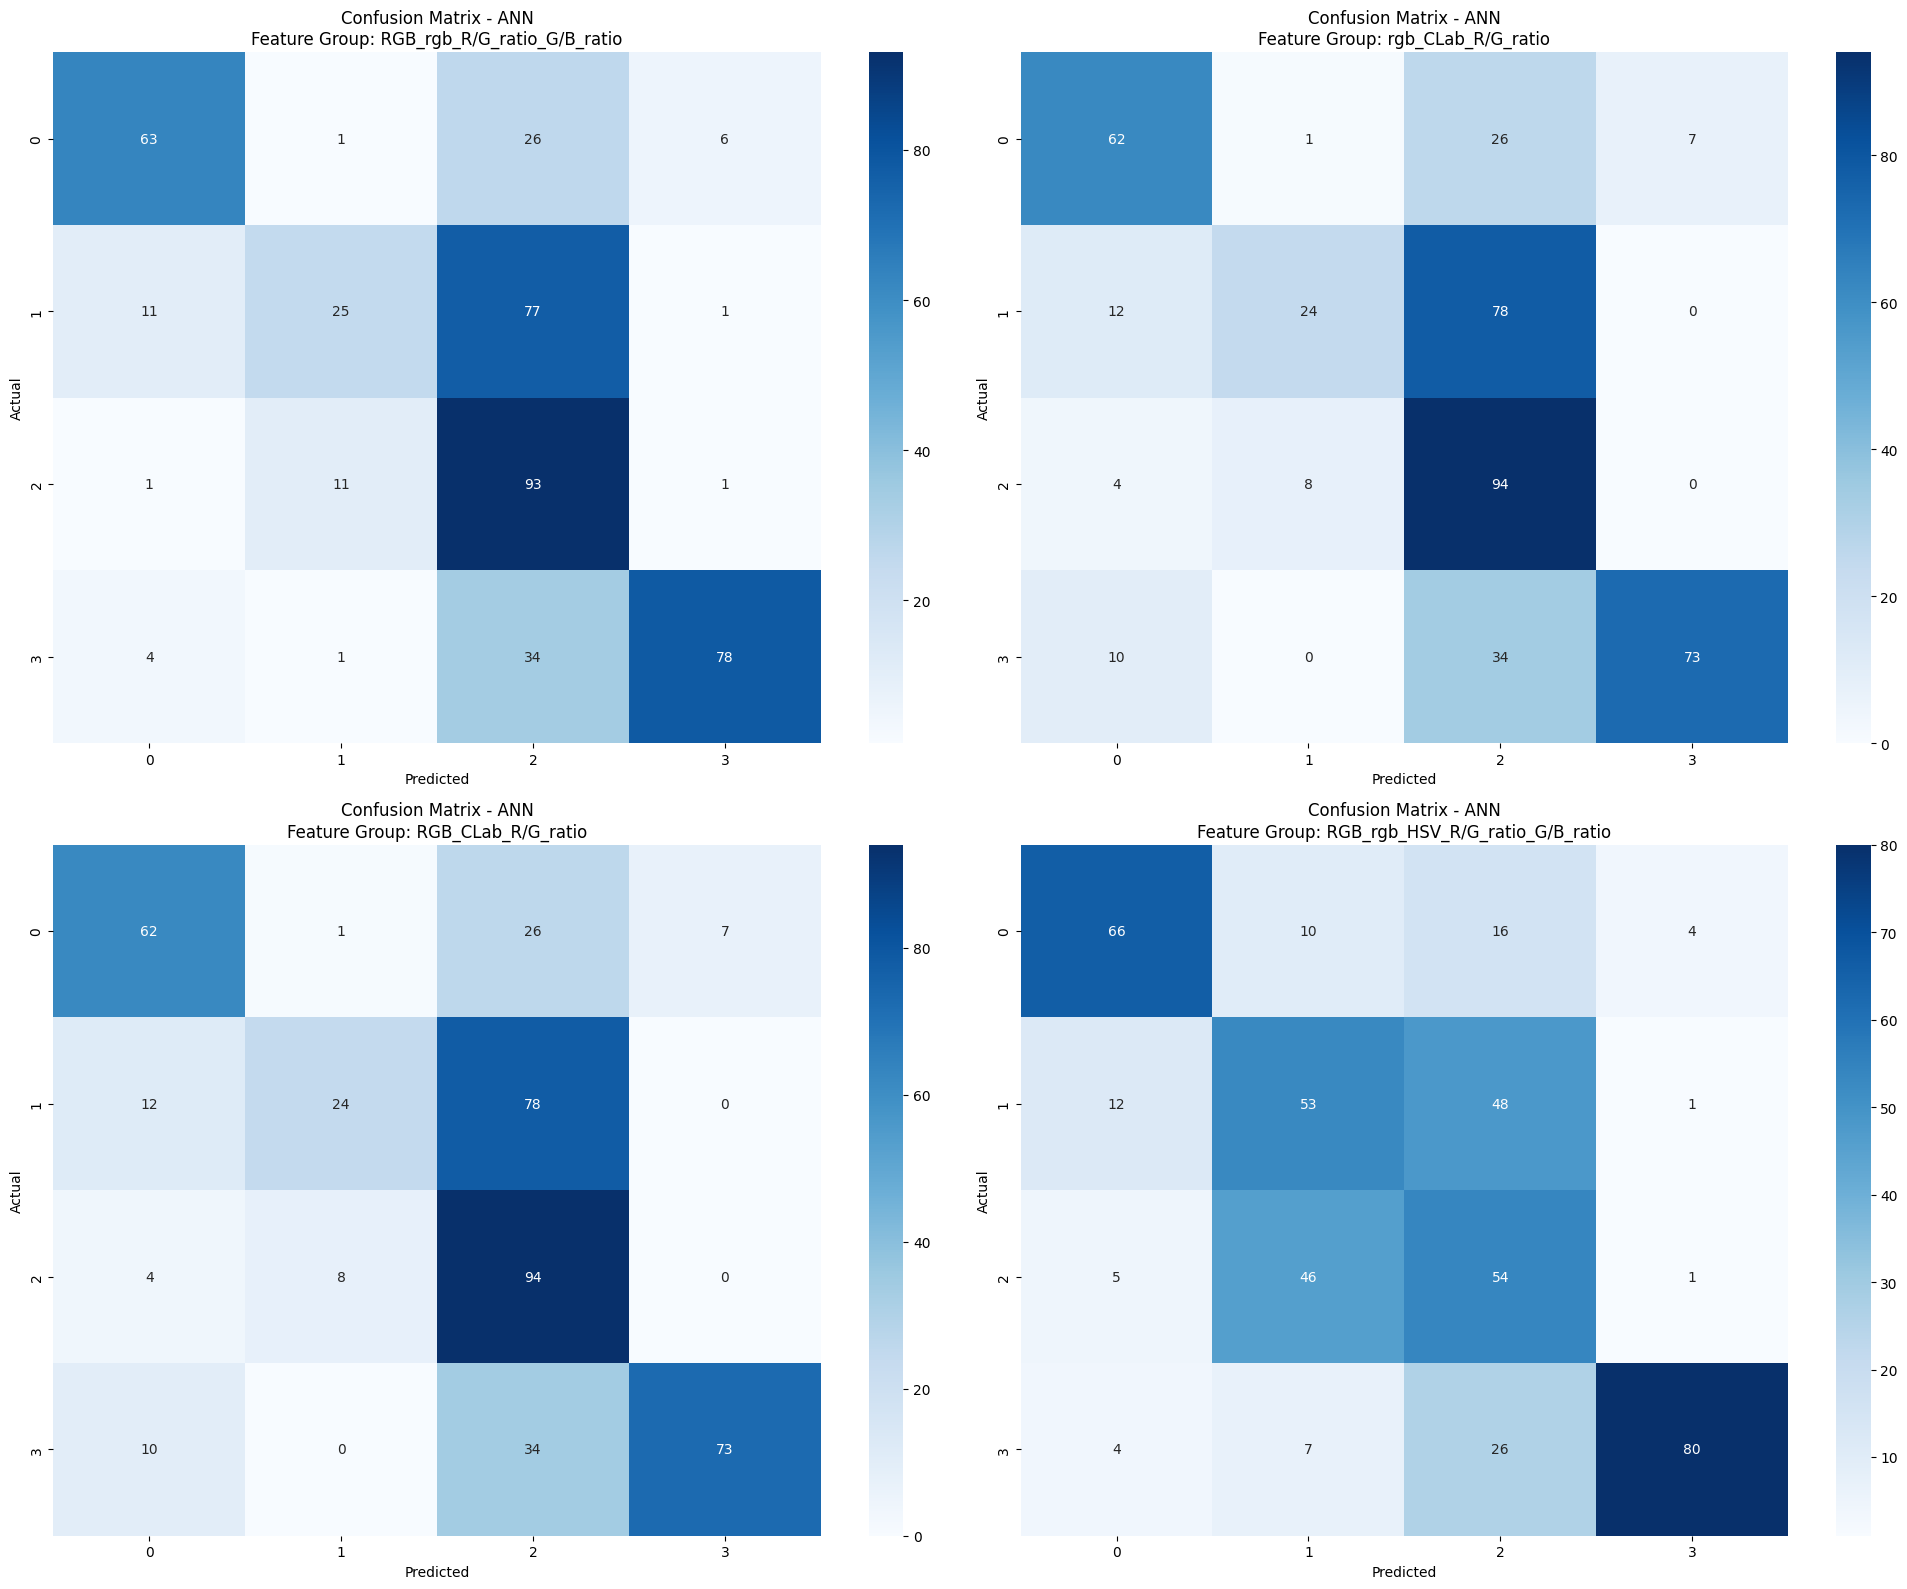

In [ ]:
visualize_top_feature_combinations(
    data_prep=data_prep,
    results=adapted_results_ann,
    metrics_df=metrics_df_final_ann_tuned,
    model_name='ANN',
)

### **Confusion Matrix Adaboost Decision Tree**

In [ ]:
adapted_results_adaboost_dt = adapt_results_for_visualization(results_adaboost_dt_tuned)

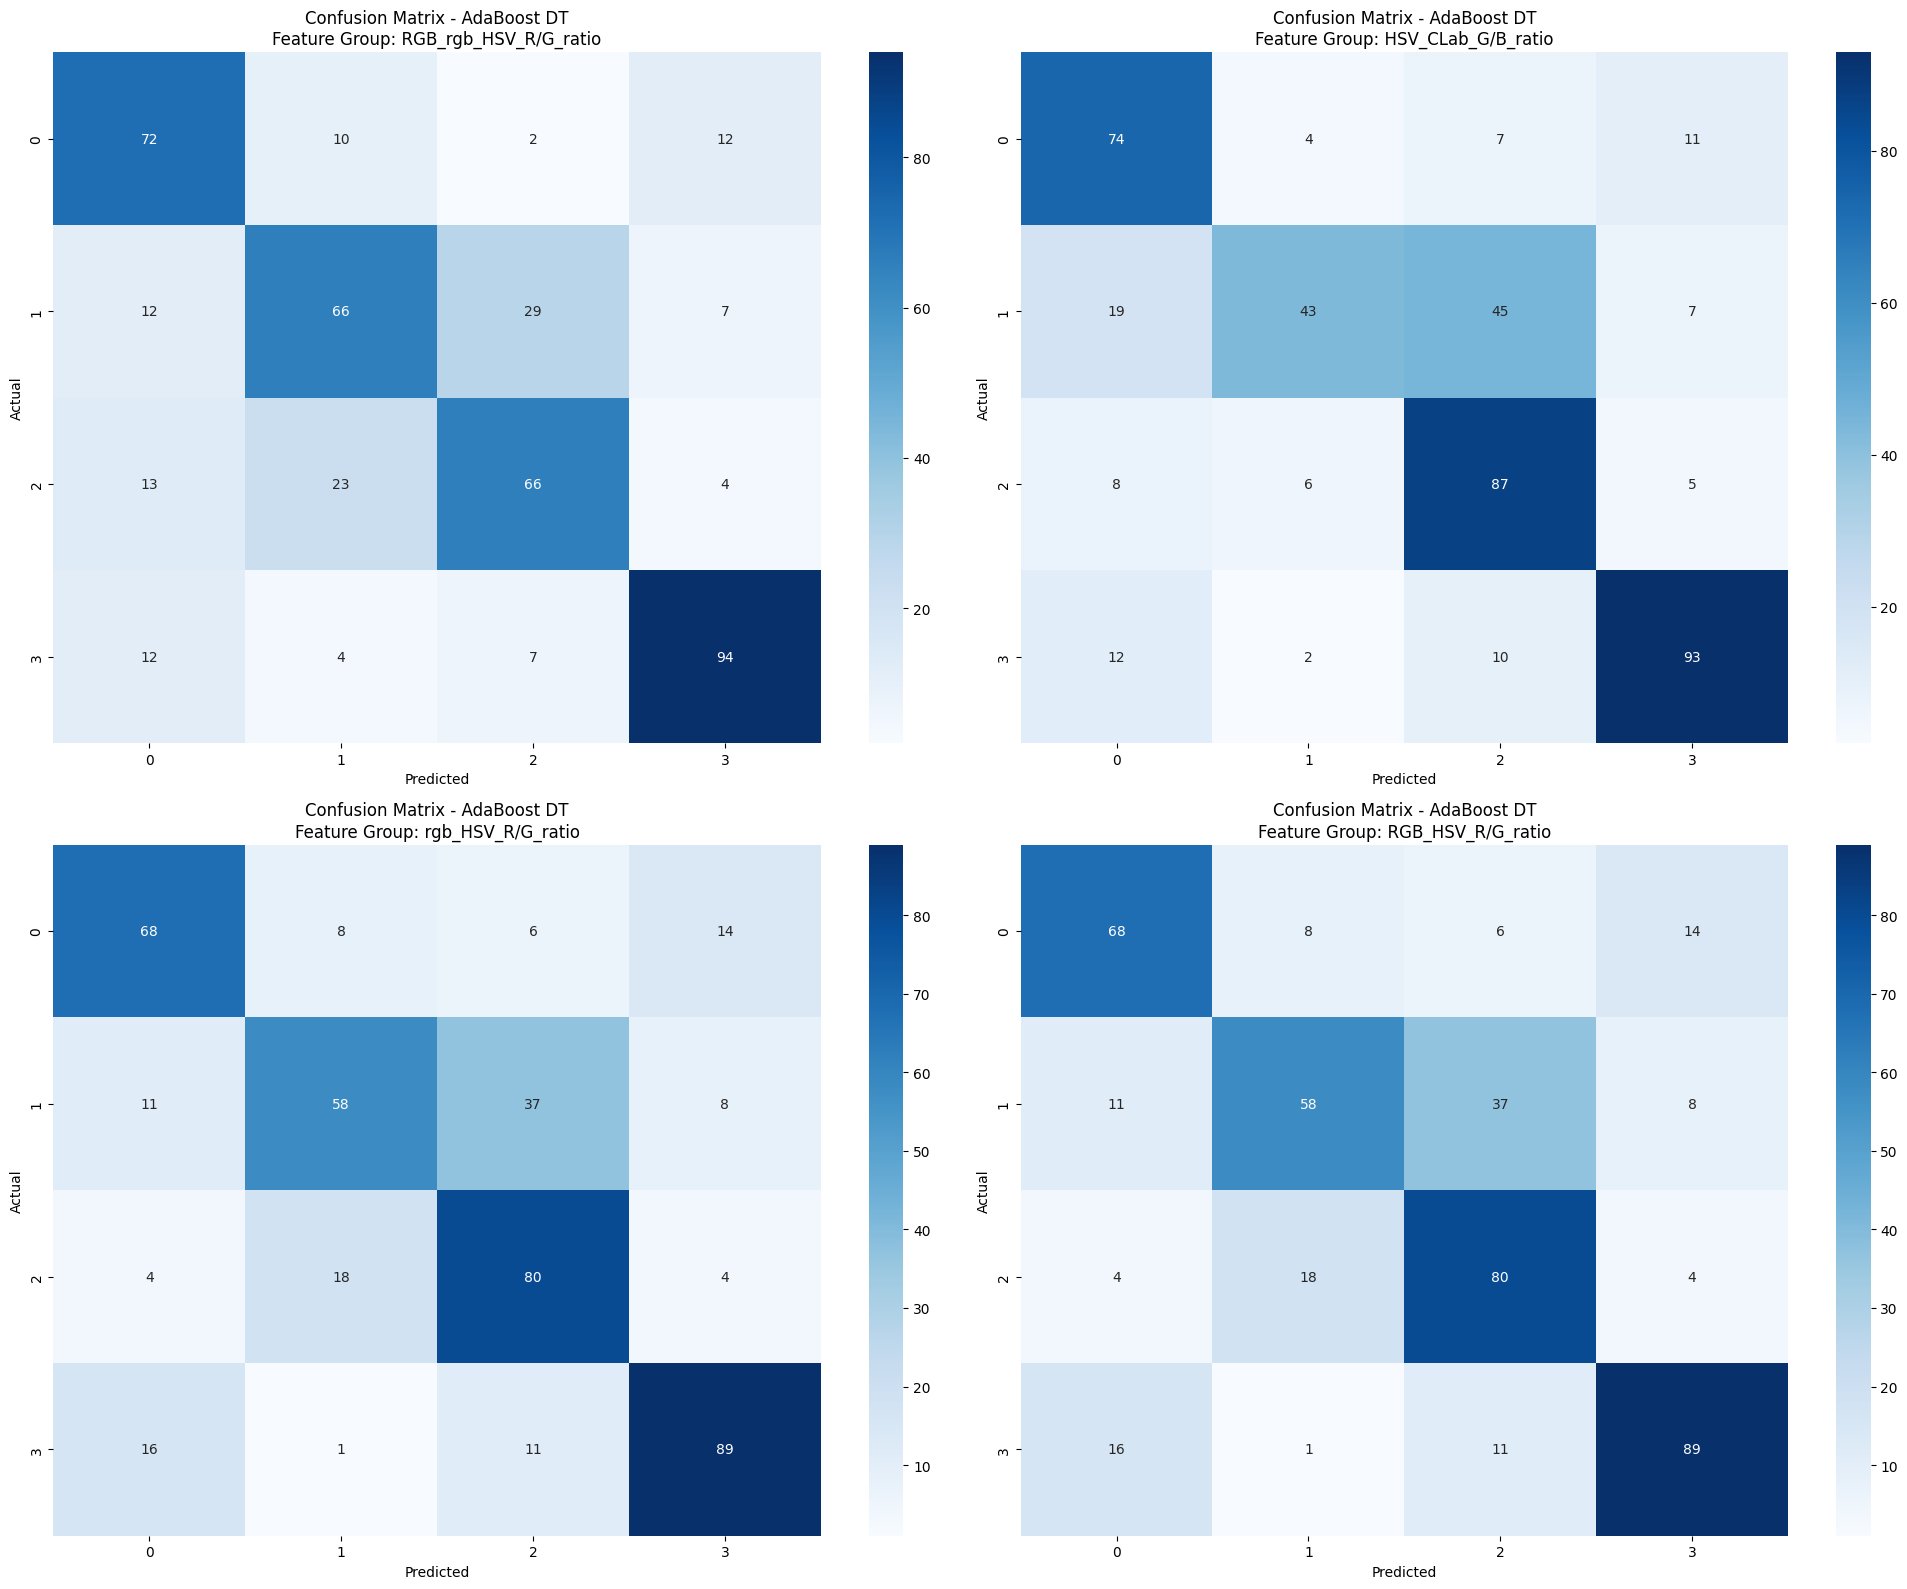

In [ ]:
visualize_top_feature_combinations(
    data_prep=data_prep,
    results=adapted_results_adaboost_dt,
    metrics_df=metrics_df_final_adaboost_dt_tuned,
    model_name='AdaBoost DT',
)

### **Confusion Matrix Adaboost SVM Kernel RBF**

In [ ]:
adapted_results_adaboost_svm = adapt_results_for_visualization(results_adaboost_svm_tuned)

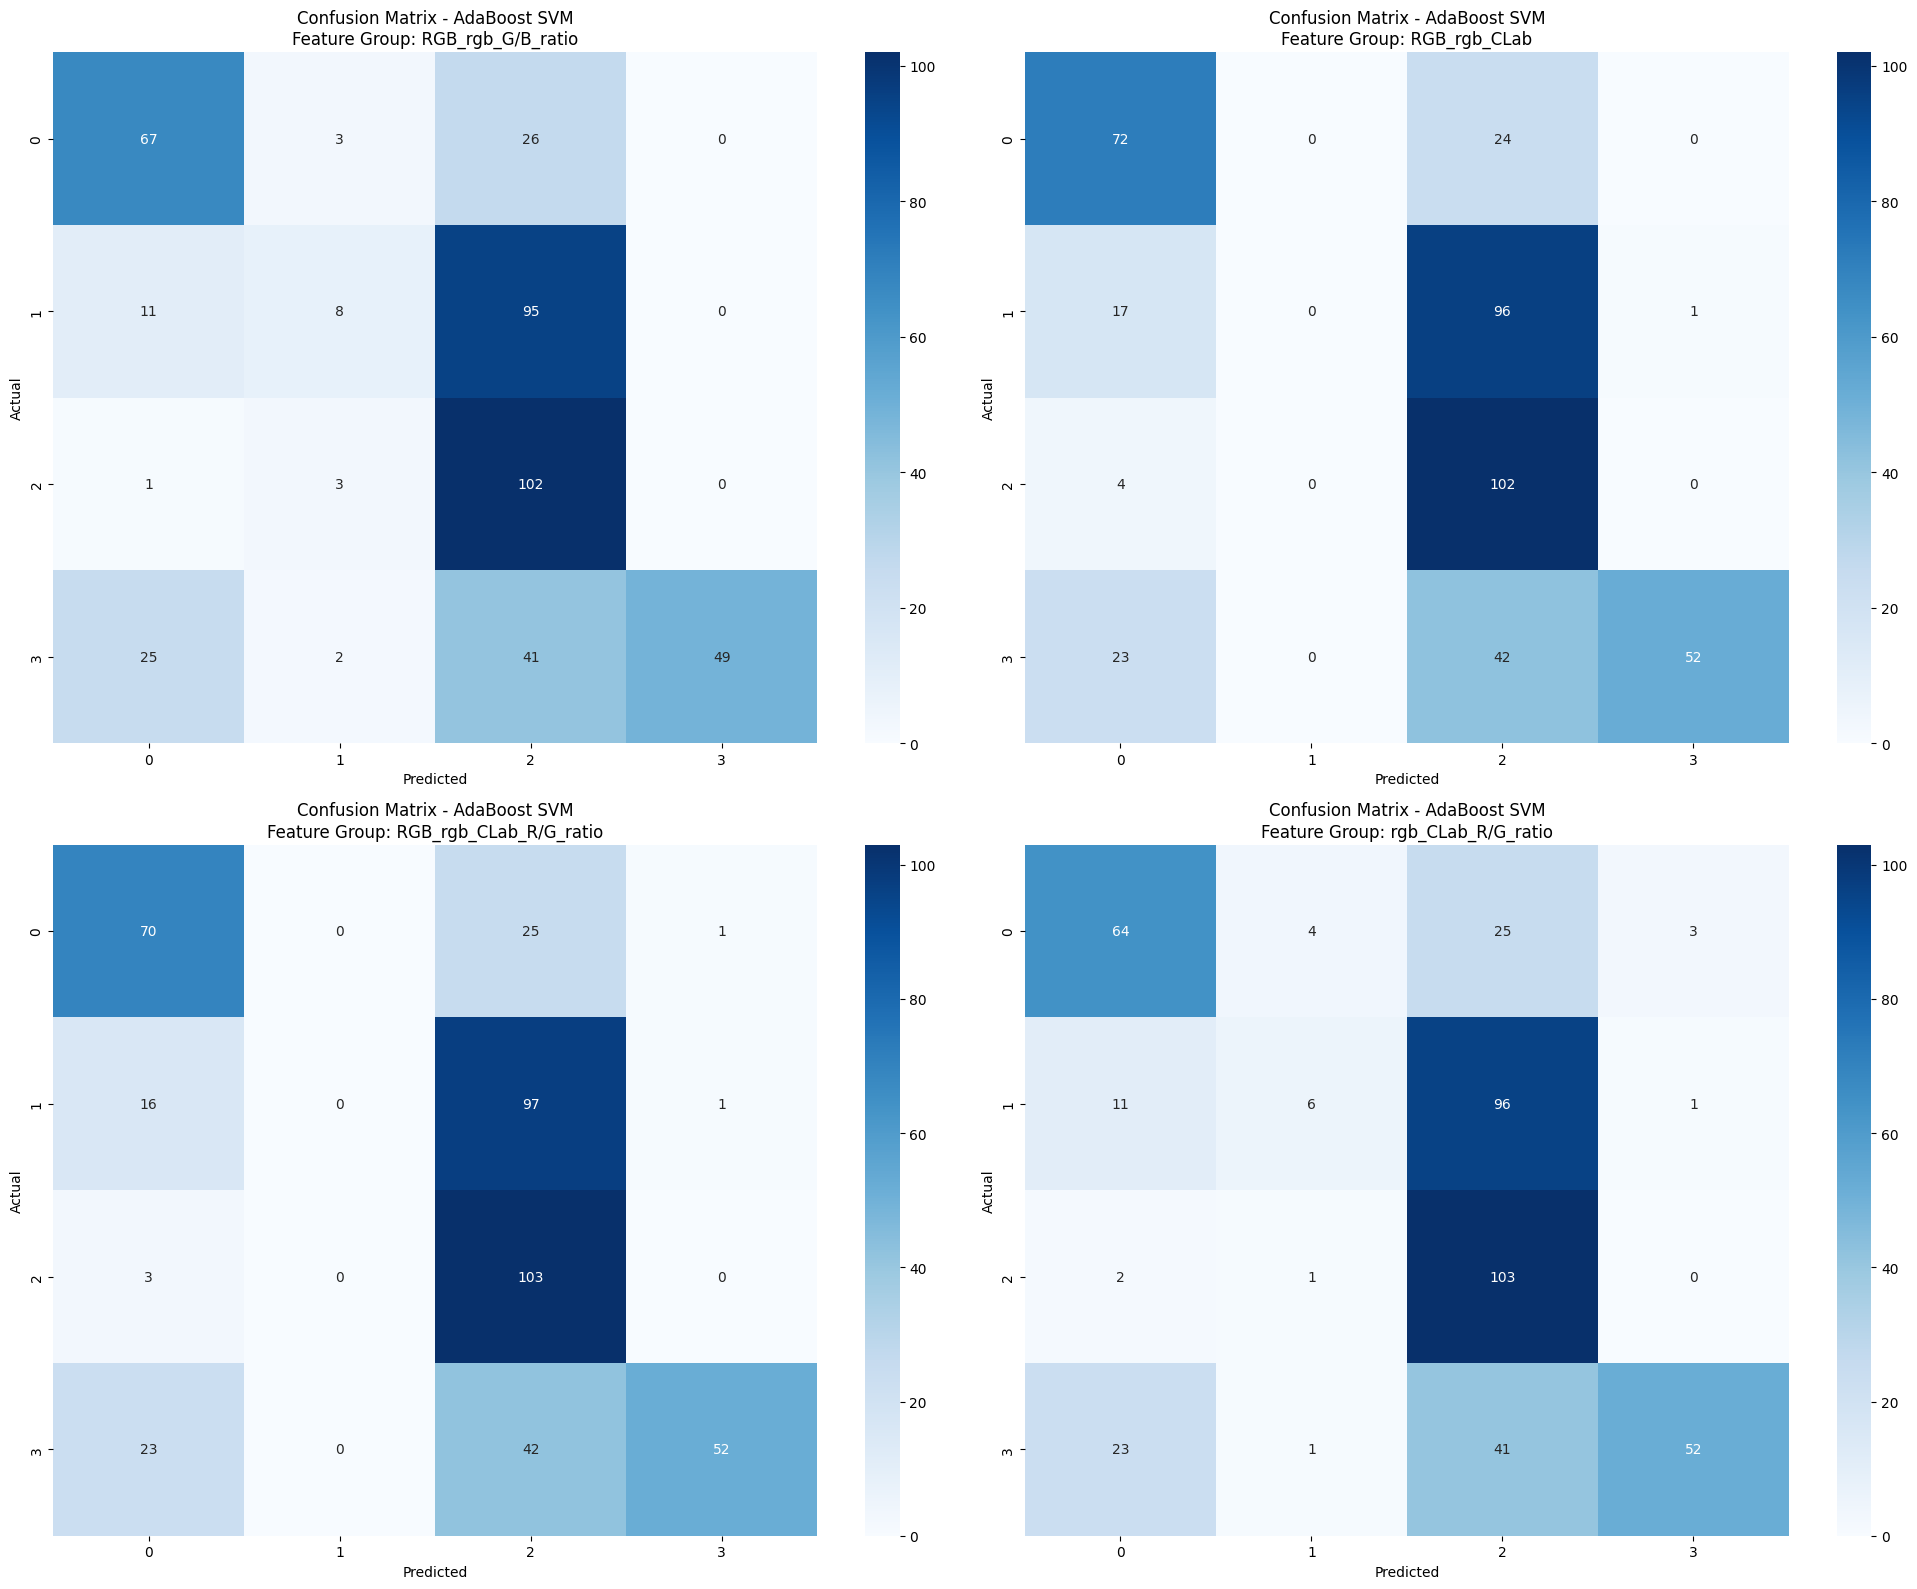

In [ ]:
visualize_top_feature_combinations(
    data_prep=data_prep,
    results=adapted_results_adaboost_svm,
    metrics_df=metrics_df_final_adaboost_svm_tuned,
    model_name='AdaBoost SVM',
)

### **Confusion Matrix Bagging SVM Kernel RBF**

In [ ]:
adapted_results_bagging_svm = adapt_results_for_visualization(results_bagging_svm_tuned)

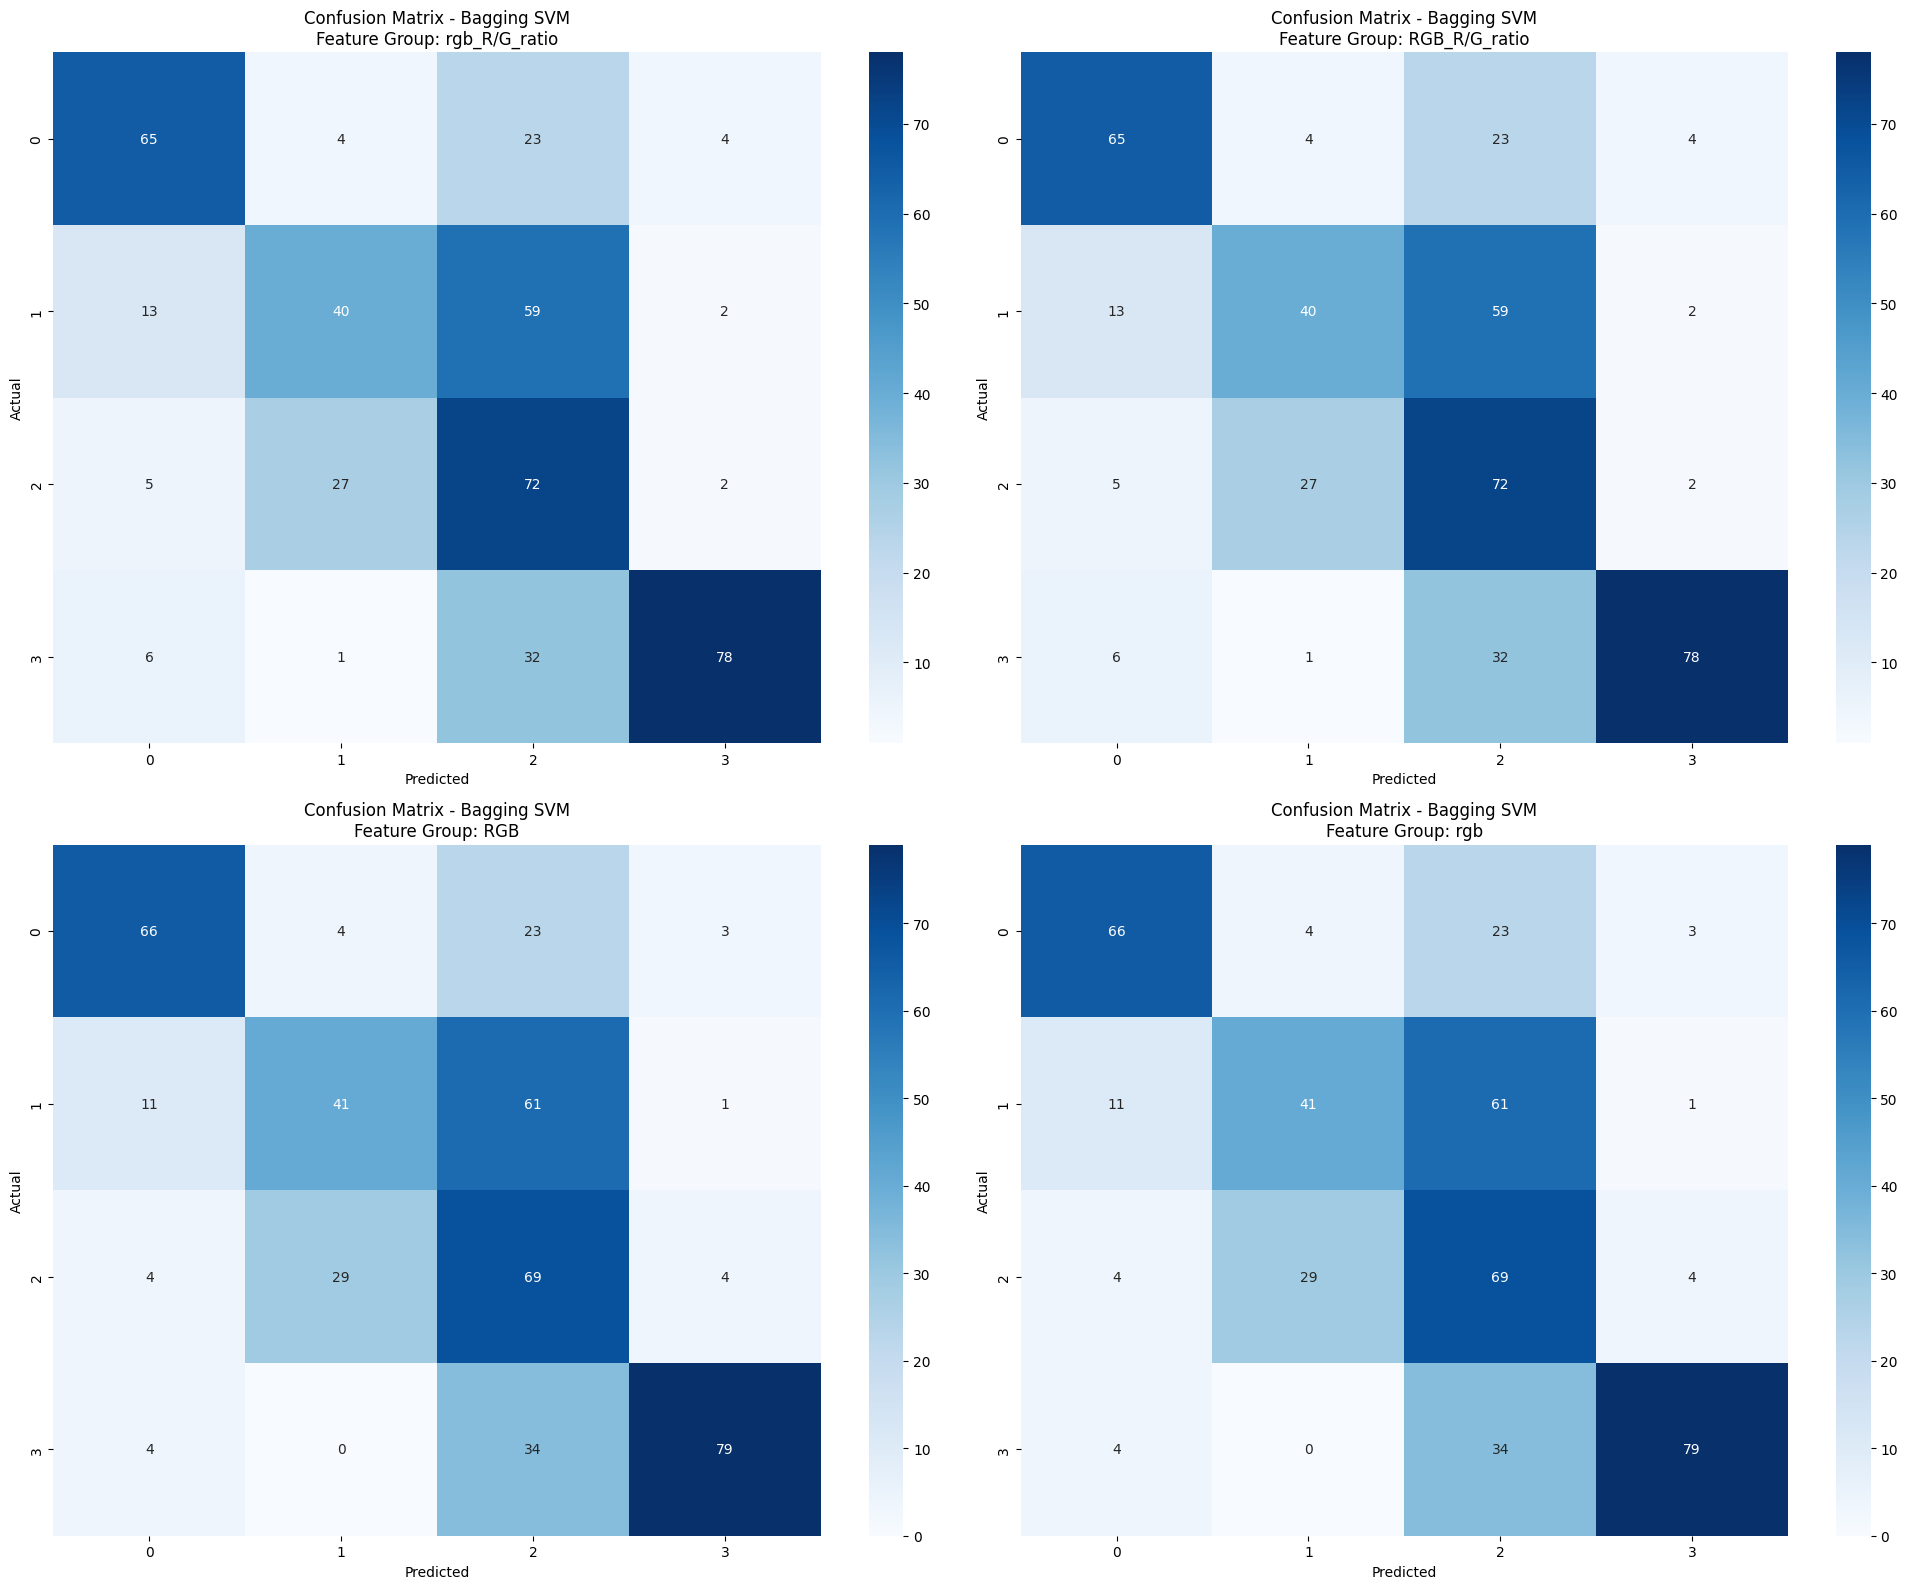

In [ ]:
visualize_top_feature_combinations(
    data_prep=data_prep,
    results=adapted_results_bagging_svm,
    metrics_df=metrics_df_final_bagging_svm_tuned,
    model_name='Bagging SVM',
)

## **ROC-AUC Fine Tunning**

### **ROC-AUC ANN**

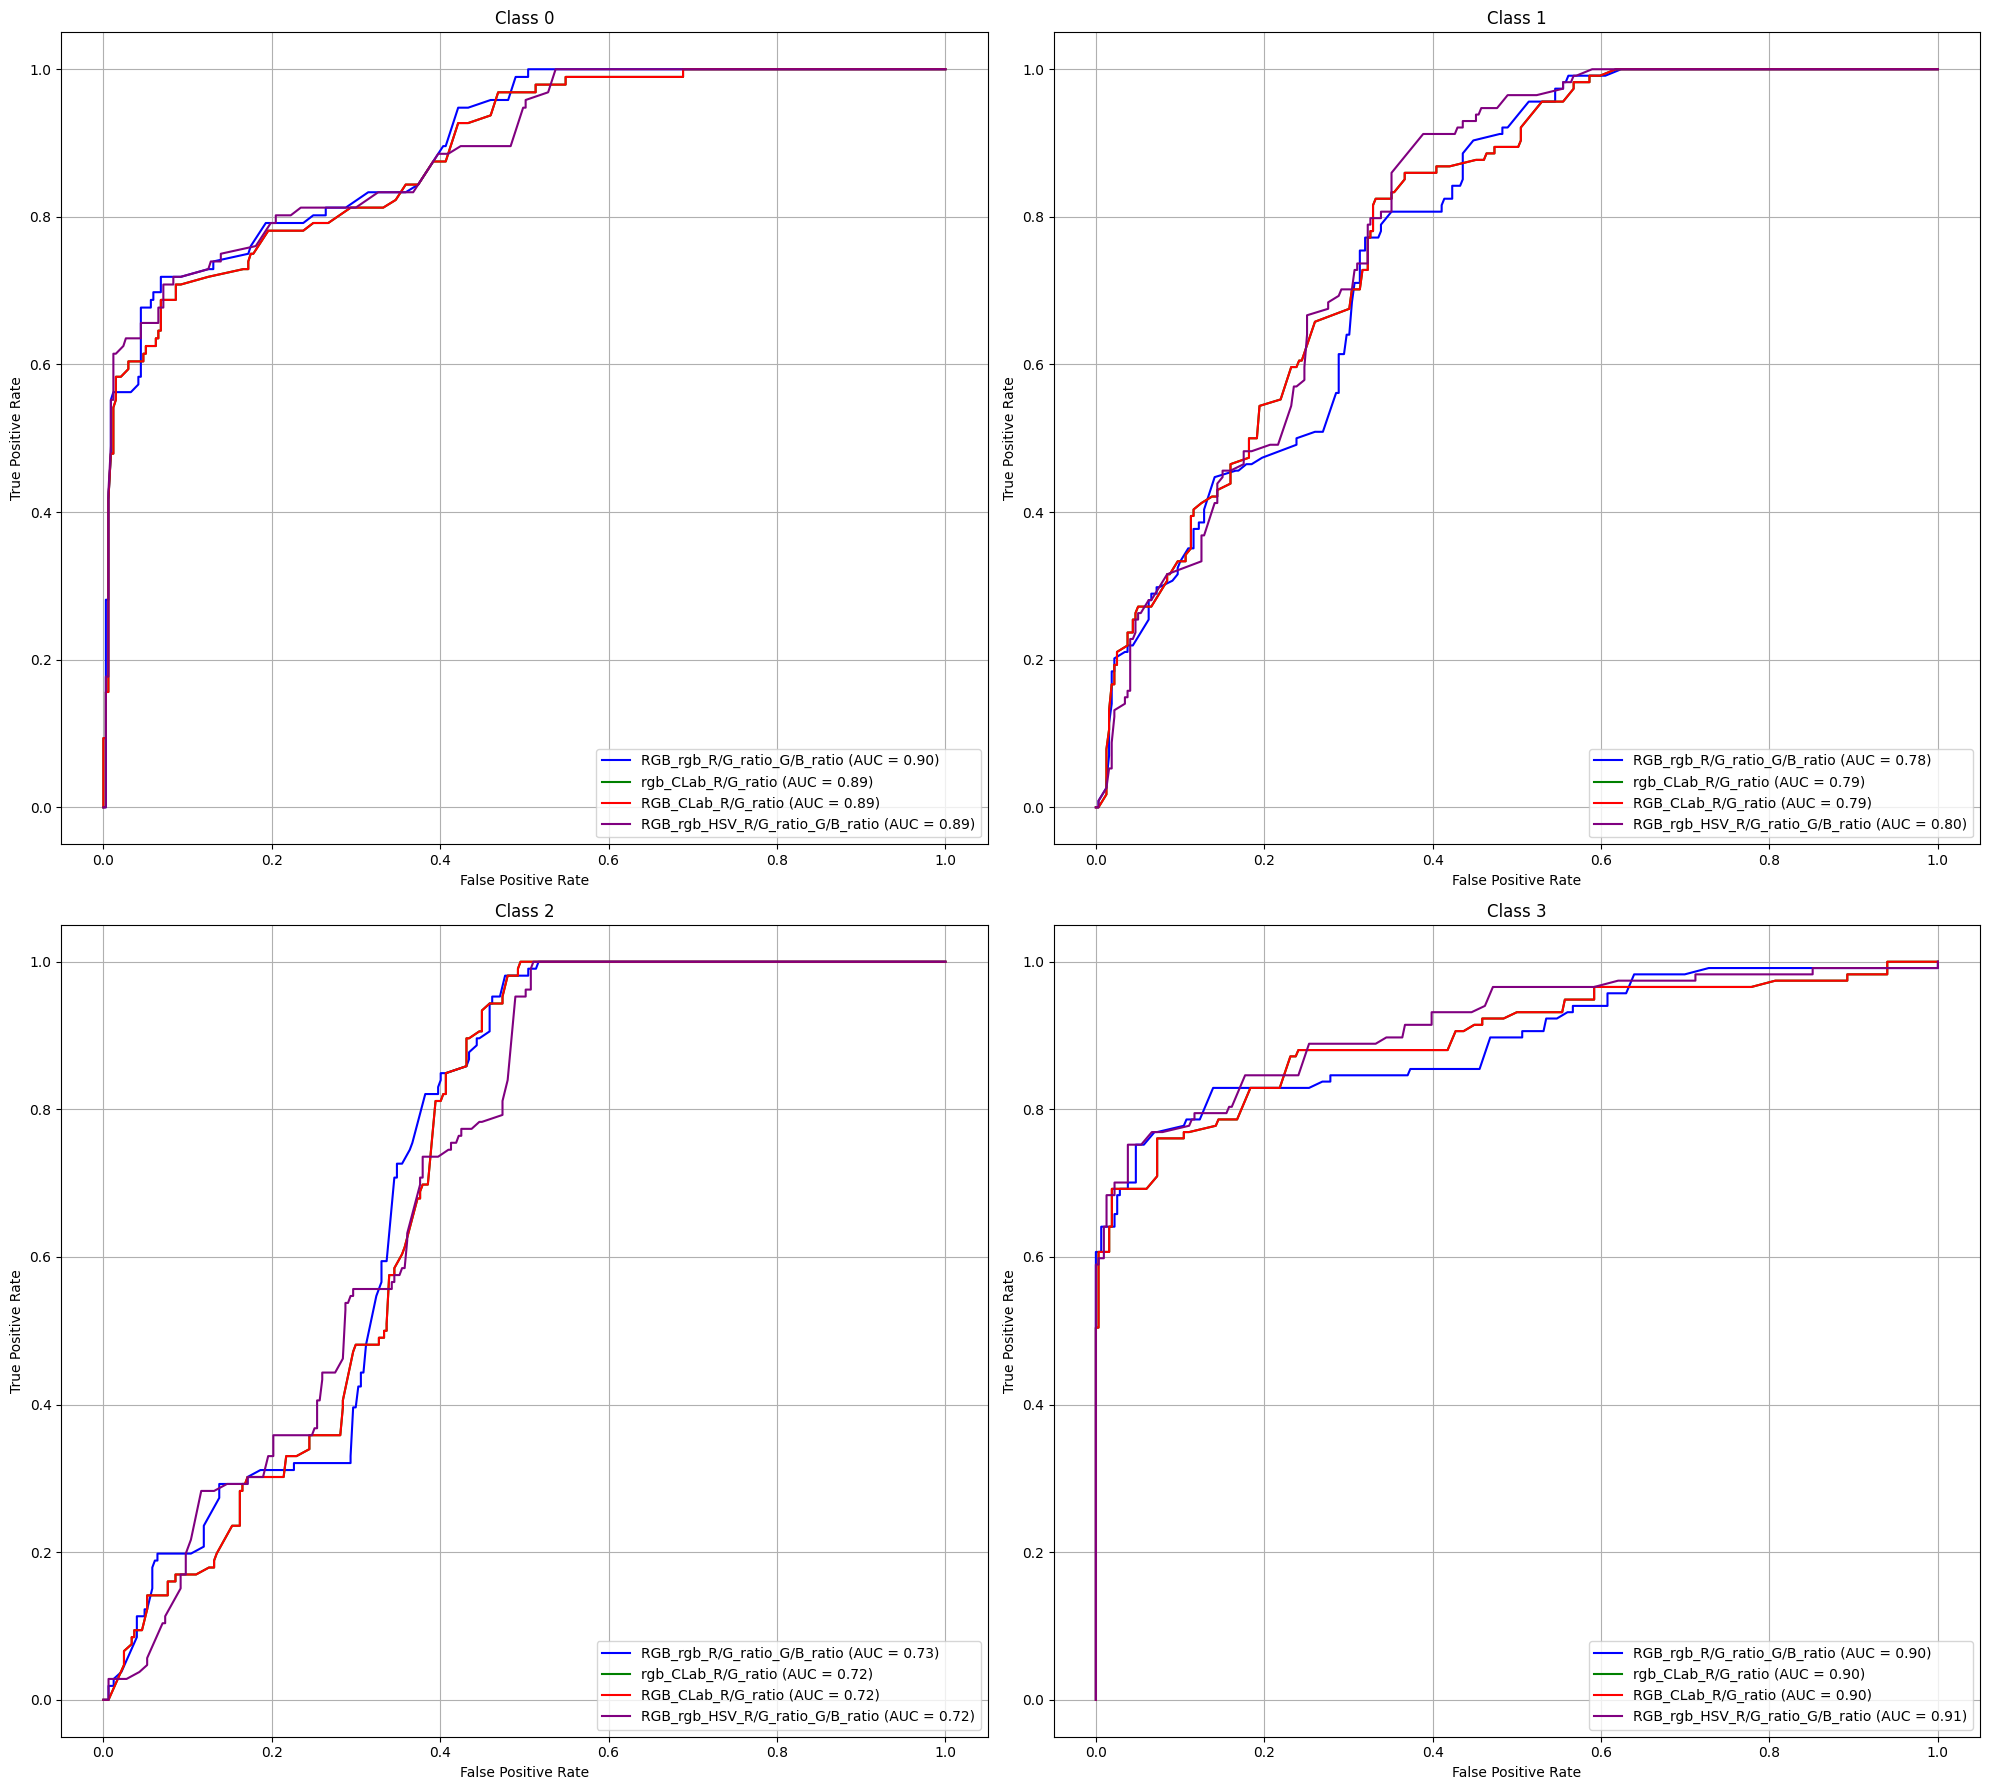

In [ ]:
plot_roc_per_model(
    results=adapted_results_ann,
    feature_groups=data_prep,
    model_name='ANN',
    metrics_df=metrics_df_final_ann_tuned
)

### **ROC-AUC Adaboost Decision Tree**

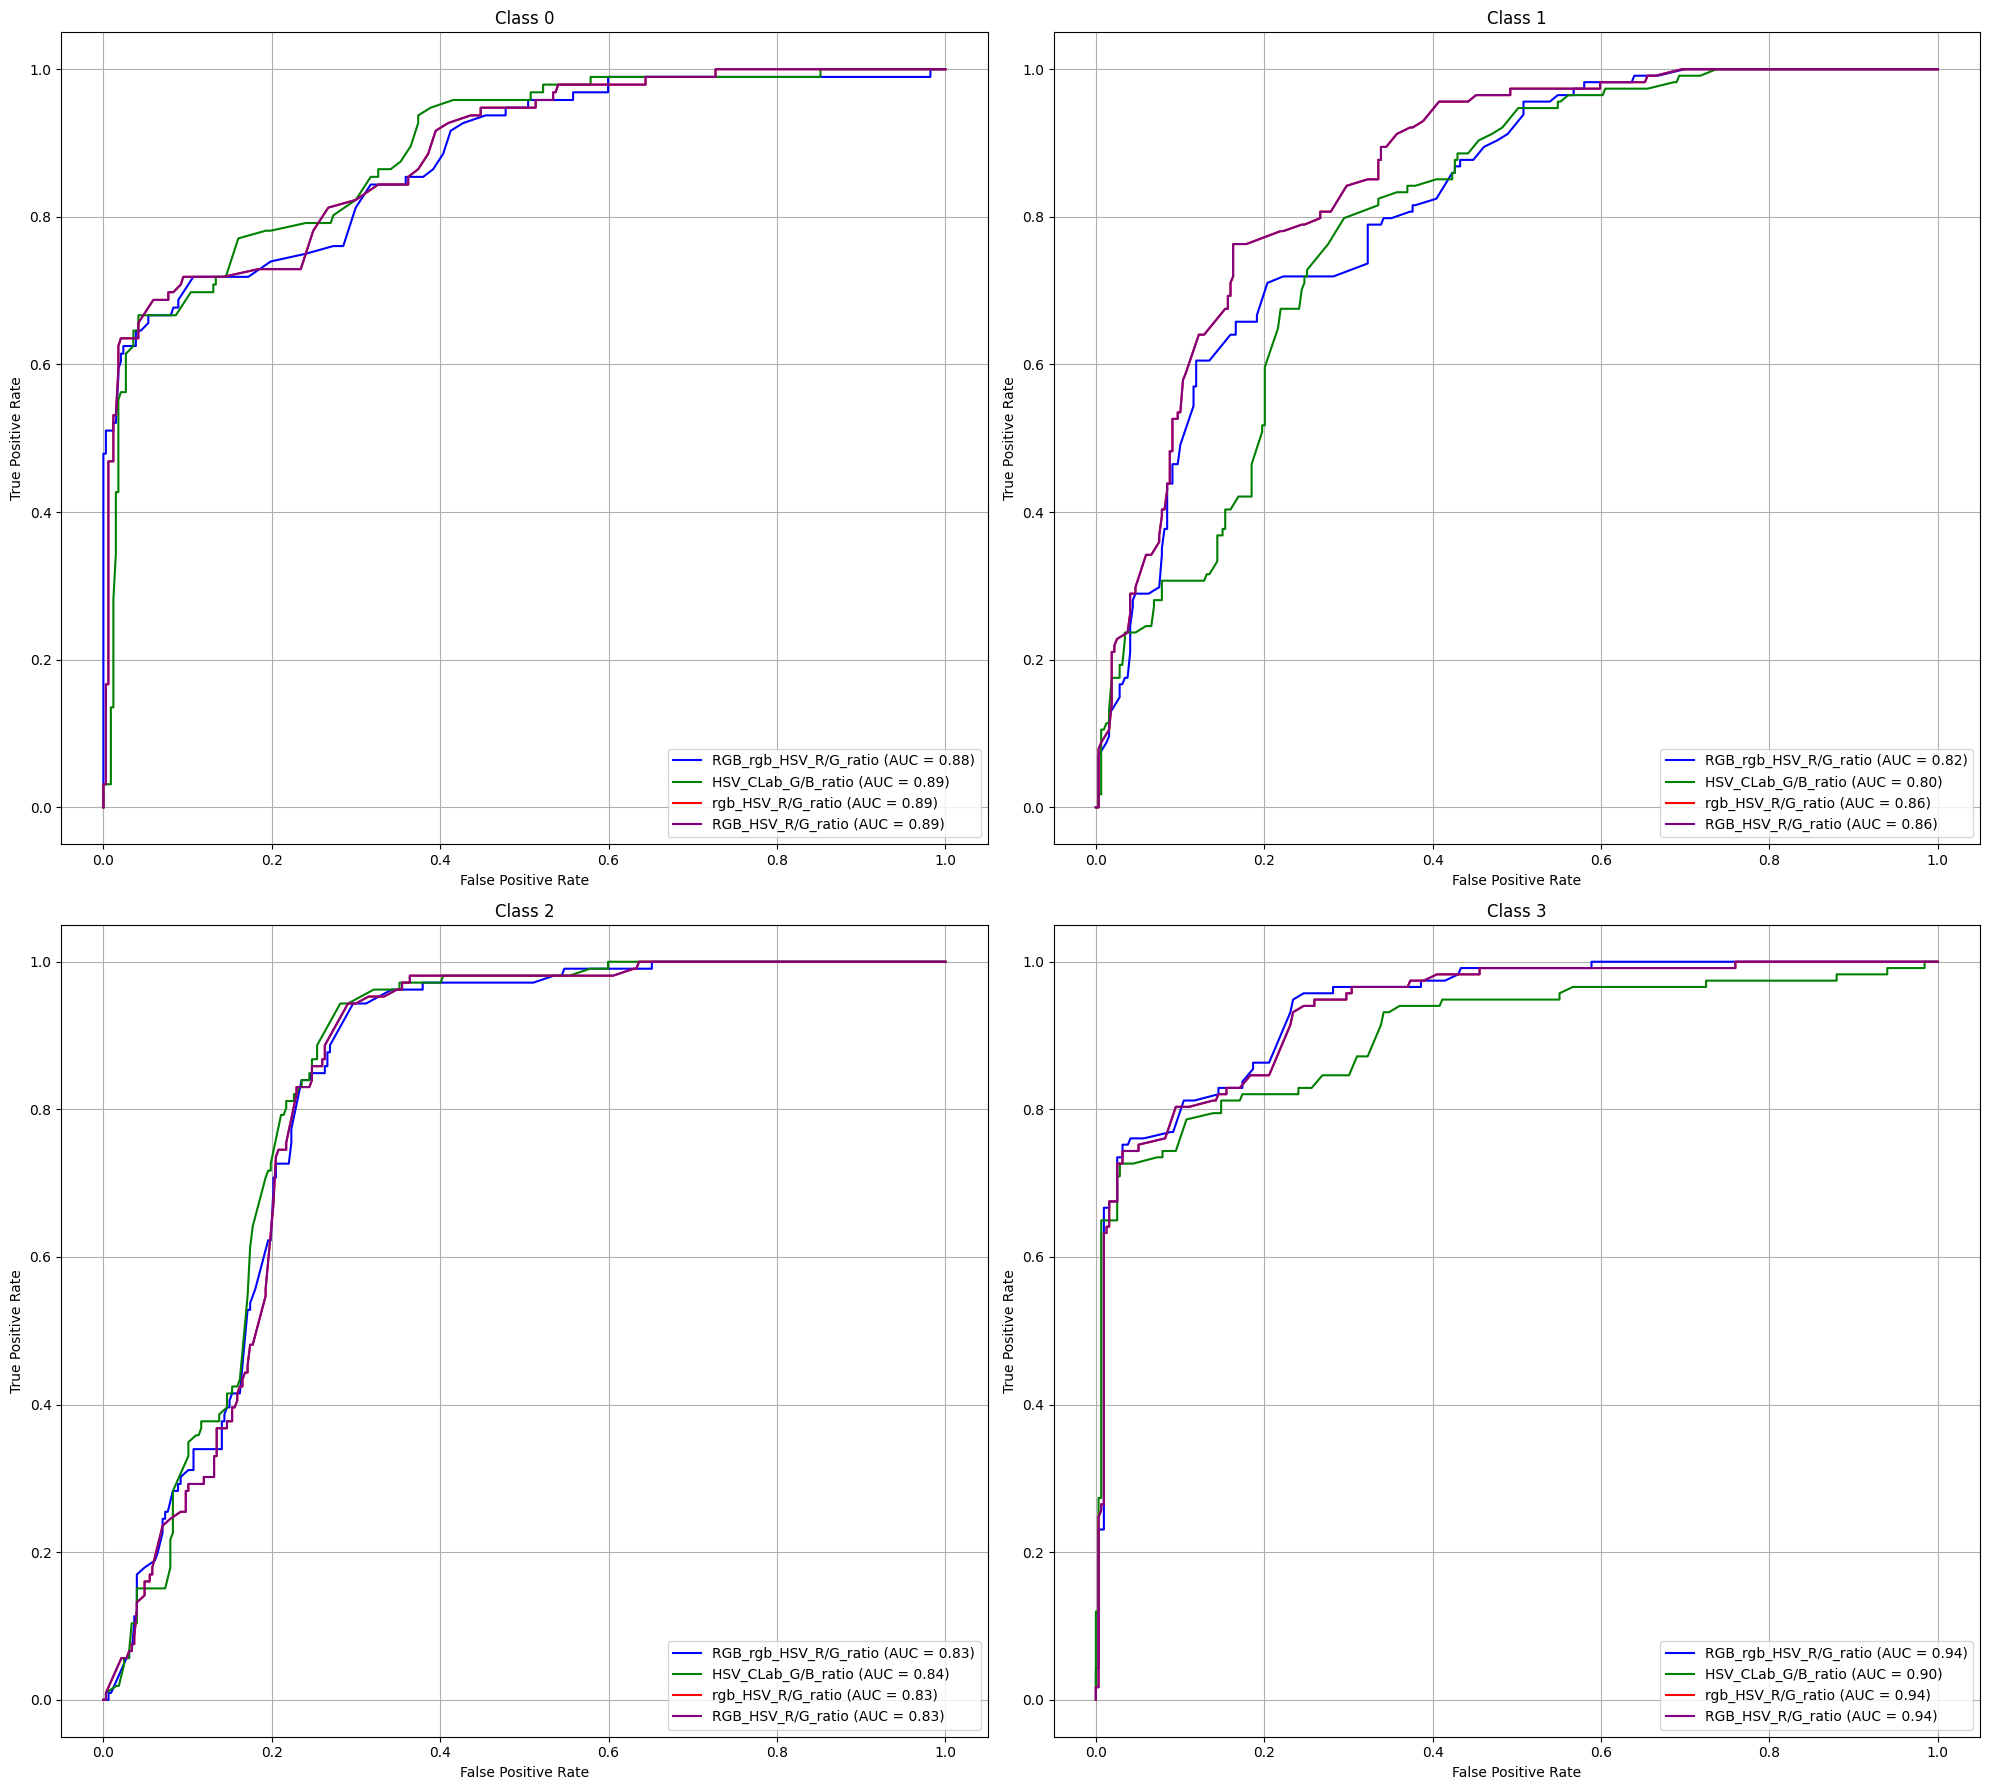

In [ ]:
plot_roc_per_model(
    results=adapted_results_adaboost_dt,
    feature_groups=data_prep,
    model_name='AdaBoost DT',
    metrics_df=metrics_df_final_adaboost_dt_tuned
)

### **ROC-AUC Adaboost SVM Kernel RBF**

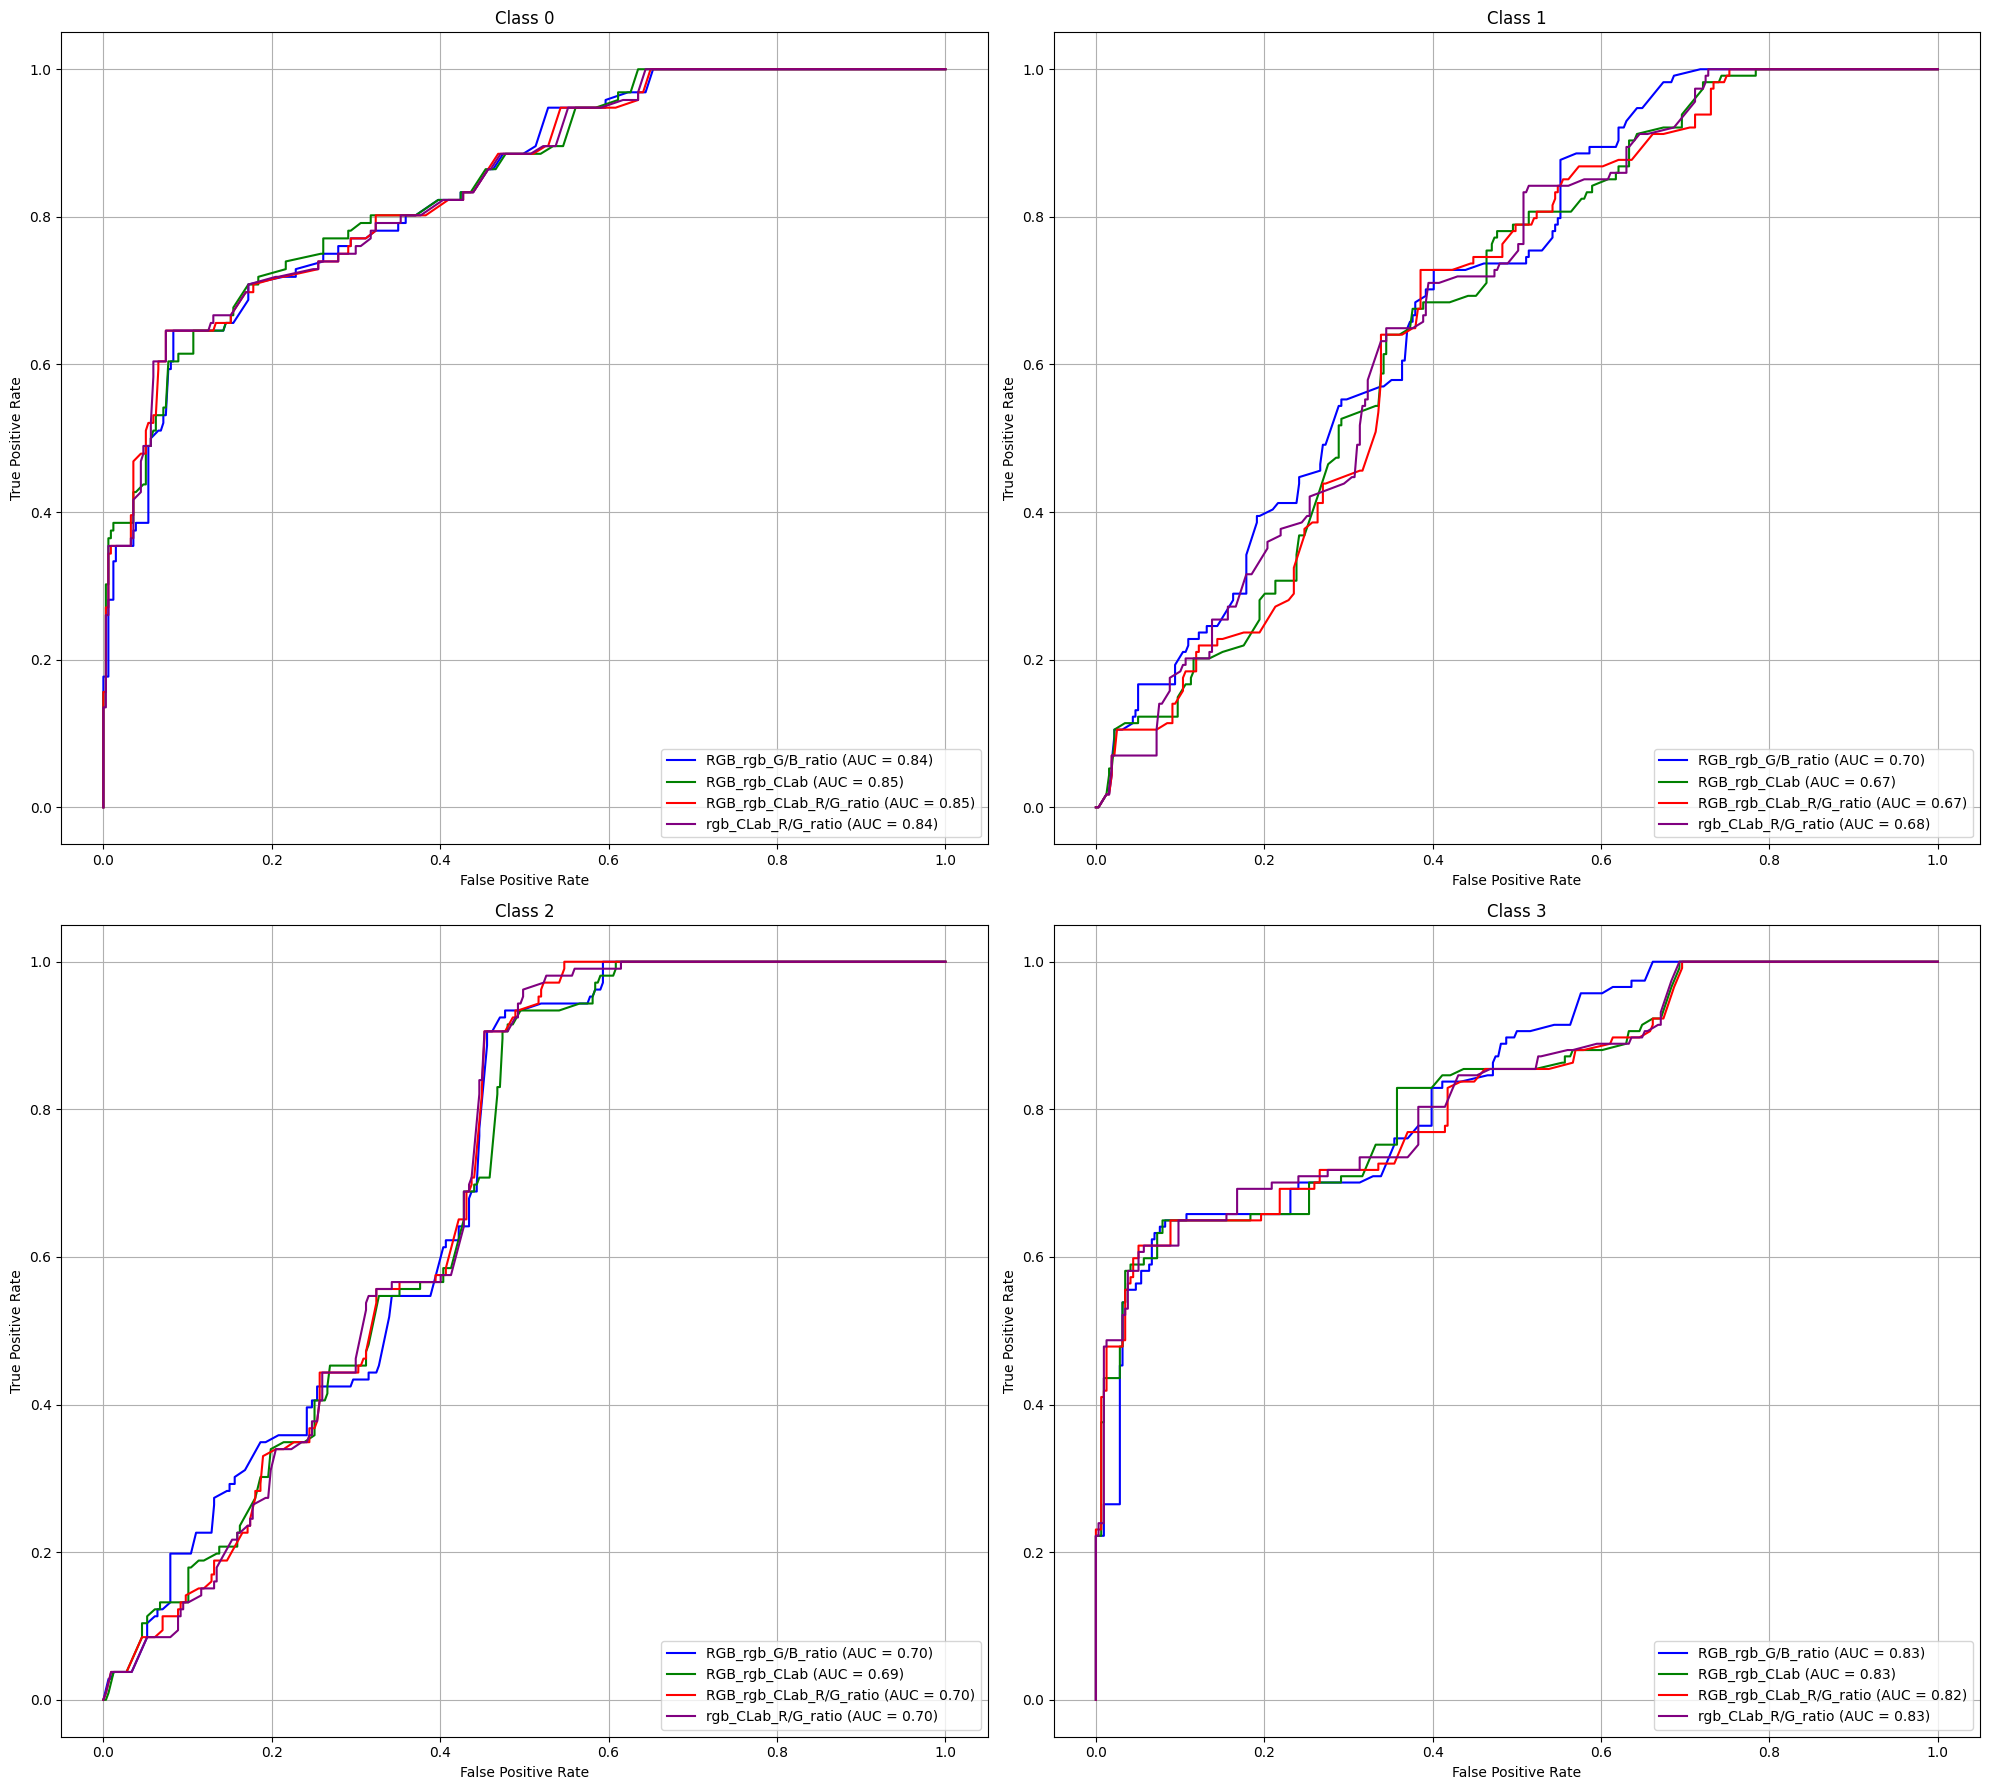

In [ ]:
plot_roc_per_model(
    results=adapted_results_adaboost_svm,
    feature_groups=data_prep,
    model_name='AdaBoost SVM',
    metrics_df=metrics_df_final_adaboost_svm_tuned
)

### **ROC-AUC Bagging SVM Kernel RBF**

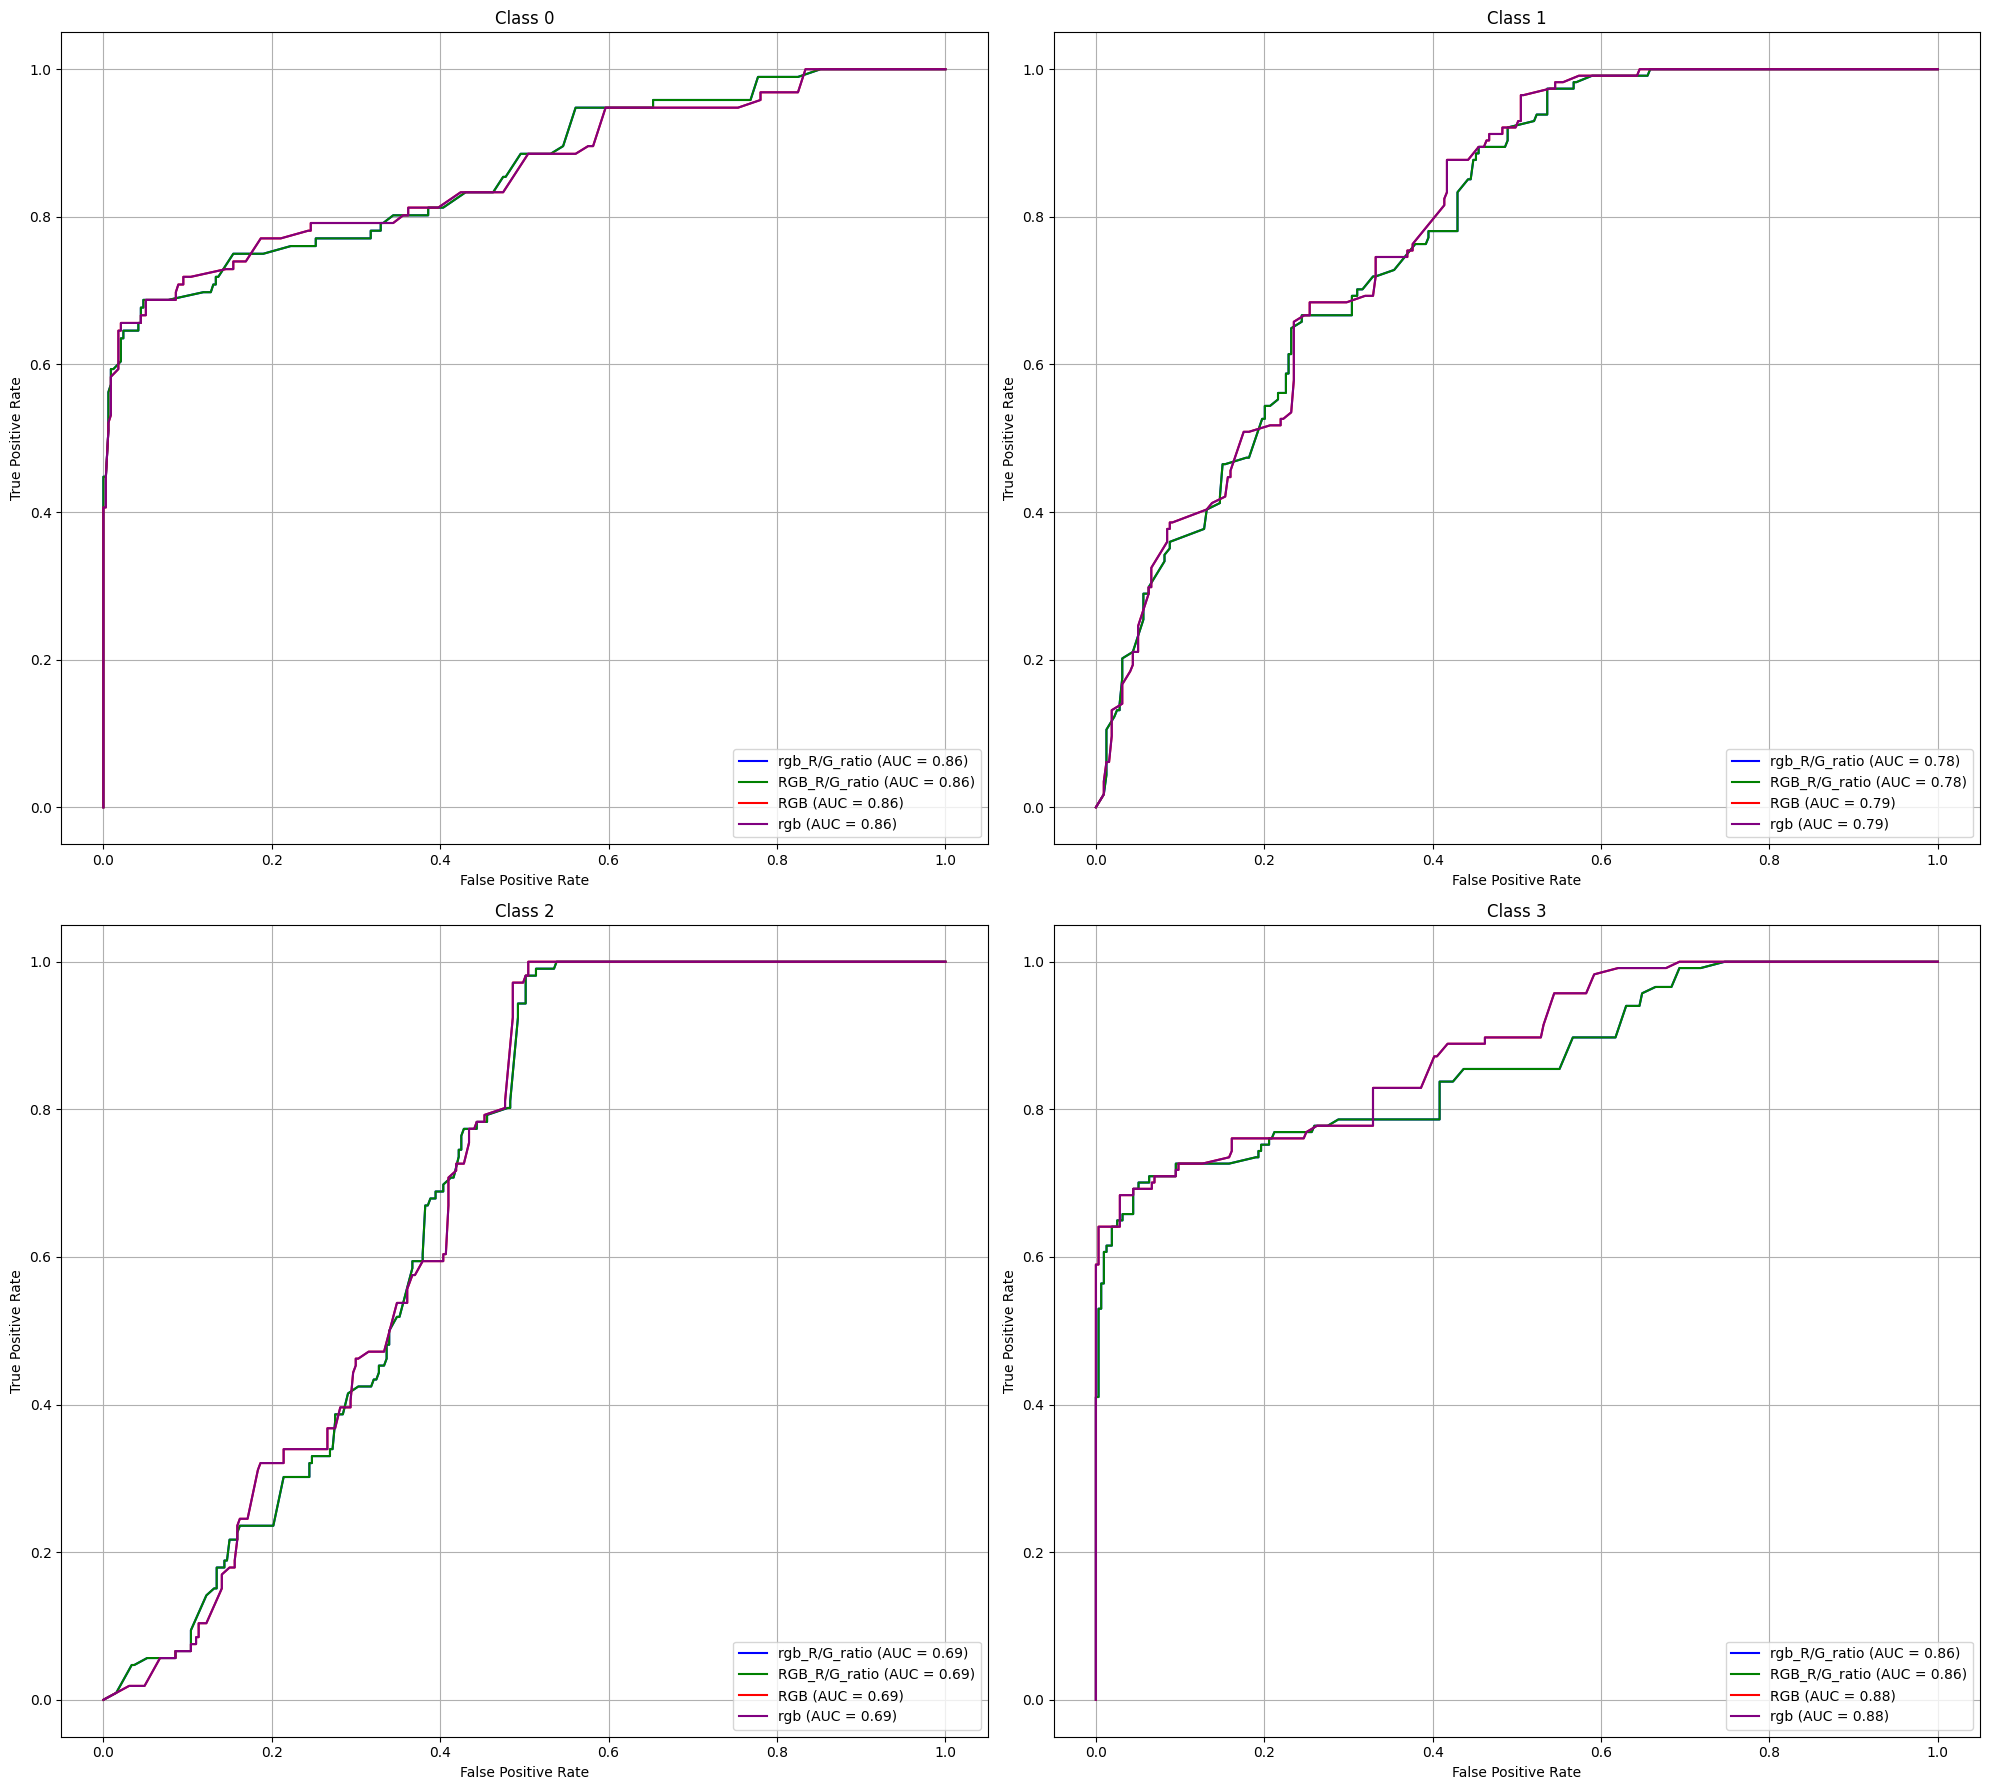

In [ ]:
plot_roc_per_model(
    results=adapted_results_bagging_svm,
    feature_groups=data_prep,
    model_name='Bagging SVM',
    metrics_df=metrics_df_final_bagging_svm_tuned
)

## **Perbandingan Metrik Test Hasil Fine Tuning**

In [ ]:
metrics_dicts_tuned_cv = {
    'ANN': metrics_df_cv_ann_tuned,
    'AdaBoost DT': metrics_df_cv_adaboost_dt_tuned,
    'AdaBoost SVM': metrics_df_cv_adaboost_svm_tuned,
    'Bagging SVM': metrics_df_cv_bagging_svm_tuned
}


metrics_dicts_average_cv = {
    model_name: df[df['Fold'] == 'Average']
    for model_name, df in metrics_dicts_tuned_cv.items()
}


metrics_dicts_tuned_final = {
    'ANN': metrics_df_final_ann_tuned,
    'AdaBoost DT': metrics_df_final_adaboost_dt_tuned,
    'AdaBoost SVM': metrics_df_final_adaboost_svm_tuned,
    'Bagging SVM': metrics_df_final_bagging_svm_tuned
}

model_names_tuned = ['ANN', 'AdaBoost DT', 'AdaBoost SVM', 'Bagging SVM']

### **Cross Validation**

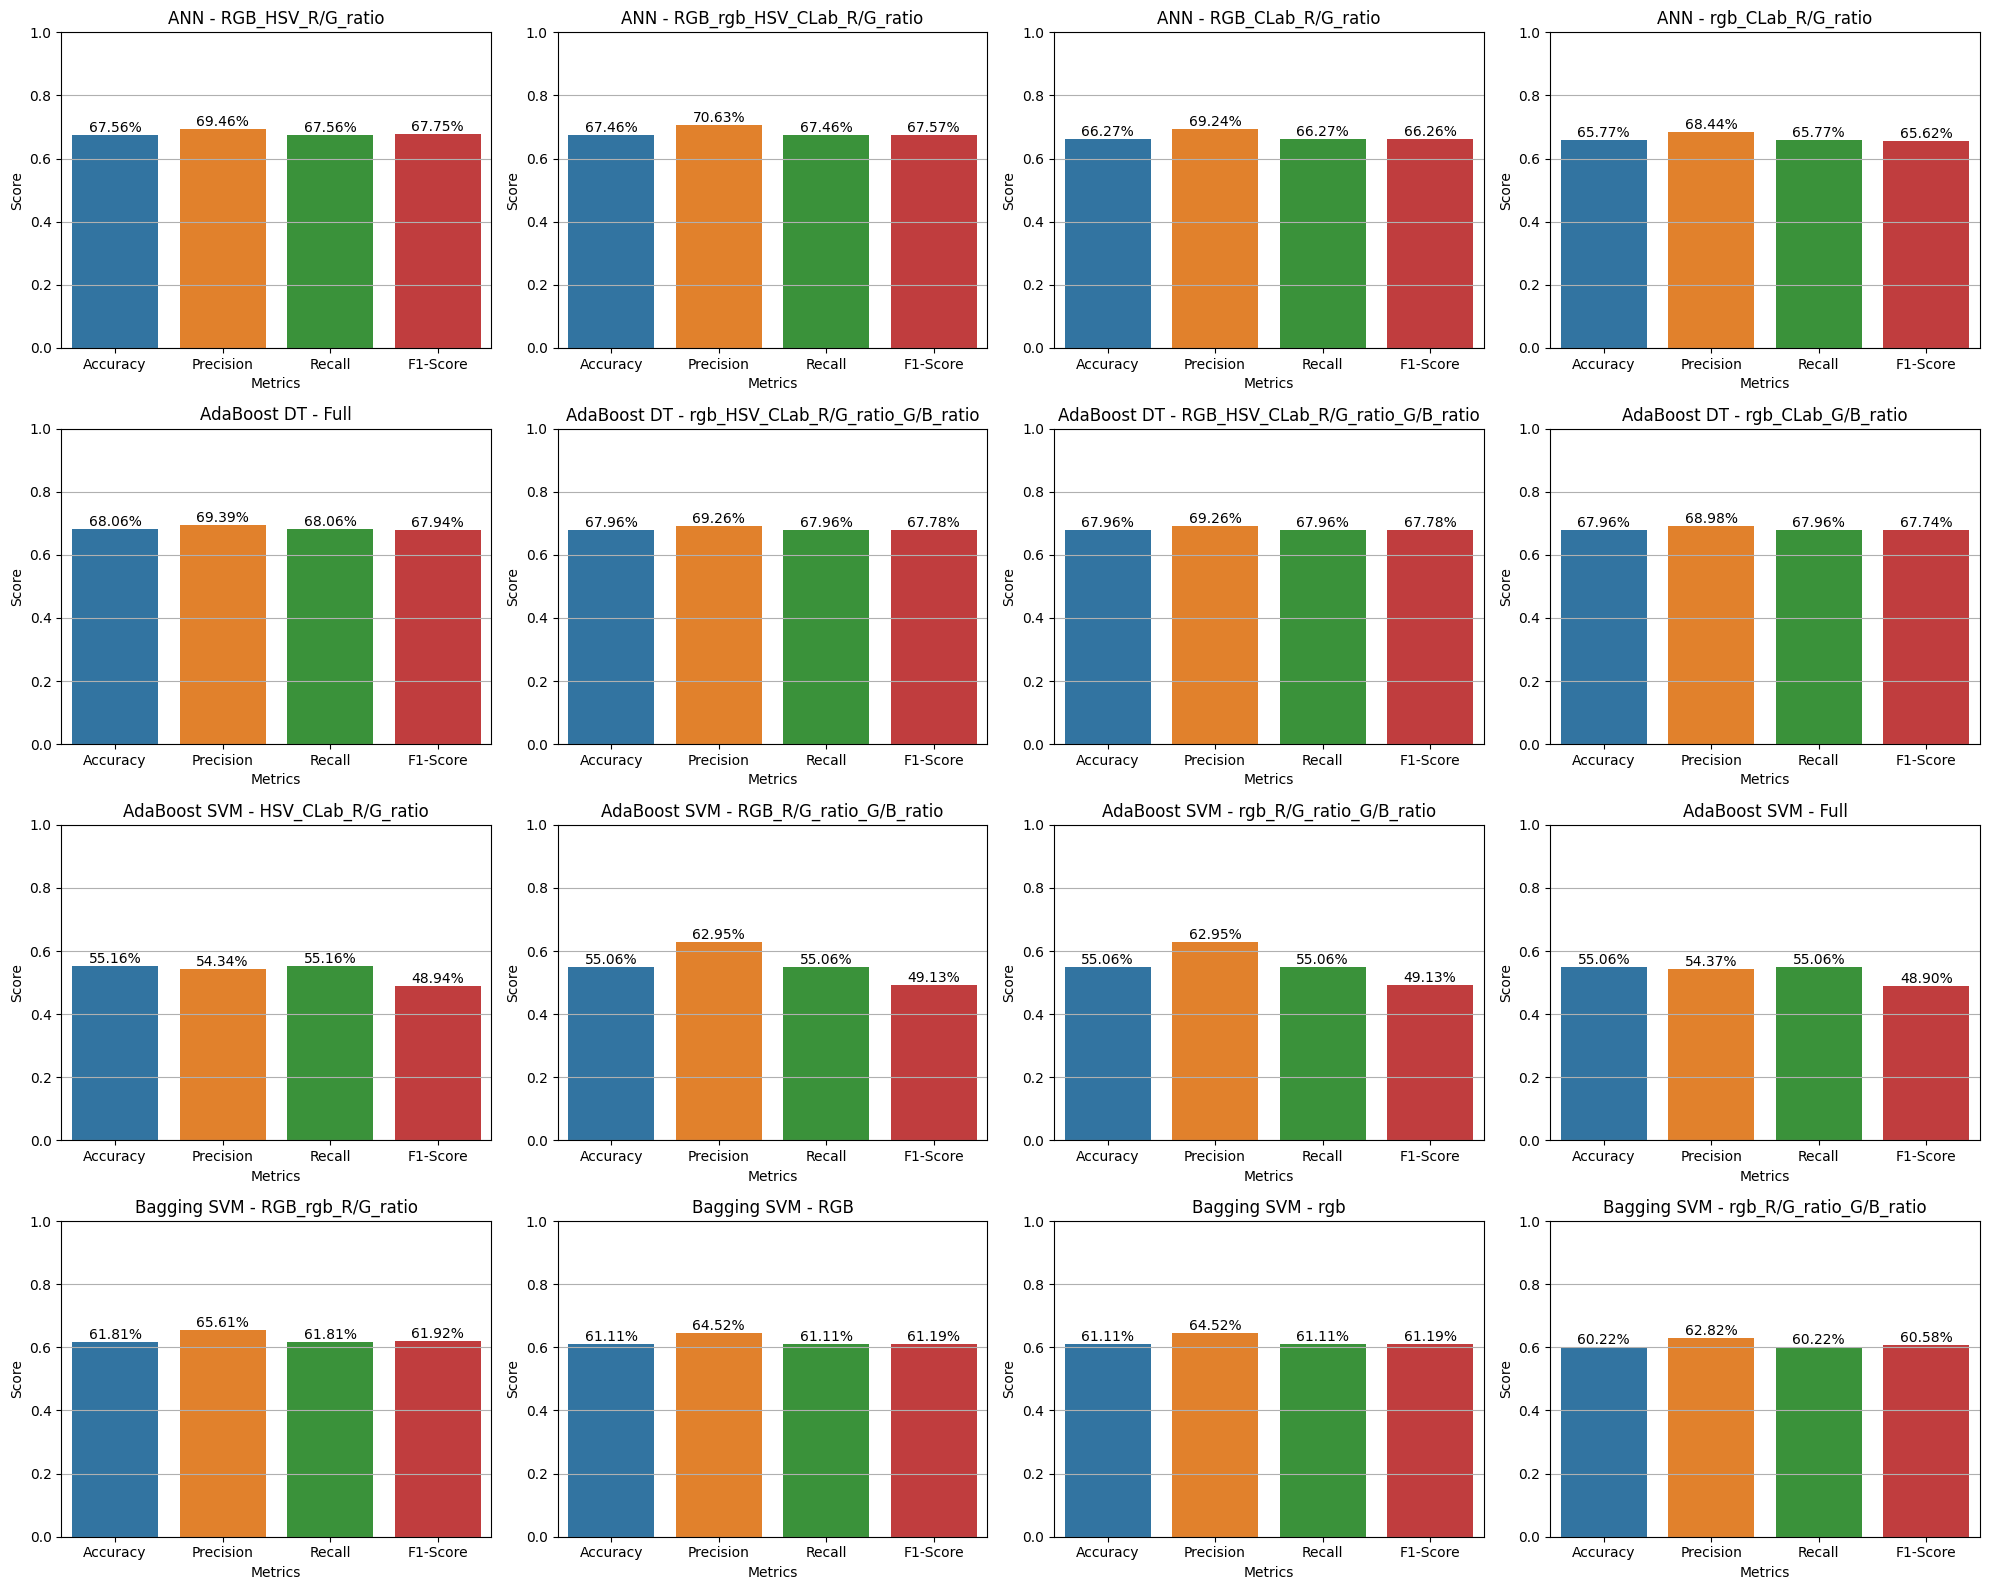

In [ ]:
visualize_model_feature_metrics(
    metrics_dict=metrics_dicts_average_cv,
    model_names=model_names_tuned,
)

### **Final Model**

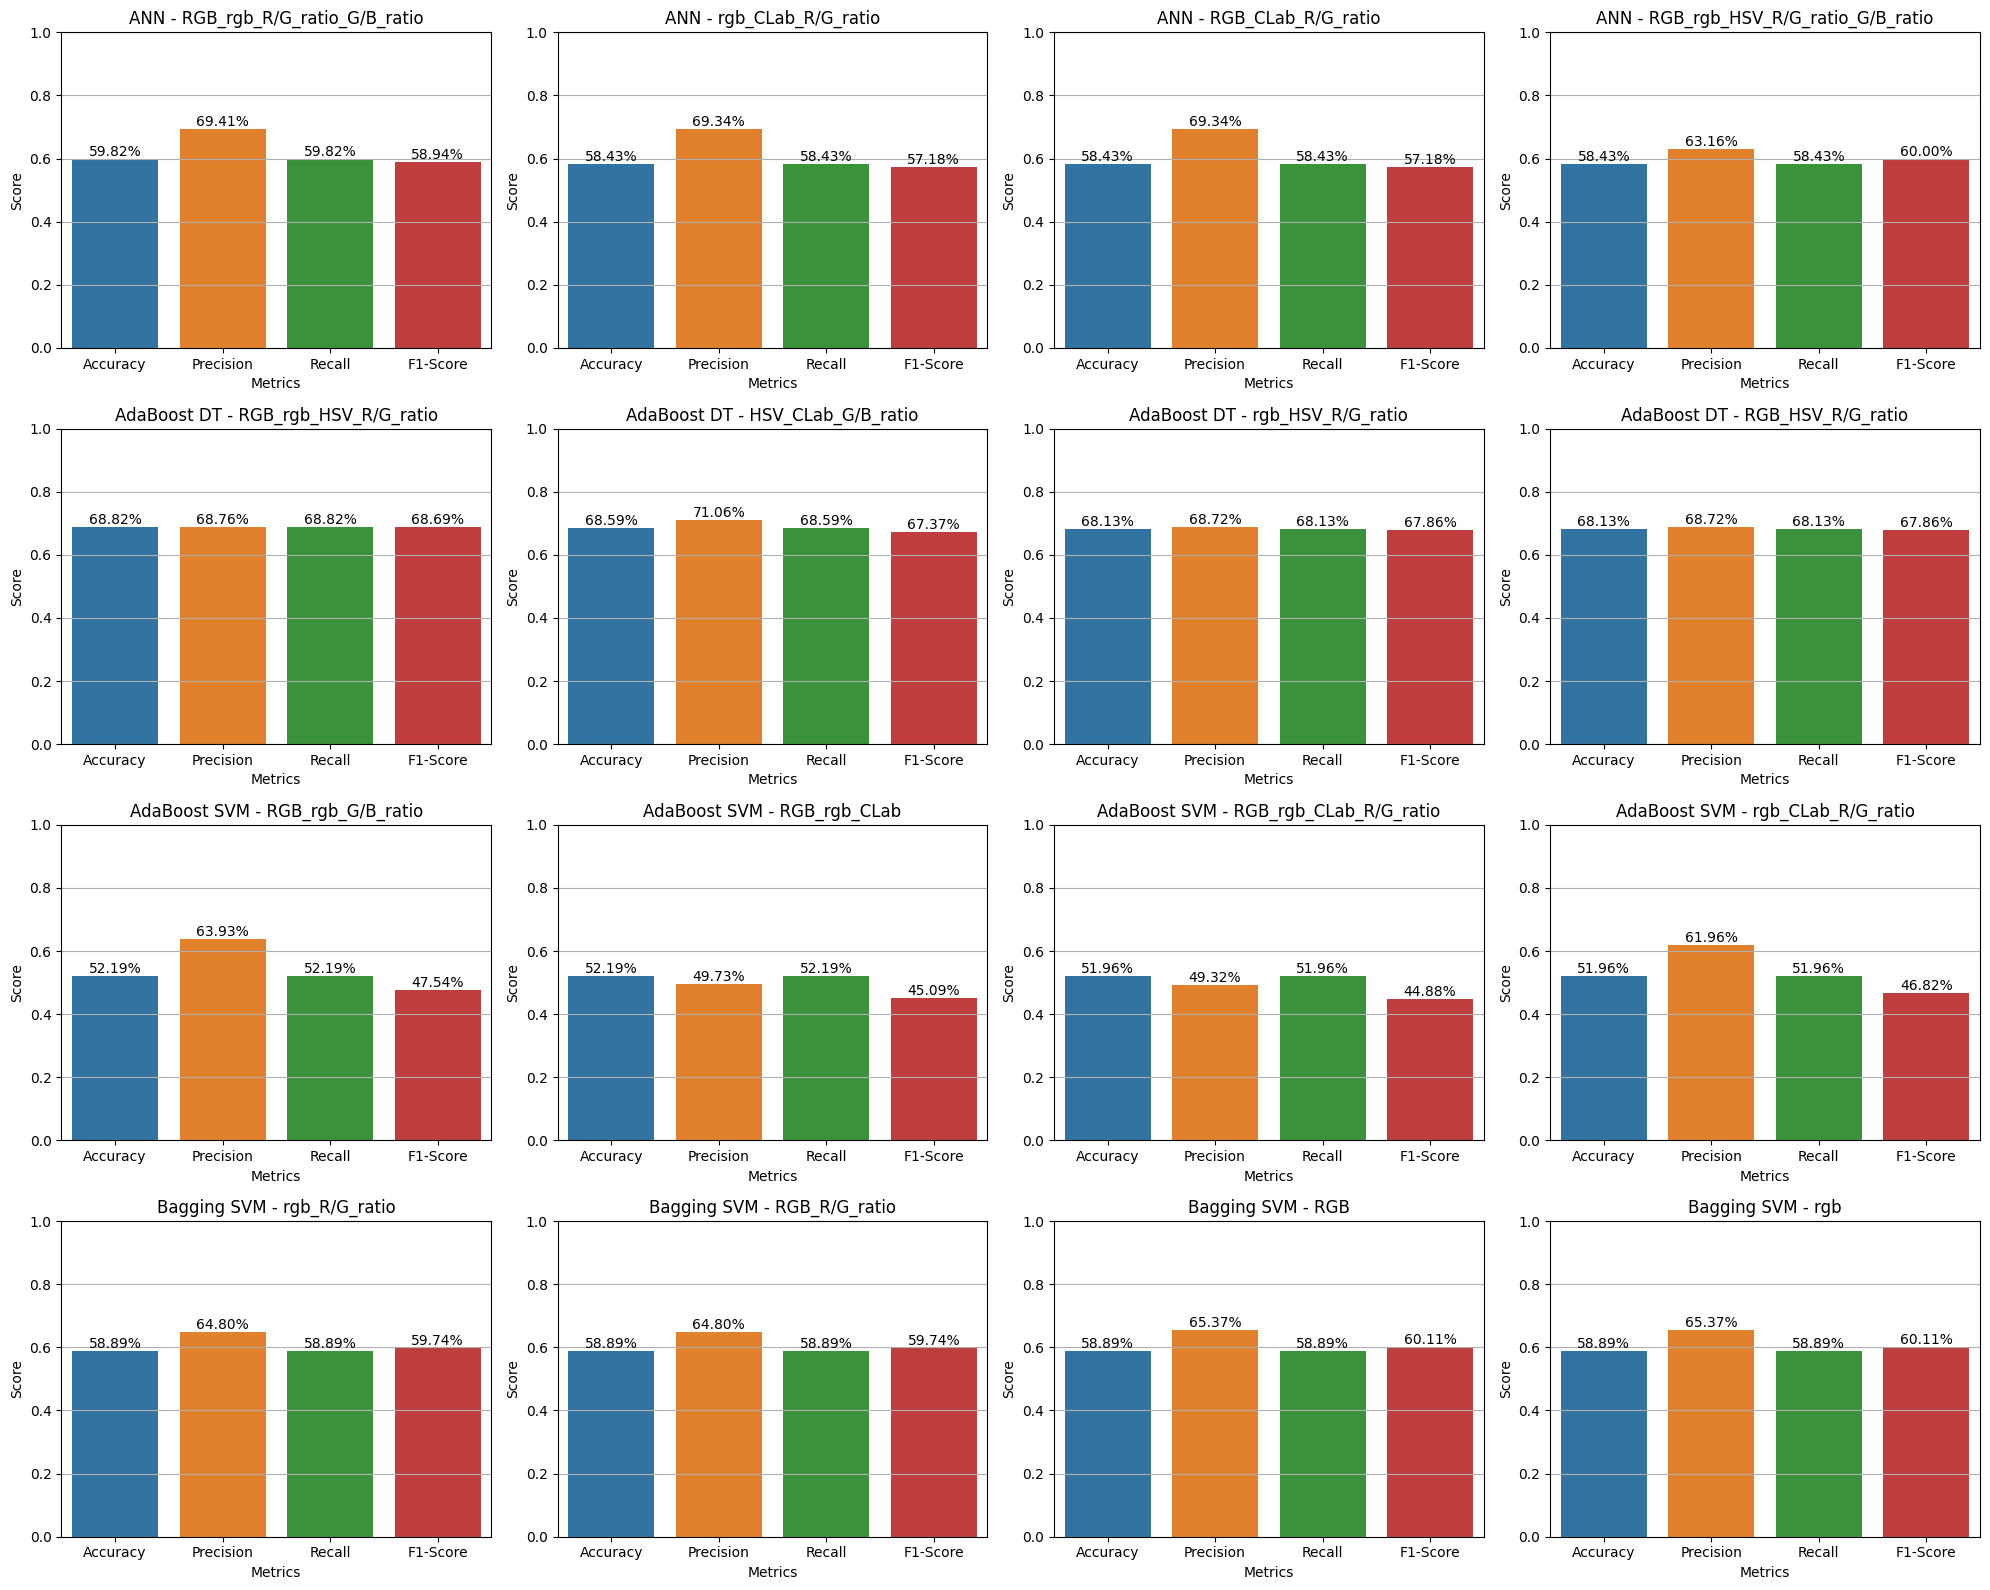

In [ ]:
visualize_model_feature_metrics(
    metrics_dict=metrics_dicts_tuned_final,
    model_names=model_names_tuned,
)